In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib
import datetime

timer = mypackage.Timer()

def print_current_time():
    print(datetime.datetime.now())

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
import datetime

def print_current_time():
    print(datetime.datetime.now())
    
print_current_time()

2020-05-14 12:13:14.210377


In [3]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[:4], X_test_orig[:4], Y_train_orig[:4], Y_test_orig[:4]
# channels_used = [7, 40, 68, 138, -1]
# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[..., channels_used], X_test_orig[..., channels_used], Y_train_orig[..., channels_used], Y_test_orig[..., channels_used]

X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')
# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# load the scaler from disk
scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [4]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=0.0)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=0.0)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 208), (57, 56, 56, 208))

# Test HybridSN

2020-05-14 00:13:30.248224
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (No

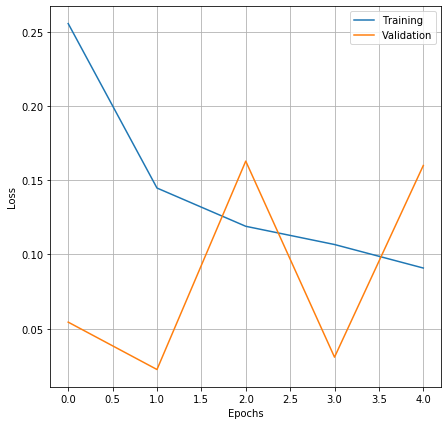

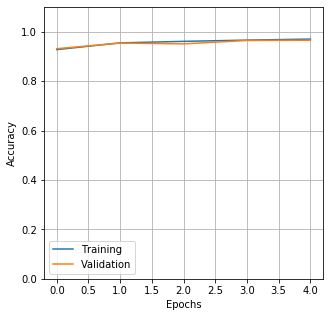

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     34731
         1.0       0.94      0.98      0.96     21781
         2.0       0.89      0.58      0.70      1856

    accuracy                           0.97     58368
   macro avg       0.94      0.84      0.88     58368
weighted avg       0.97      0.97      0.96     58368



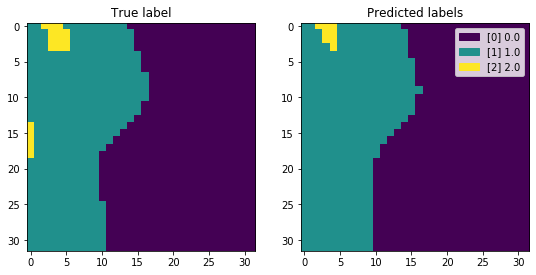

Elapsed time: 583.7049 seconds
Fasle positive blobs 44.
Fasle positive blobs per image 0.7719


In [5]:
print_current_time()

model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [6]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([915683, 342798,  31759]))
(array([0., 1., 2.]), array([366634, 200022,  17024]))


# Testing SVM

In [7]:
# Started the training at ~16:30
# Finished training at ~17:00

In [8]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 208))

2020-05-14 03:10:25.384351
[LibSVM]Elapsed time: 4259.6147 seconds
Elapsed time: 2110.1921 seconds
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    366634
         1.0       0.97      0.97      0.97    200022
         2.0       0.88      0.77      0.82     17024

    accuracy                           0.98    583680
   macro avg       0.95      0.91      0.93    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 407.
Fasle positive blobs per image 0.7140


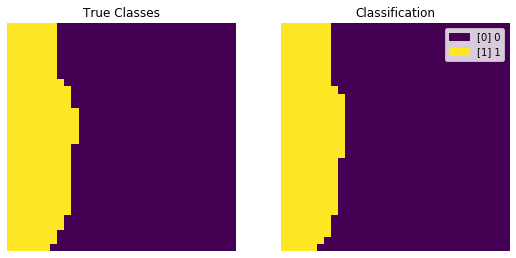

In [9]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=10, kernel='rbf', gamma=0.1)
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

### Linear - SVM

2020-05-14 04:56:36.089177
[LibSVM]Elapsed time: 1552.7680 seconds
Elapsed time: 1468.8550 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    366634
         1.0       0.97      0.97      0.97    200022
         2.0       0.92      0.73      0.82     17024

    accuracy                           0.98    583680
   macro avg       0.96      0.90      0.93    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 76.
Fasle positive blobs per image 0.1333


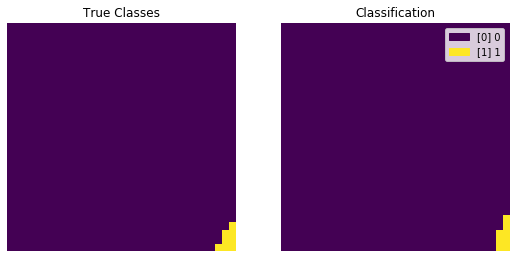

In [10]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=0.1, kernel='linear')
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [11]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

2020-05-14 05:46:58.729764
Elapsed time: 660.5345 seconds
Elapsed time: 0.7738 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    915683
         1.0       0.95      0.97      0.96    342798
         2.0       0.91      0.59      0.72     31759

    accuracy                           0.98   1290240
   macro avg       0.95      0.85      0.89   1290240
weighted avg       0.98      0.98      0.98   1290240

Elapsed time: 0.3591 seconds
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    366634
         1.0       0.97      0.96      0.96    200022
         2.0       0.90      0.67      0.77     17024

    accuracy                           0.97    583680
   macro avg       0.95      0.87      0.91    583680
weighted avg       0.97      0.97      0.97    583680

Fasle positive blobs 216.
Fasle positive blobs per image 0.3789


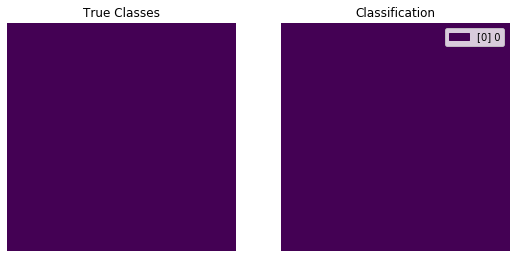

In [12]:
print_current_time()

logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l2', saved_mode_name="latest_LogisticReg_l2_model.sav")# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

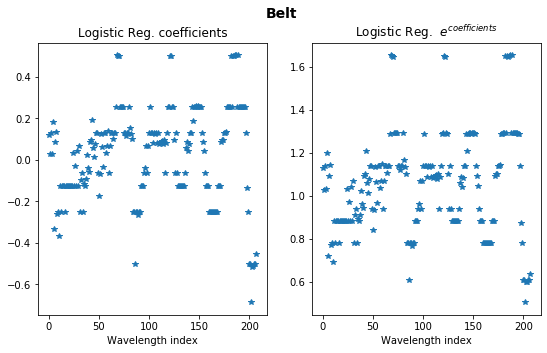

Ordered four most useful wavelengths are: [1602, 1609, 1173, 1599]nm
There corresponding indexes are: [187 189  68 186]


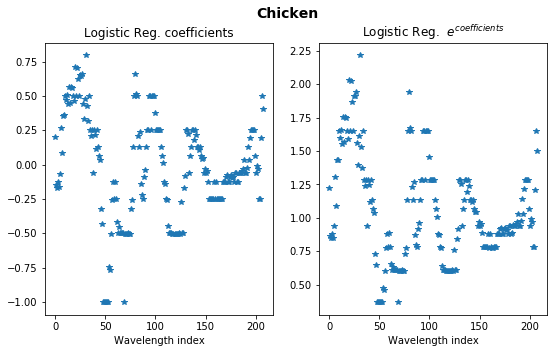

Ordered four most useful wavelengths are: [1040, 1000, 1007, 1216]nm
There corresponding indexes are: [31 20 22 80]


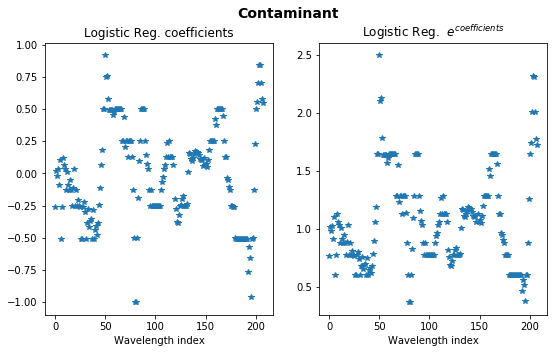

Ordered four most useful wavelengths are: [1108, 1660, 1664, 1115]nm
There corresponding indexes are: [ 50 203 204  52]


In [13]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [14]:
np.unique(Y_train_orig, return_counts=True)

(array([0, 1, 2], dtype=int32), array([361057,  54747,   4196]))

In [ ]:
print_current_time()

logreg_l1 = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l1', saved_mode_name="latest_LogisticReg_l1_model.sav")# , max_iter=1000)
logreg_l1.train()
# logreg_l1.predict(X_train, Y_train, plot=False)
print_current_time()
Y_hat = logreg_l1.predict(X_test, Y_test)
print_current_time()

mypackage.report_count_false_positive(Y_hat, Y_test)

2020-05-14 05:58:03.823880


In [ ]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg_l1.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg_l1.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [ ]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [ ]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

In [ ]:
print_current_time()

spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [ ]:
# spectral_unet.summary()

### Test 2D UNet on the same data

In [ ]:
print_current_time()

# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [ ]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

In [ ]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [ ]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))

In [ ]:
model_hsn = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)

print("##################################")
print("# Additional HybridSN prediction #")
timer.start()
Y_hat = model_hsn.predict(X_test, Y_test)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test)

Summary runtimes
HybridSN
    X_test_HS -> (57, 56, 56, 208)
    586.6562 seconds
    10.2922 sec per image

X_test -> (570, 32, 32, 1)

SVM RBF    - 2109.1566 seconds -> 3.7003
SVM Linear - 3243.4765 seconds -> 5.6903

LR l2 - 0.3546 seconds -> 0.0006
LR l1 - 

SpectralUNet - 7.3087 seconds -> 0.0128
UNet - 1.0001 seconds -> 0.0018
UNet +DL - 1.2491     -> 0,0022
UNet +DL+CCE - 1.1801 -> 0,0021

### Additional SpectralUNet runs

In [ ]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[:4], X_test_orig[:4], Y_train_orig[:4], Y_test_orig[:4]
# channels_used = [7, 40, 68, 138, -1]
# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[..., channels_used], X_test_orig[..., channels_used], Y_train_orig[..., channels_used], Y_test_orig[..., channels_used]

X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (570, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([906593, 349535,  34112]))
(array([0., 1., 2.]), array([362757, 204296,  16627]))
2020-05-14 09:14:24.266406
Start training
Elapsed time: 1871.6798 seconds


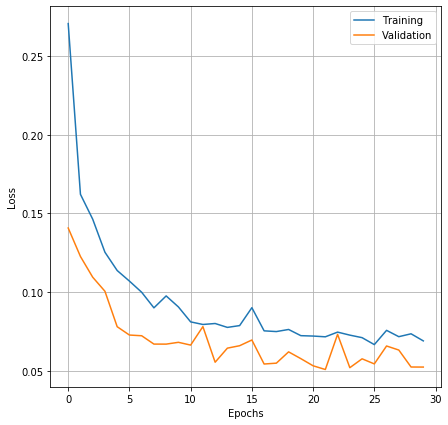

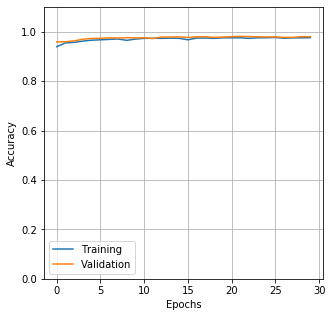

Predicting for train data
Elapsed time: 16.4570 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    906593
           1       0.96      0.97      0.97    349535
           2       0.85      0.77      0.81     34112

    accuracy                           0.98   1290240
   macro avg       0.94      0.91      0.92   1290240
weighted avg       0.98      0.98      0.98   1290240



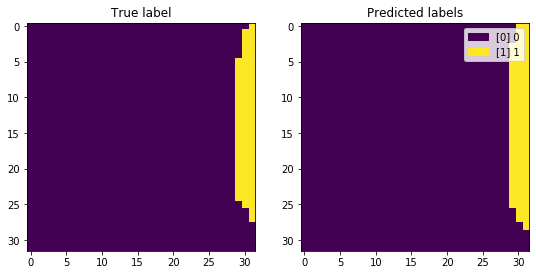

Predicting for test data
Elapsed time: 7.1112 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    362757
           1       0.97      0.96      0.96    204296
           2       0.78      0.71      0.74     16627

    accuracy                           0.97    583680
   macro avg       0.91      0.89      0.90    583680
weighted avg       0.97      0.97      0.97    583680



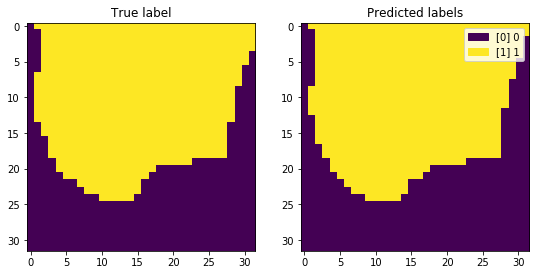

Elapsed time: 8.0060 seconds
Fasle positive blobs 51.
Fasle positive blobs per image 0.0895
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (570, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([889907, 364711,  35622]))
(array([0., 1., 2.]), array([360399, 206077,  17204]))
2020-05-14 09:46:04.839162
Start training


KeyboardInterrupt: 

In [4]:
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print("np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape")
print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

print_current_time()

spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

Elapsed time: 7.2598 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    360399
           1       0.96      0.97      0.97    206077
           2       0.83      0.66      0.74     17204

    accuracy                           0.98    583680
   macro avg       0.93      0.88      0.90    583680
weighted avg       0.97      0.98      0.97    583680



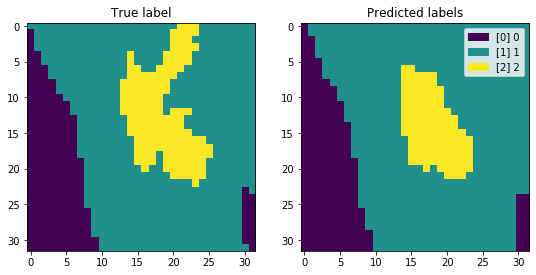

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


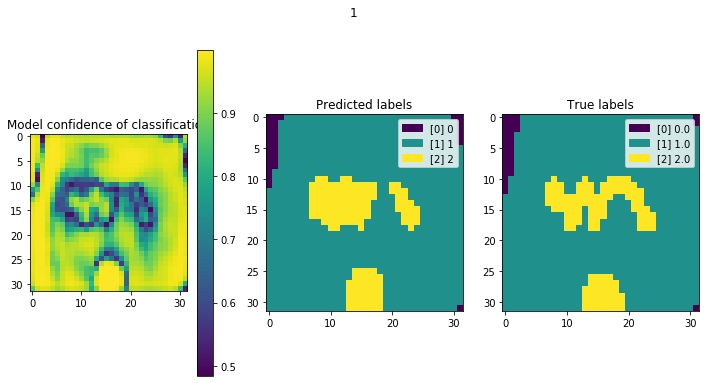

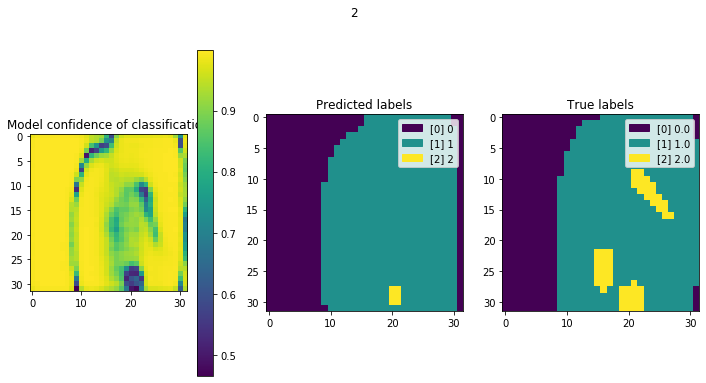

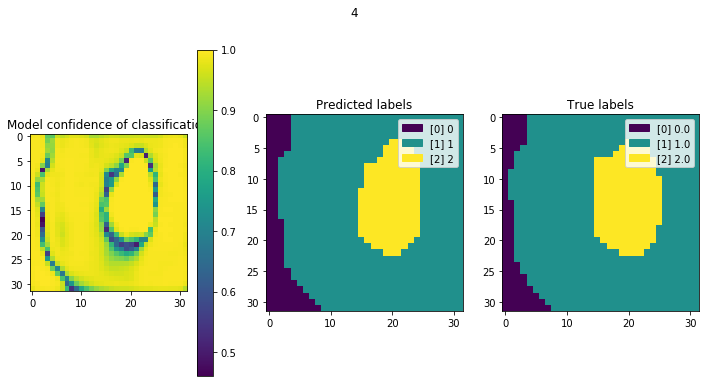

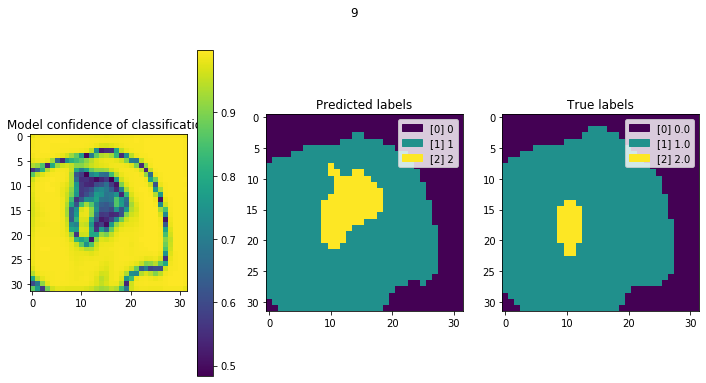

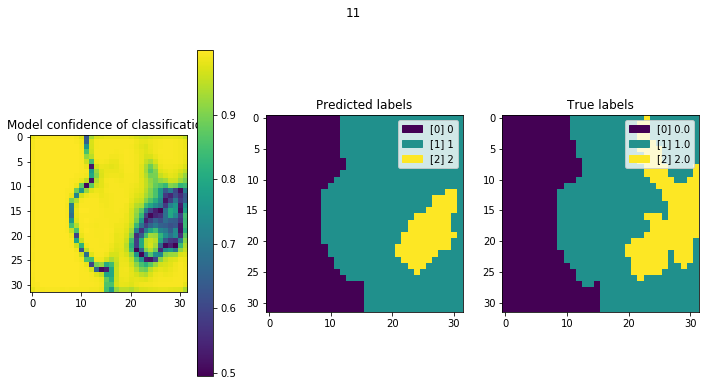

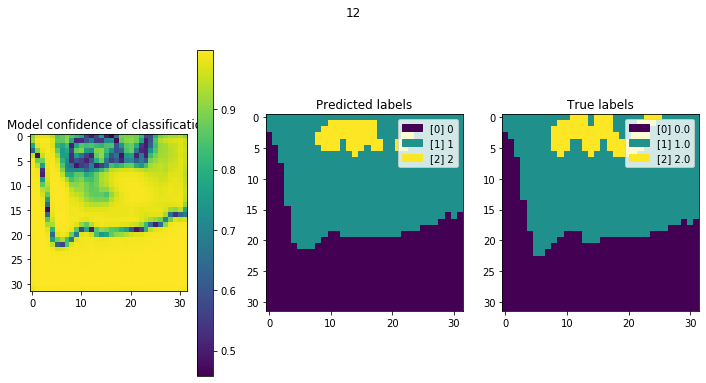

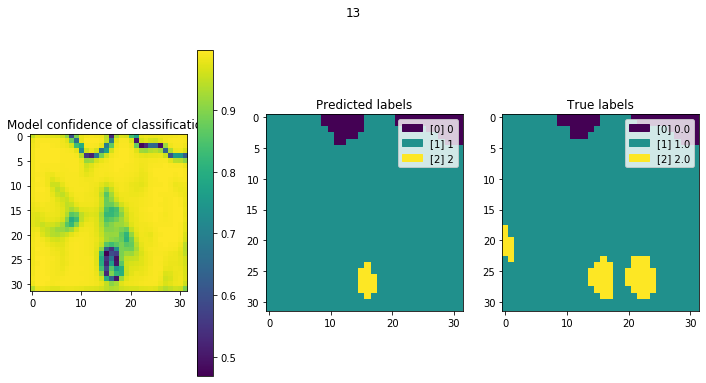

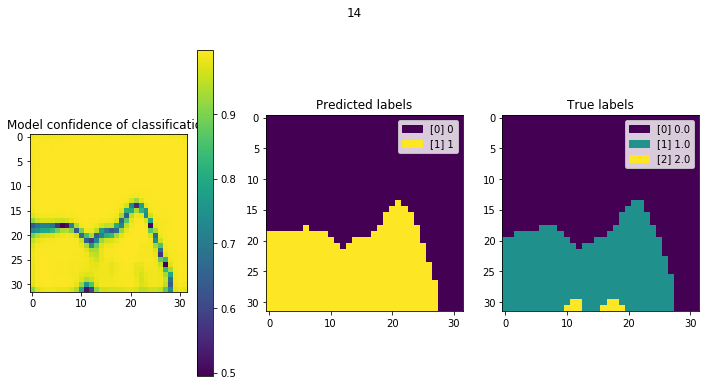

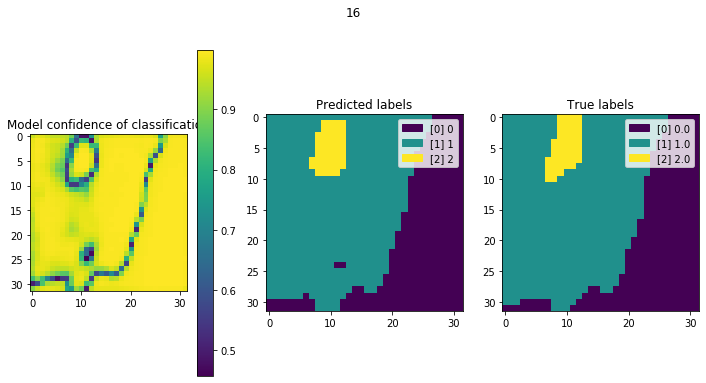

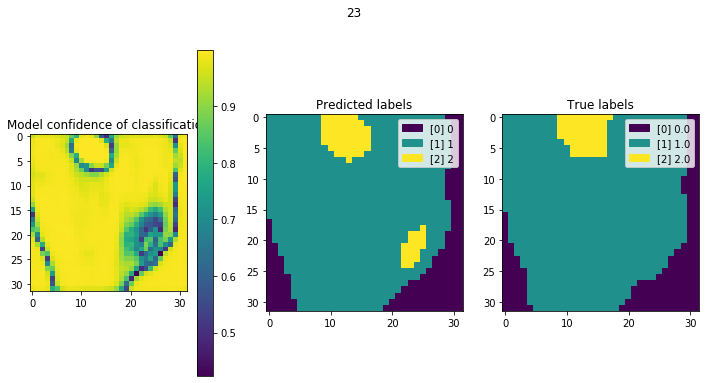

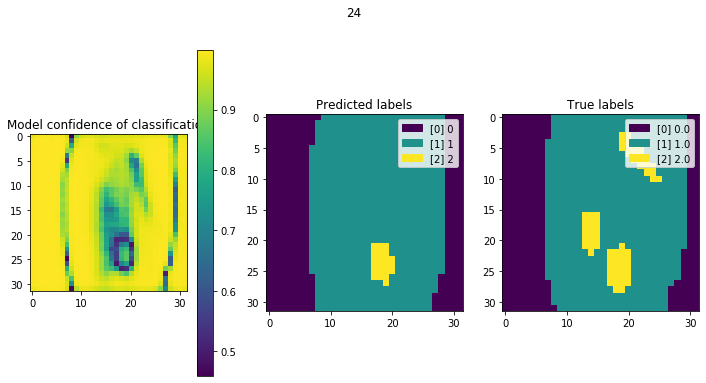

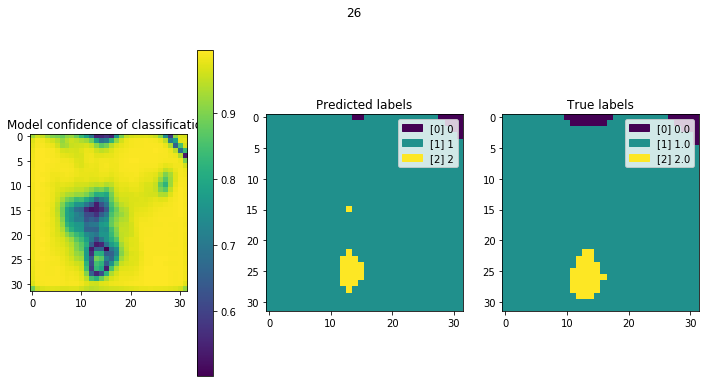

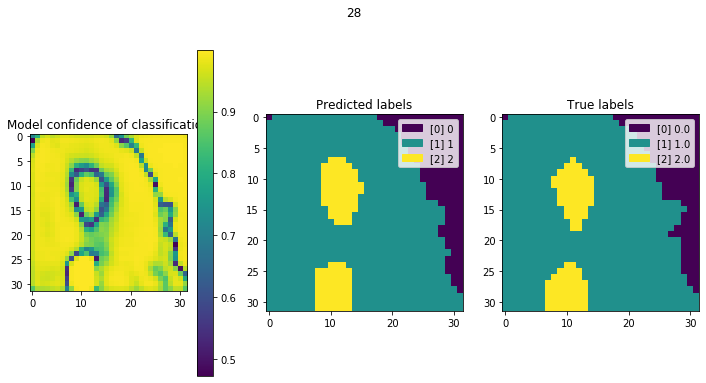

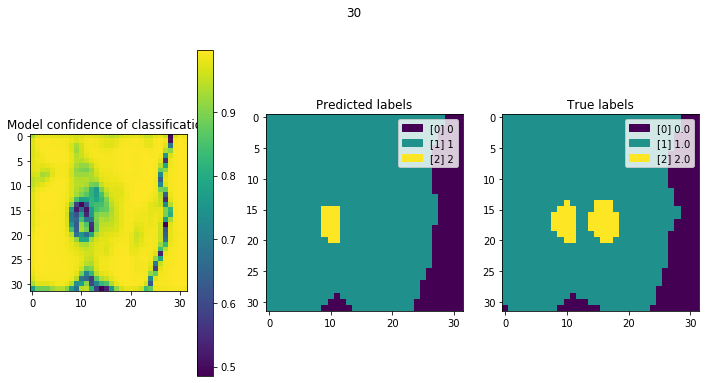

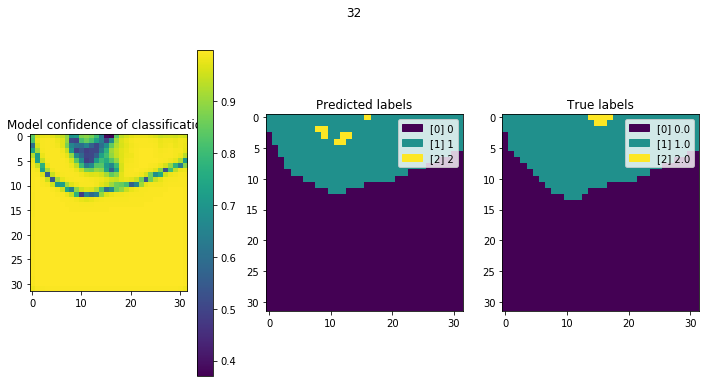

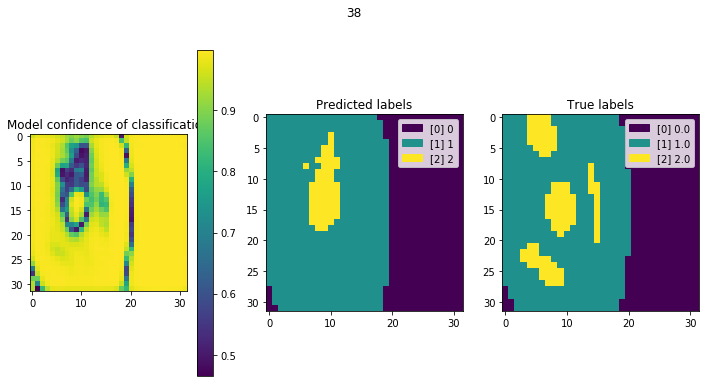

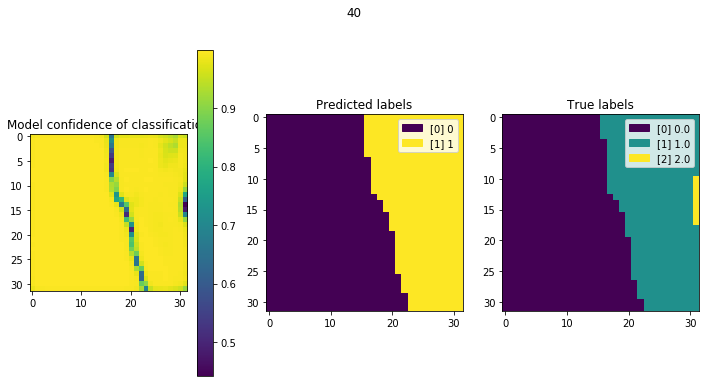

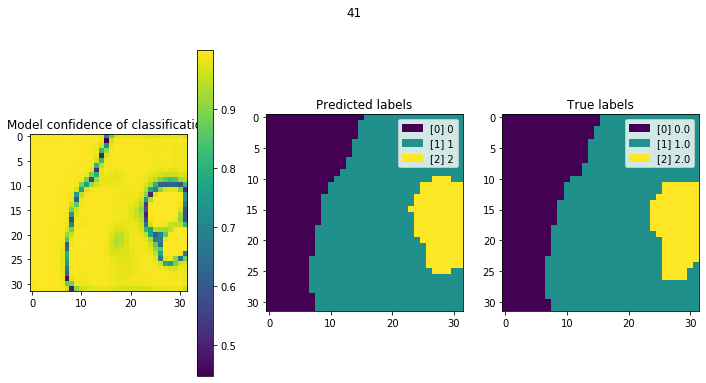

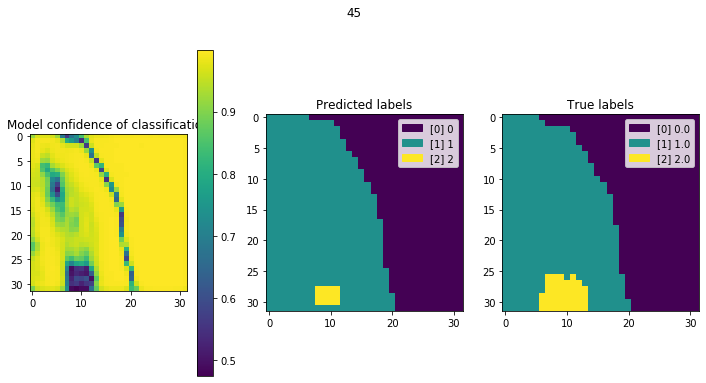

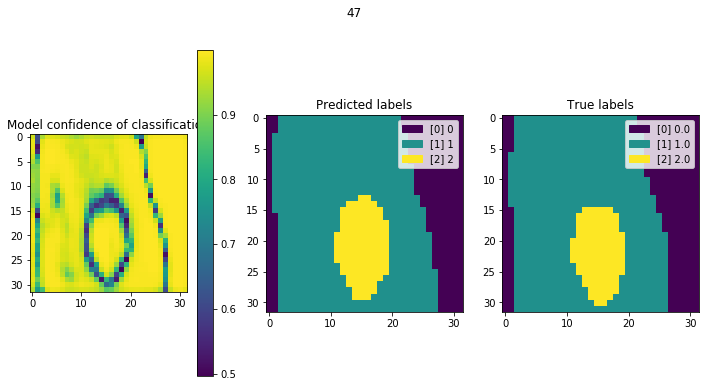

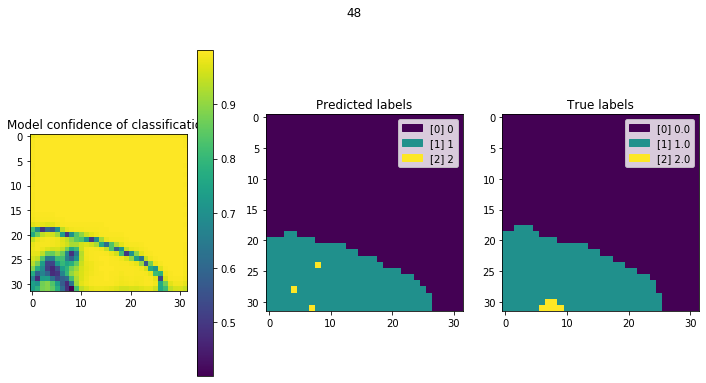

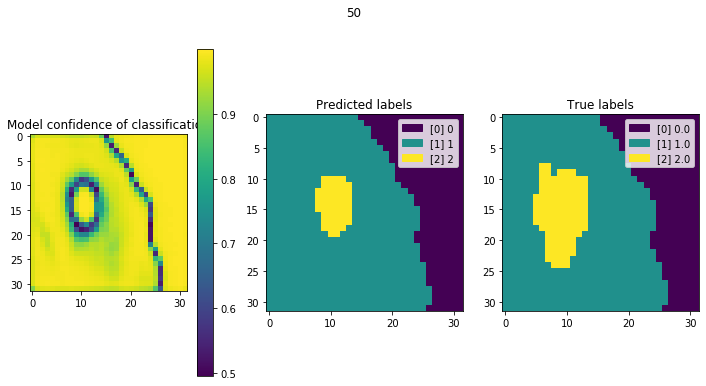

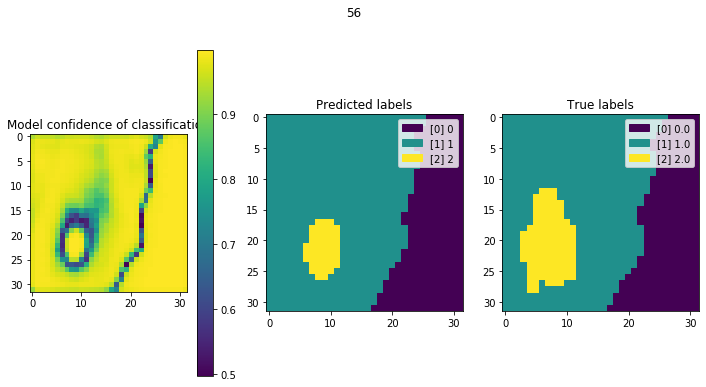

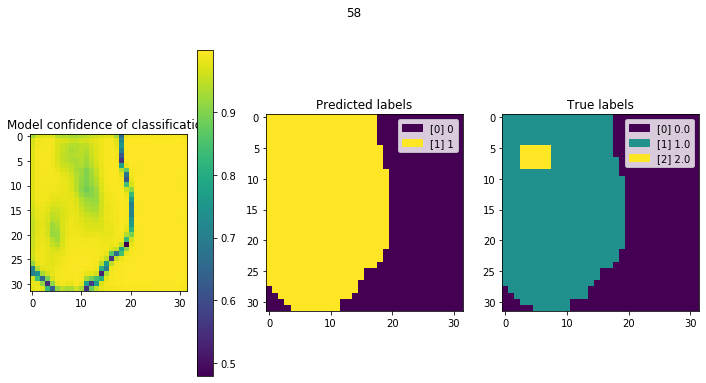

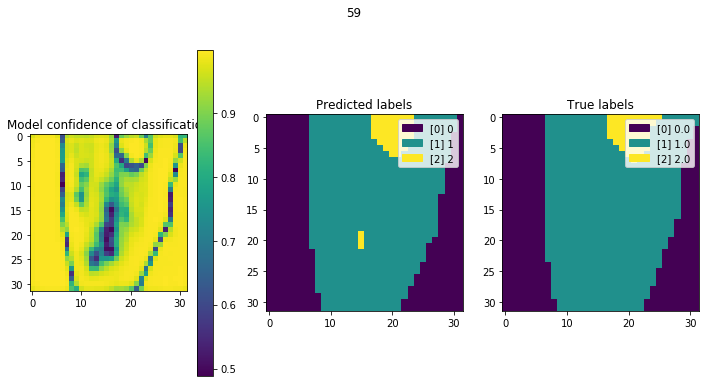

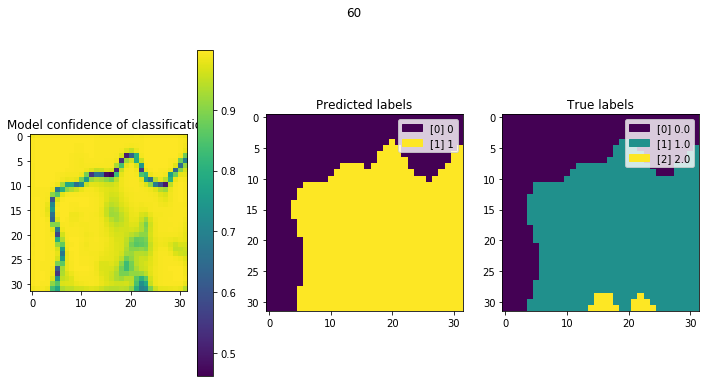

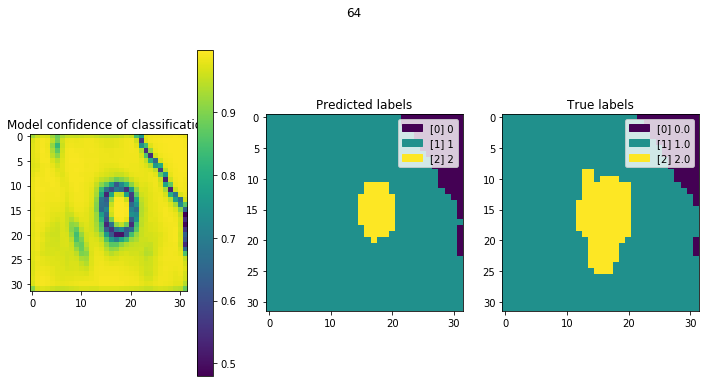

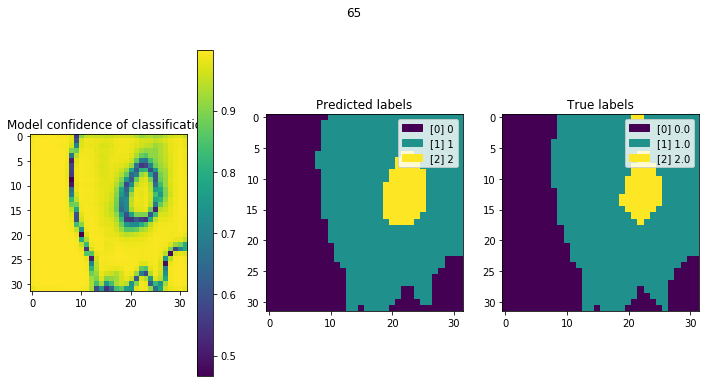

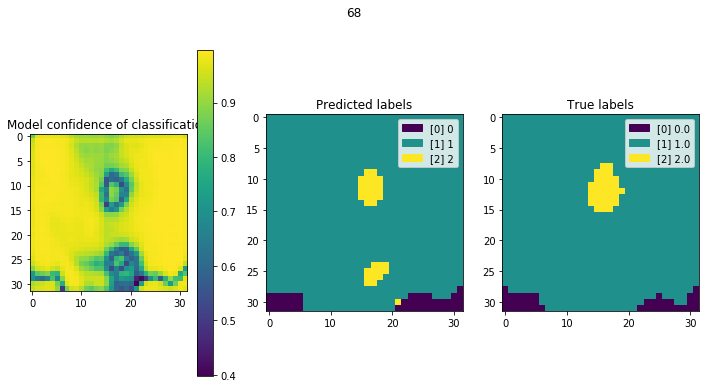

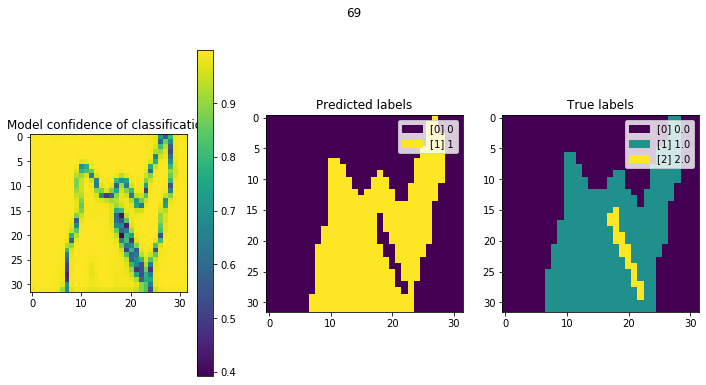

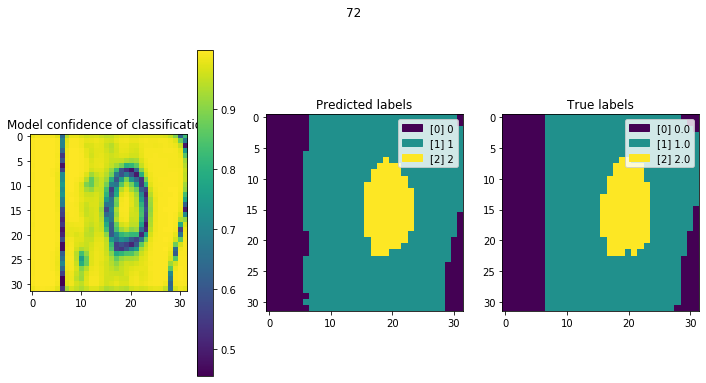

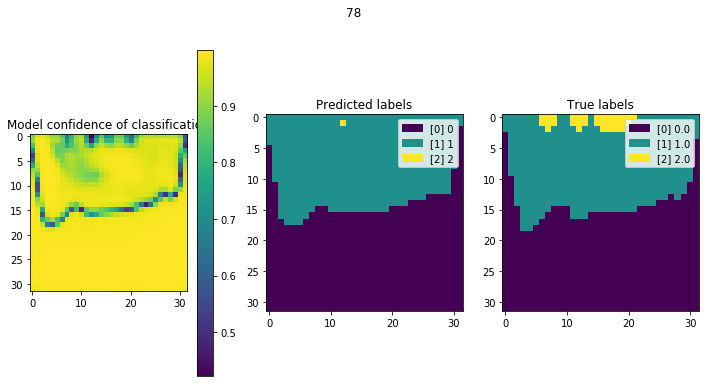

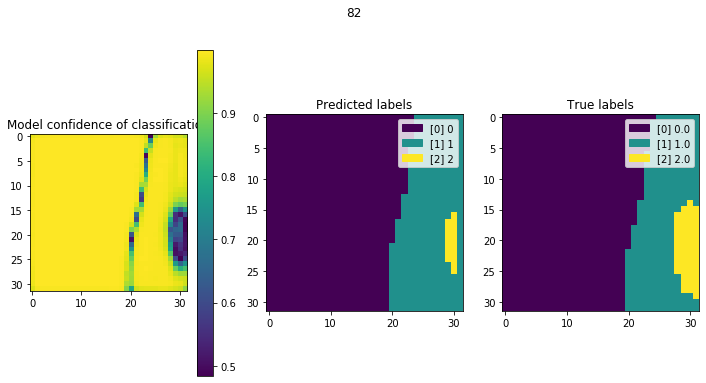

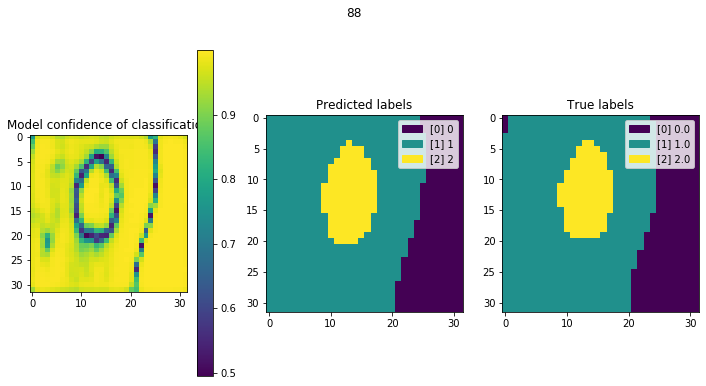

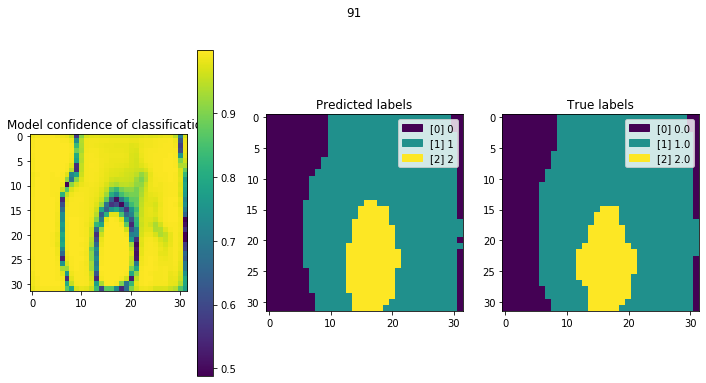

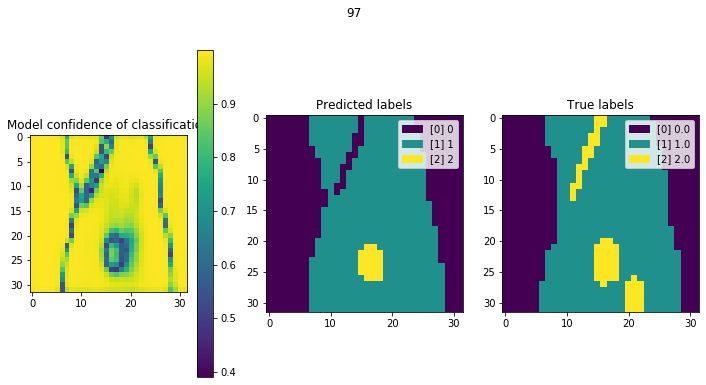

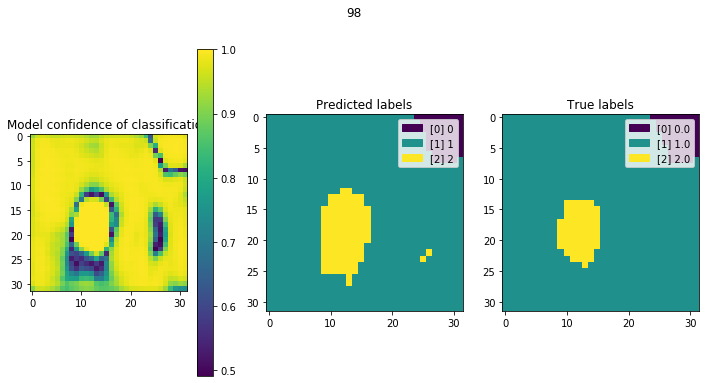

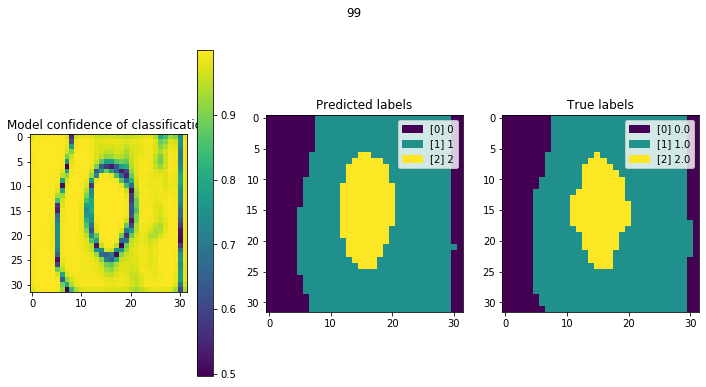

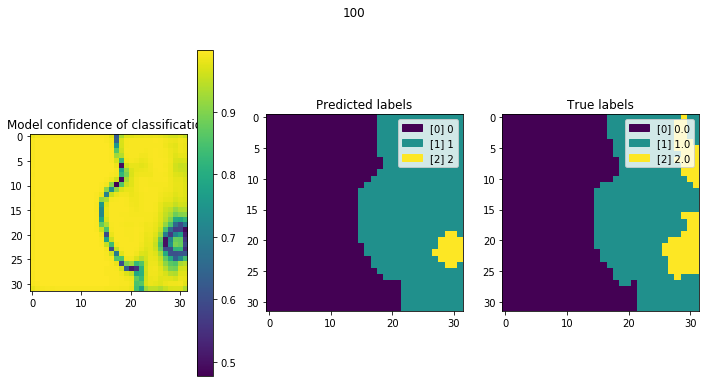

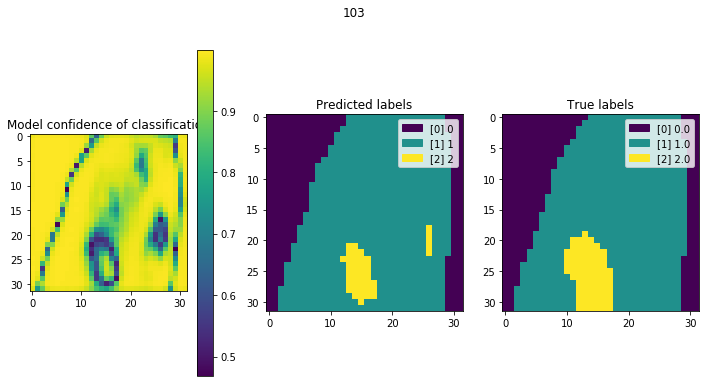

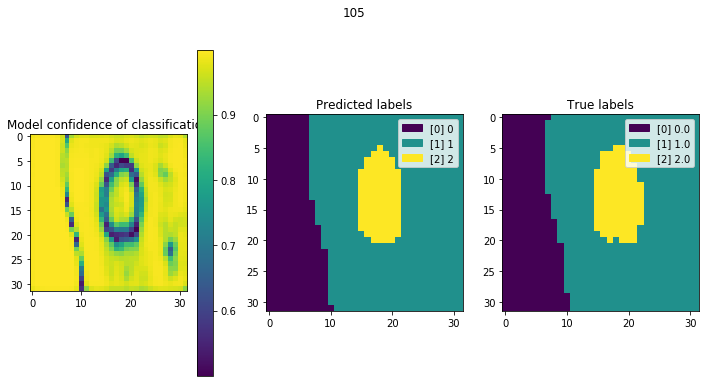

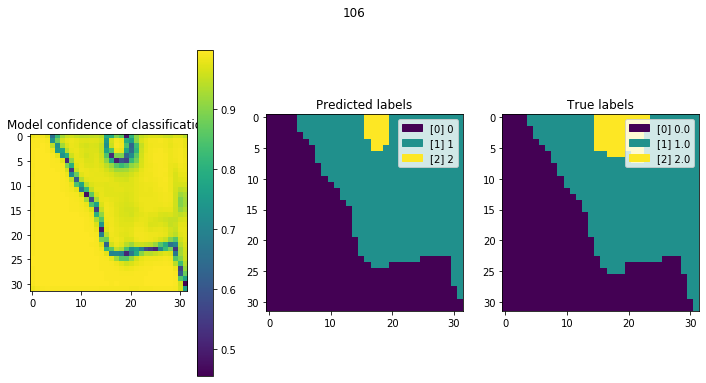

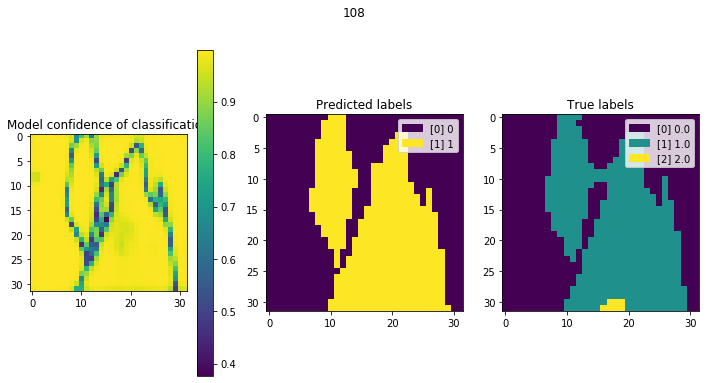

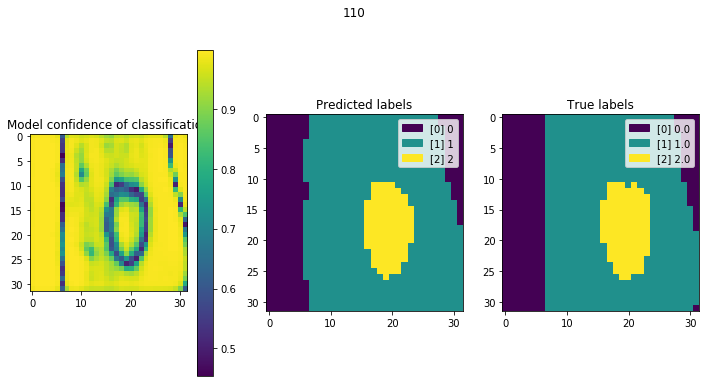

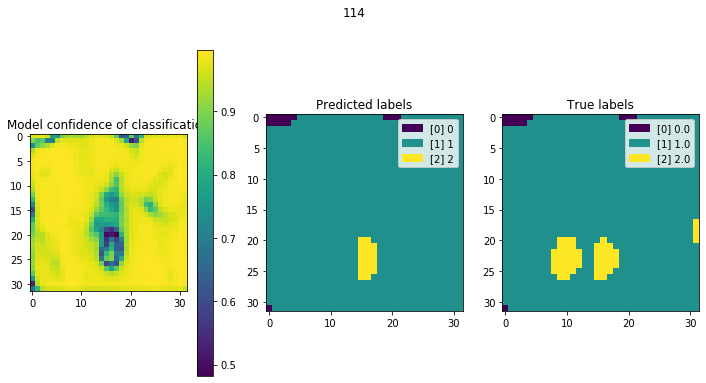

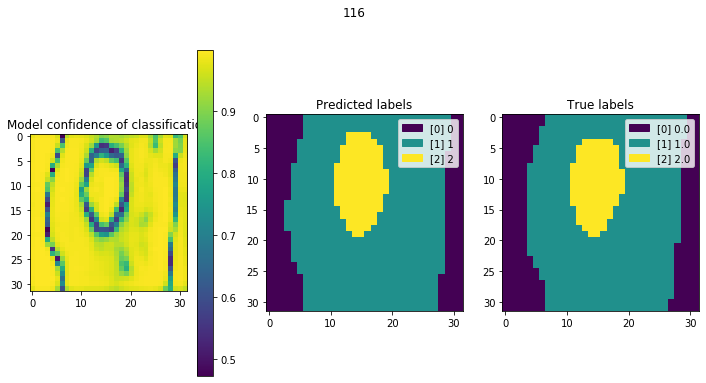

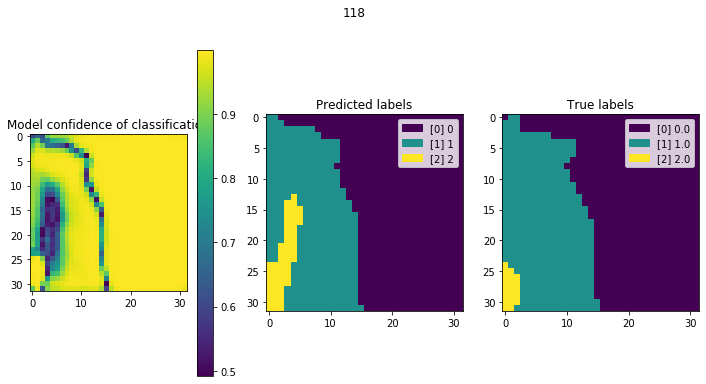

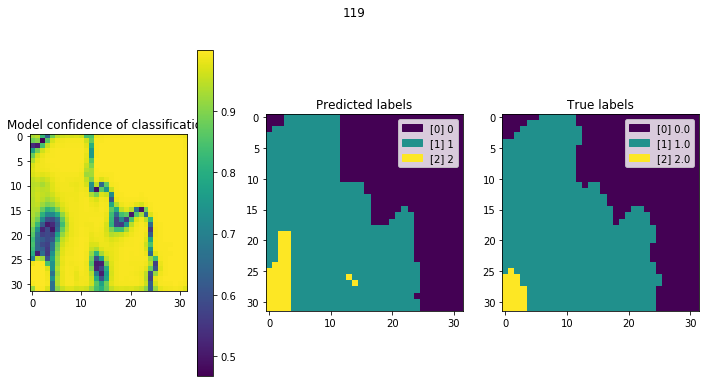

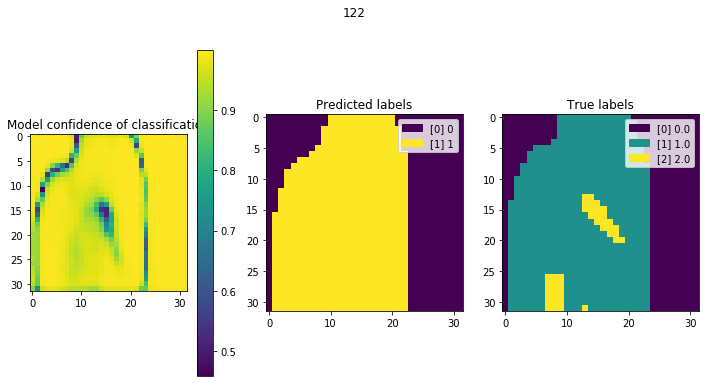

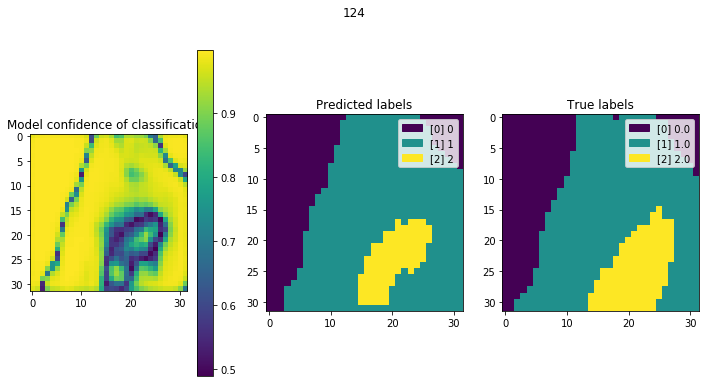

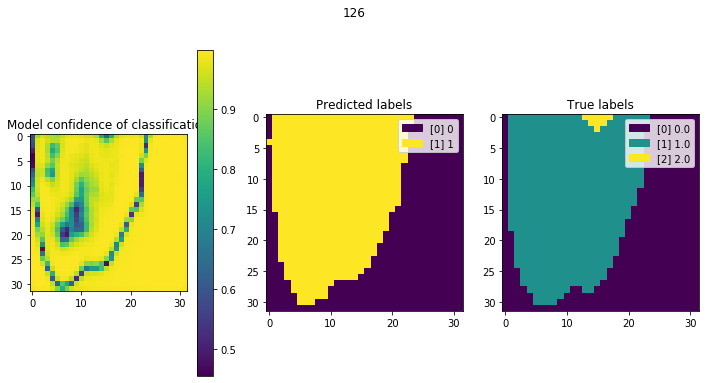

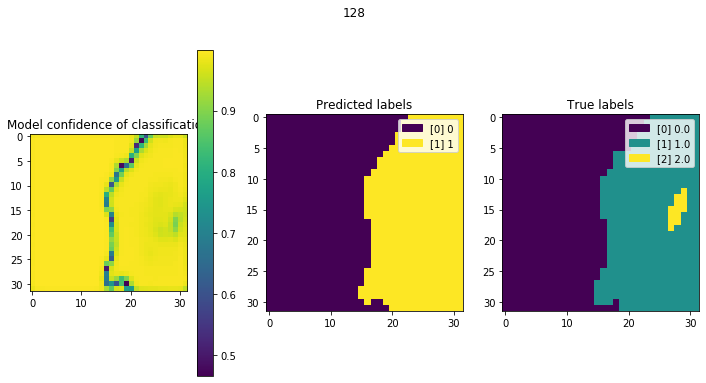

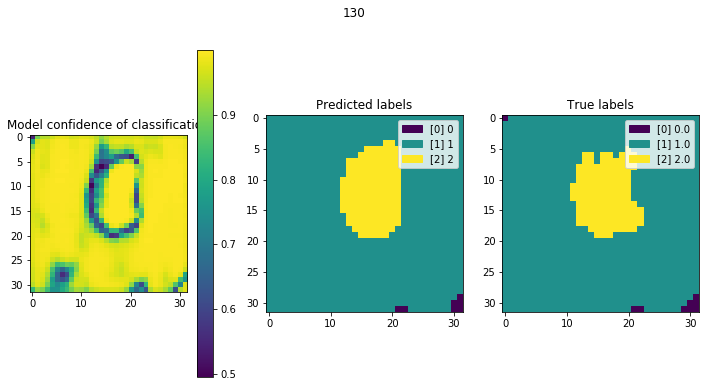

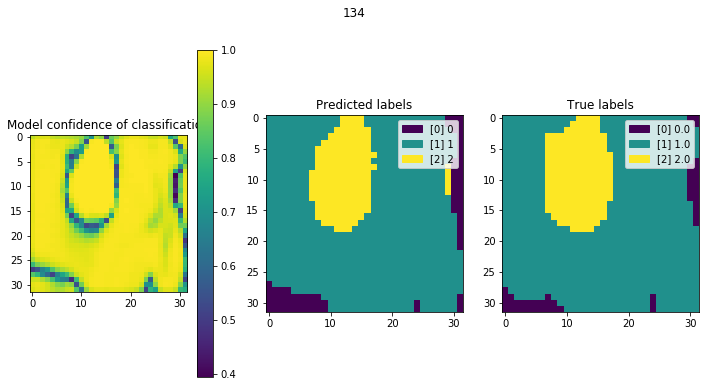

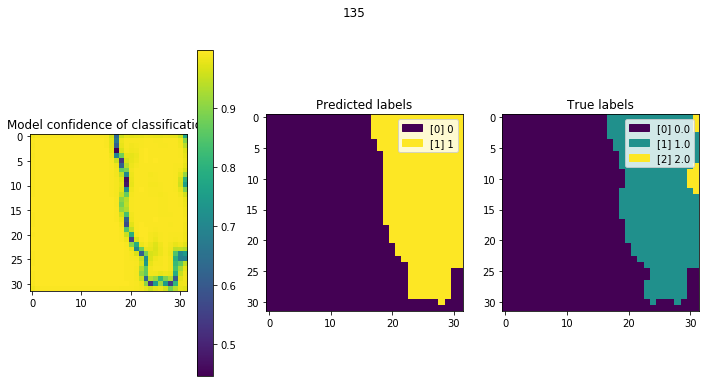

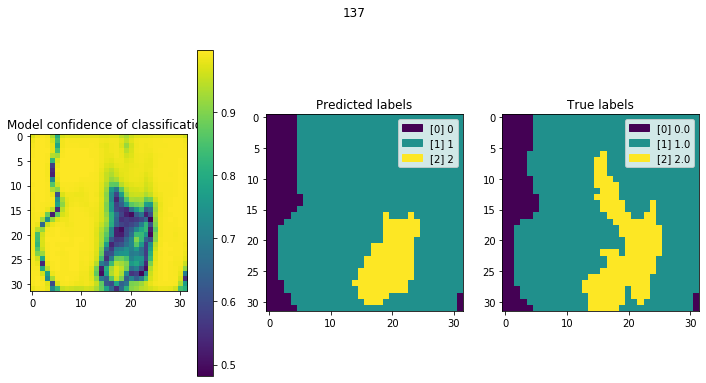

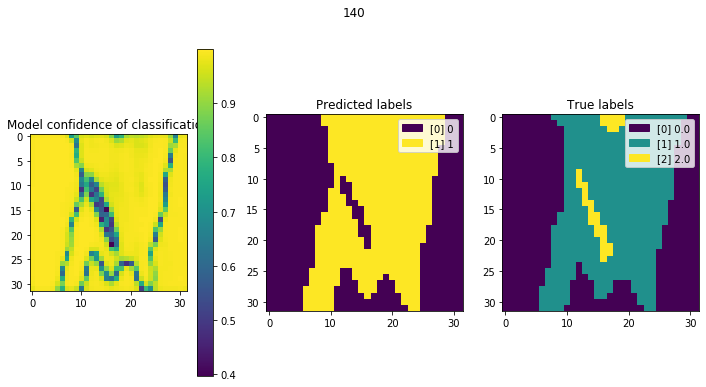

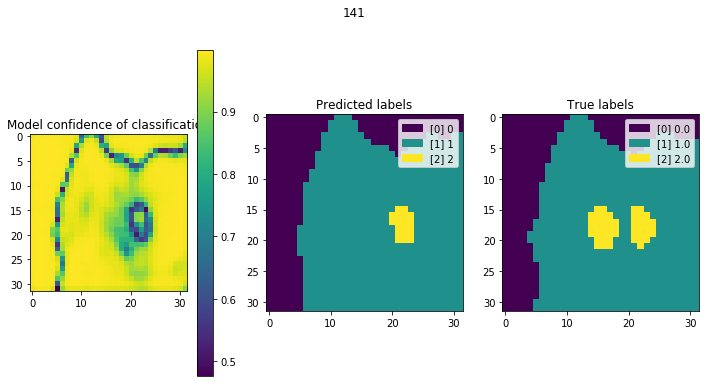

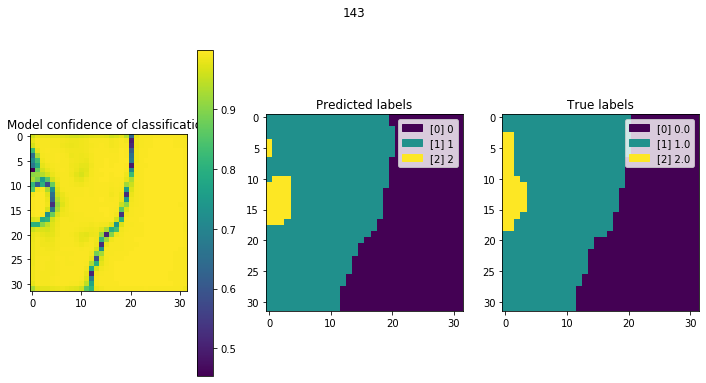

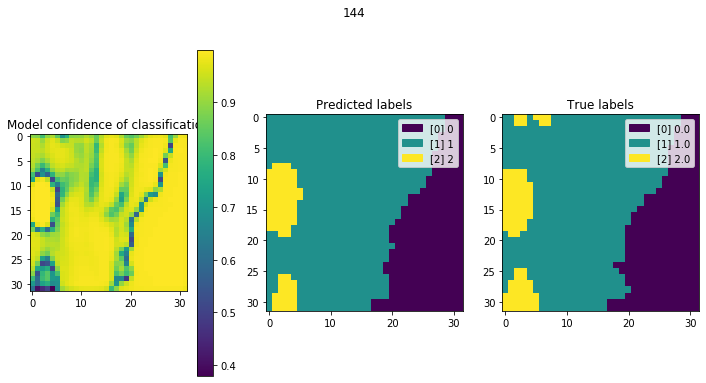

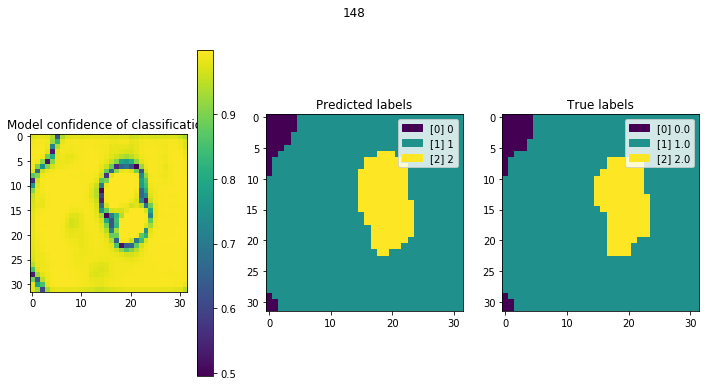

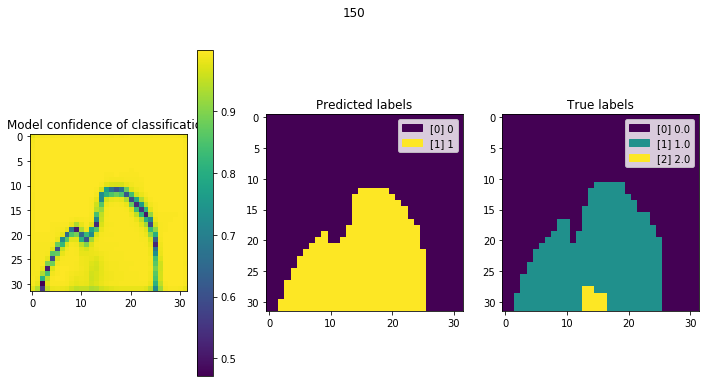

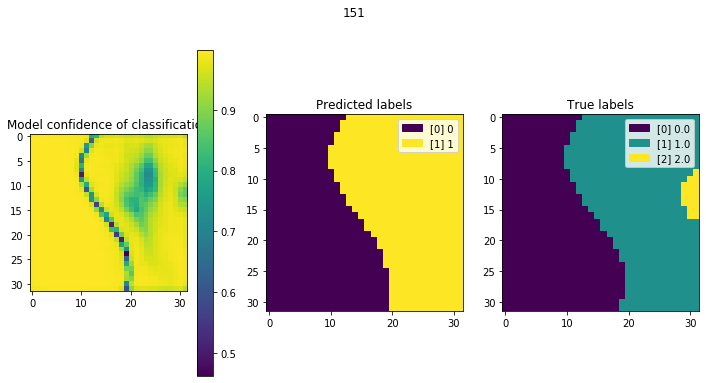

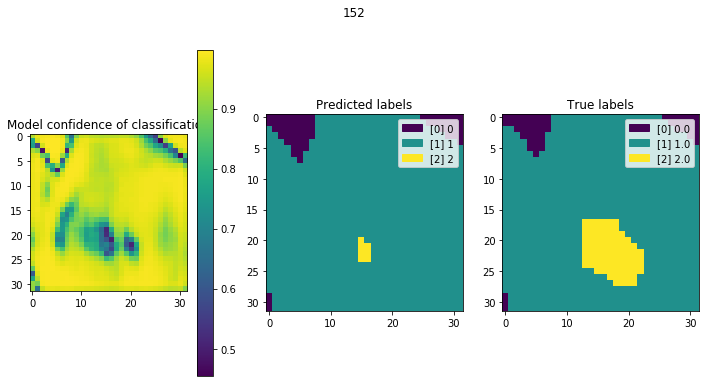

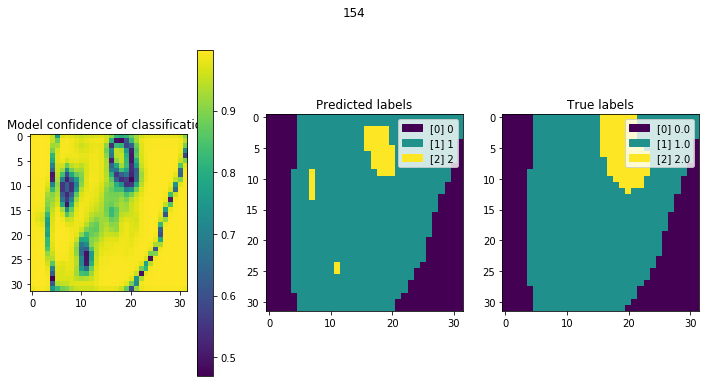

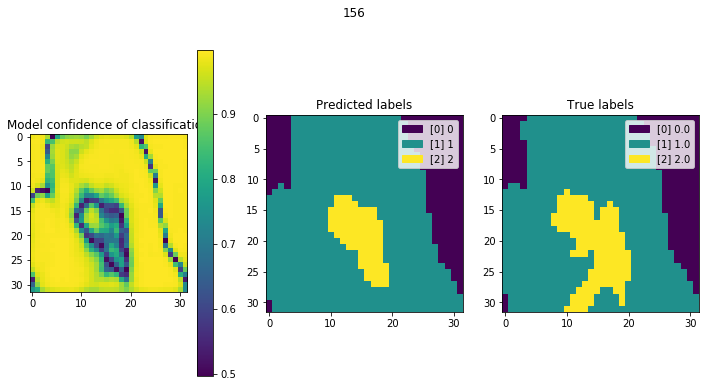

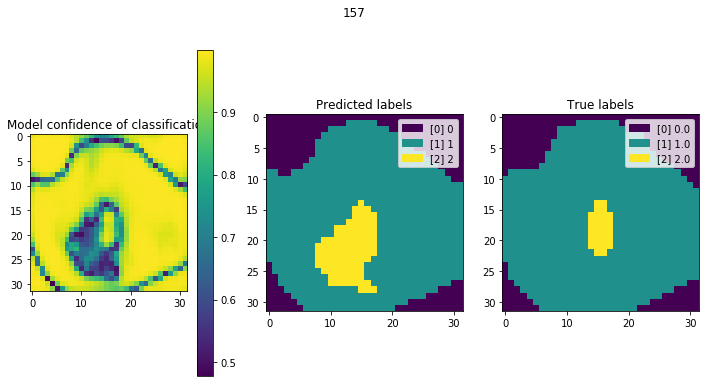

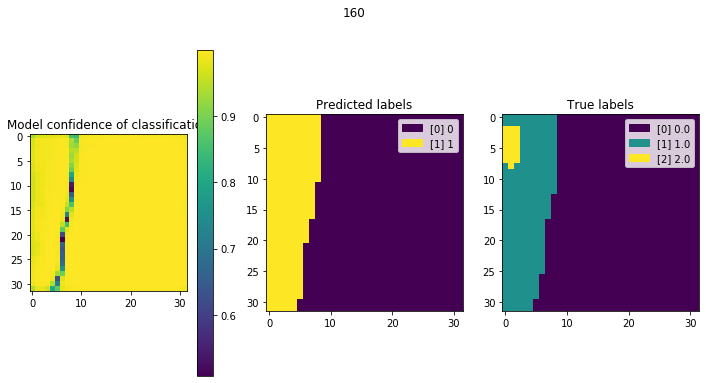

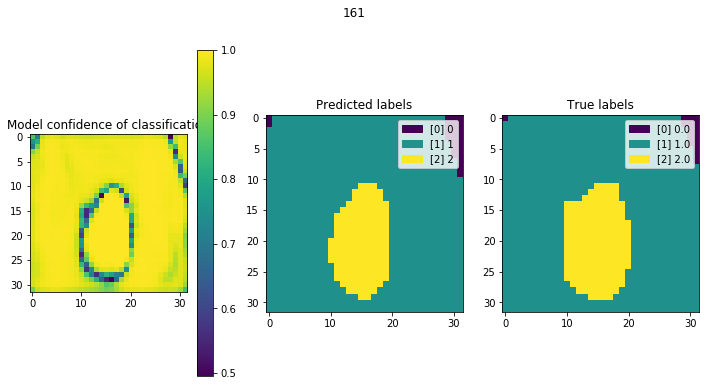

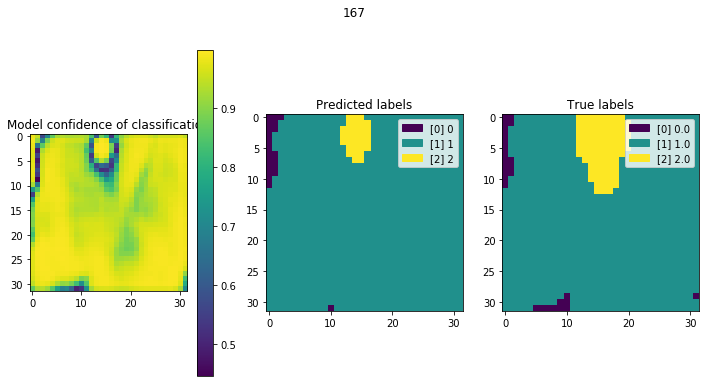

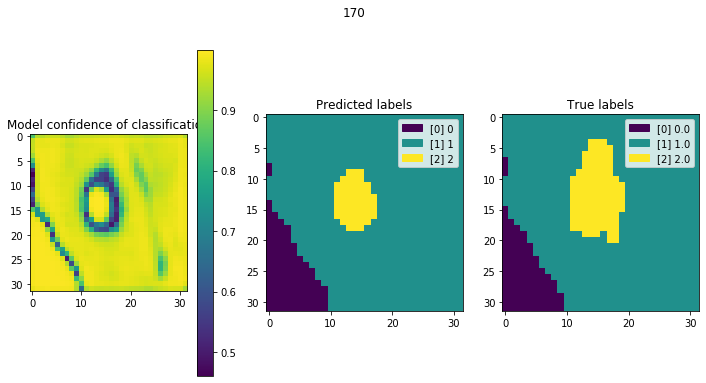

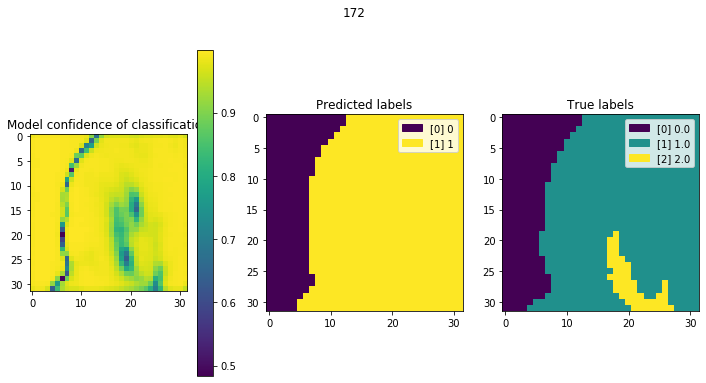

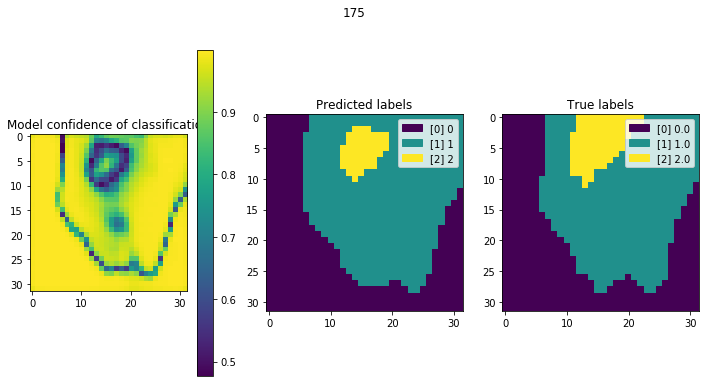

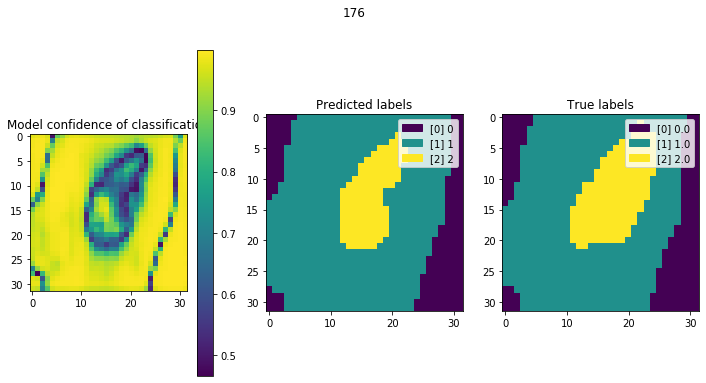

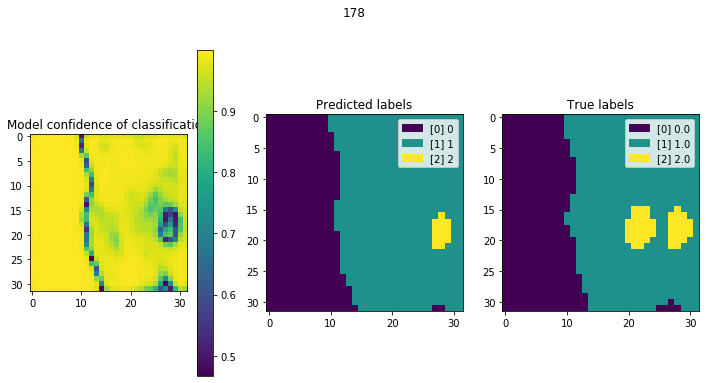

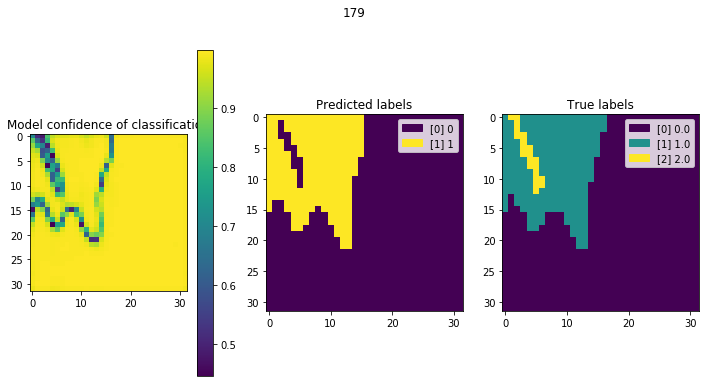

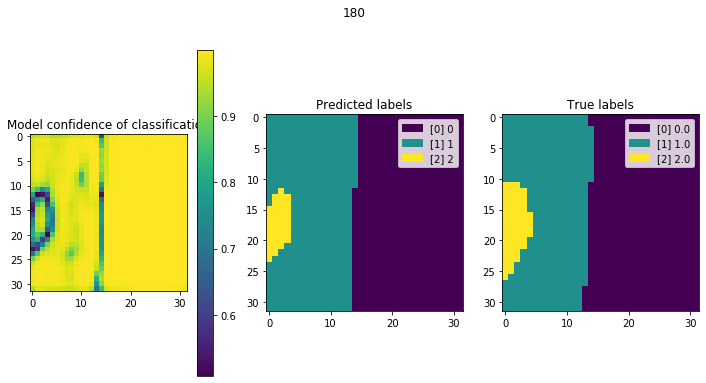

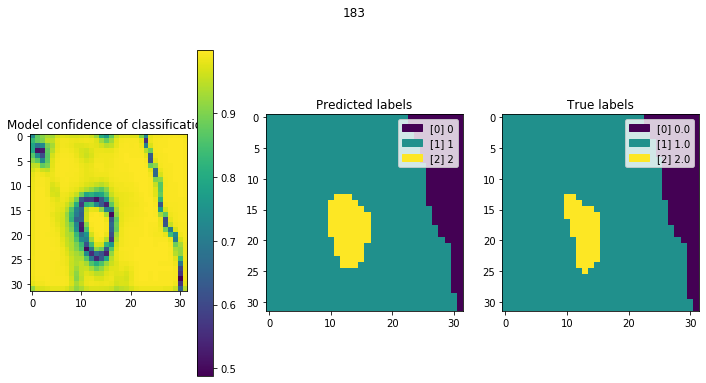

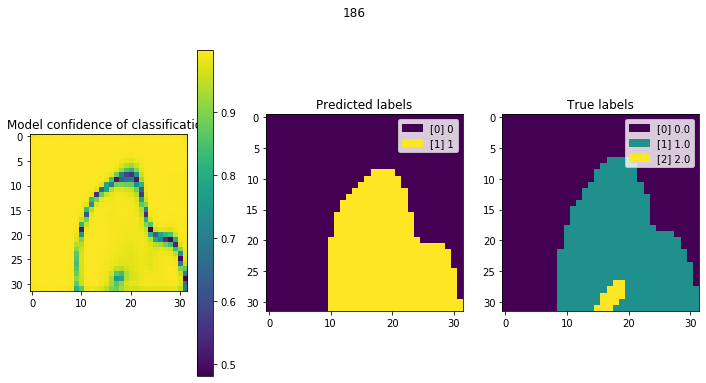

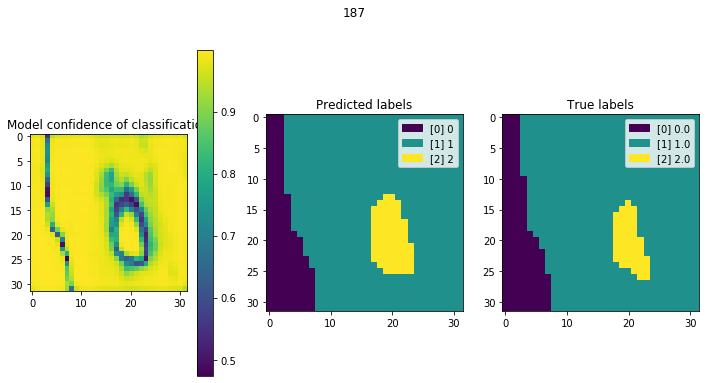

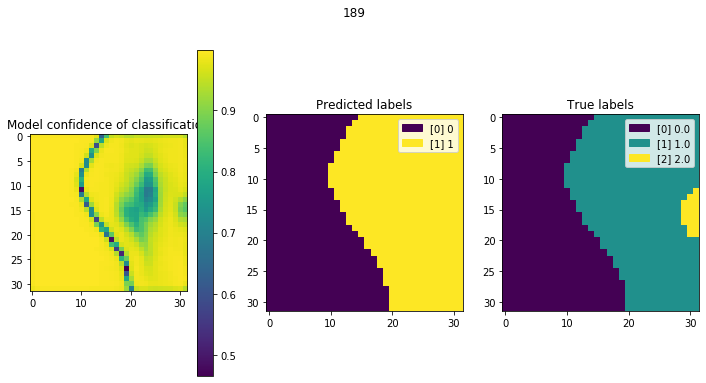

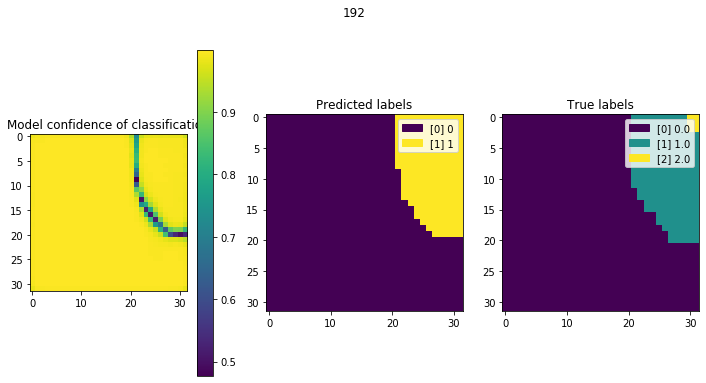

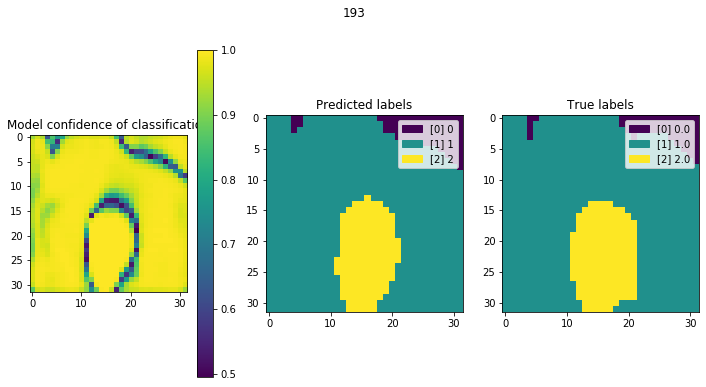

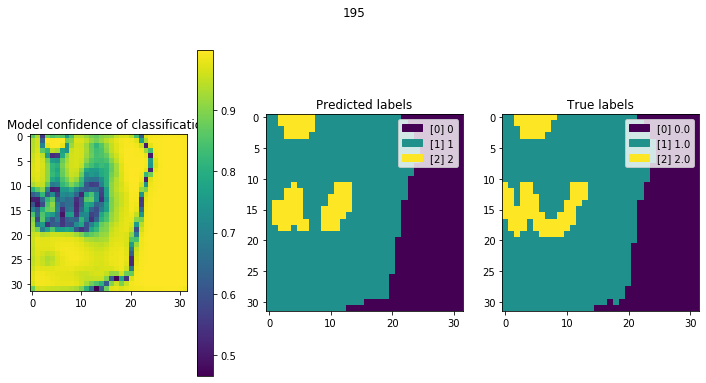

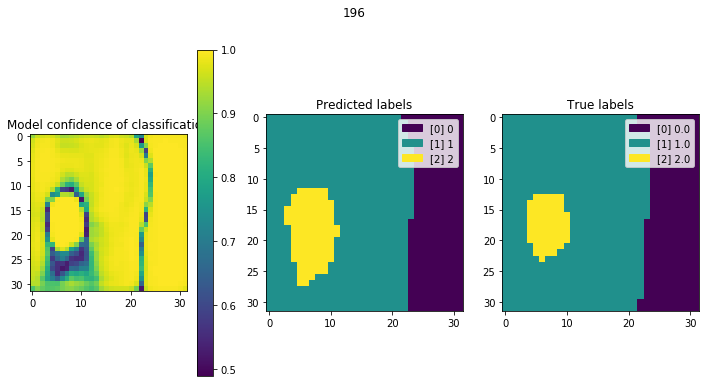

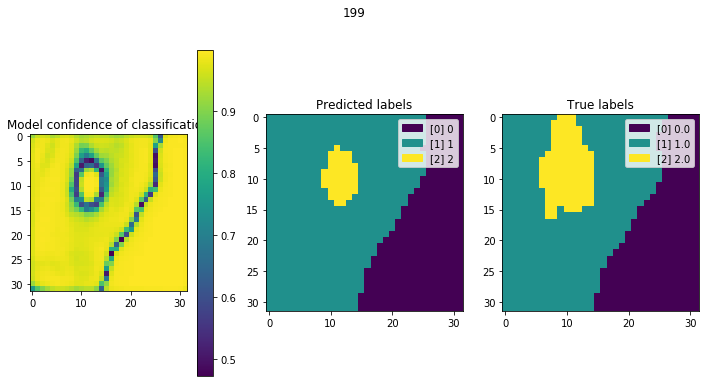

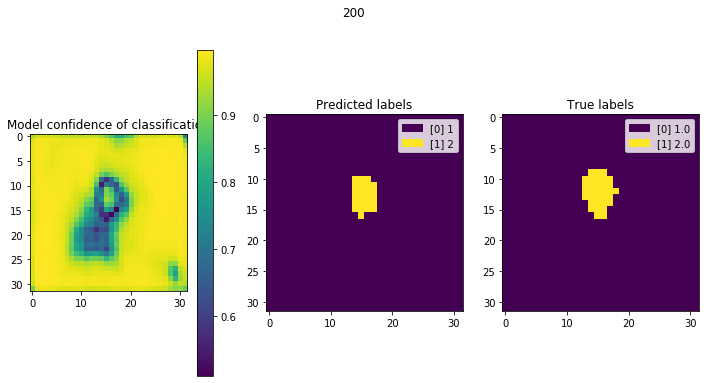

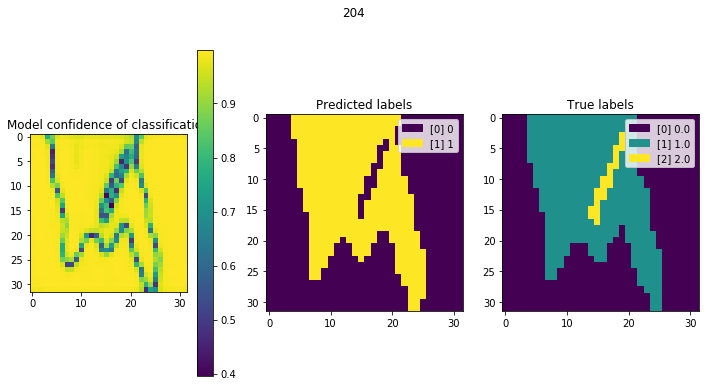

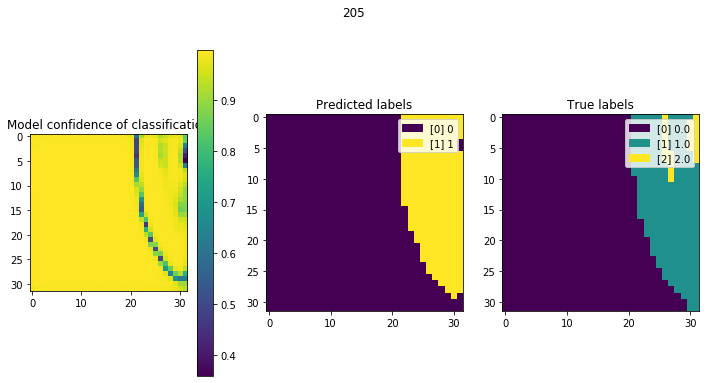

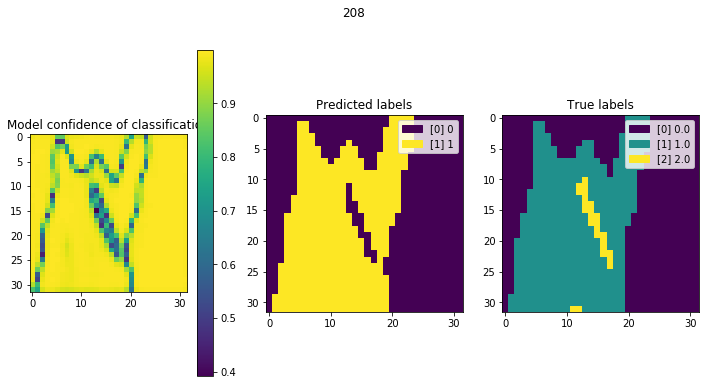

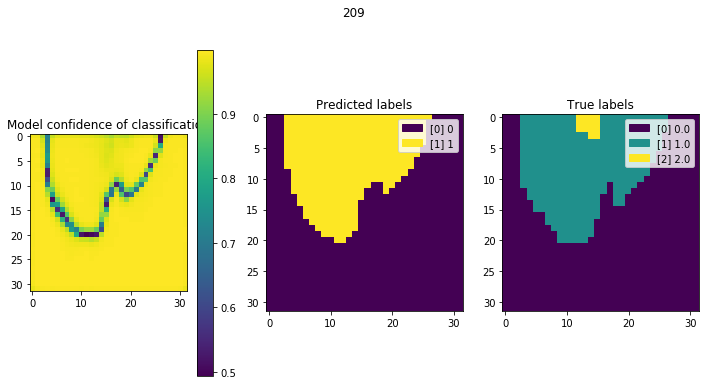

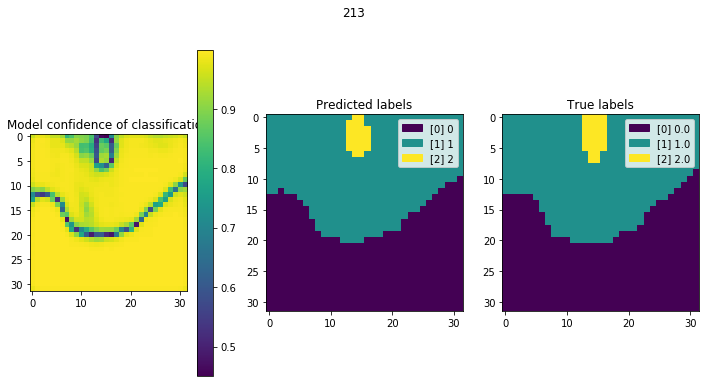

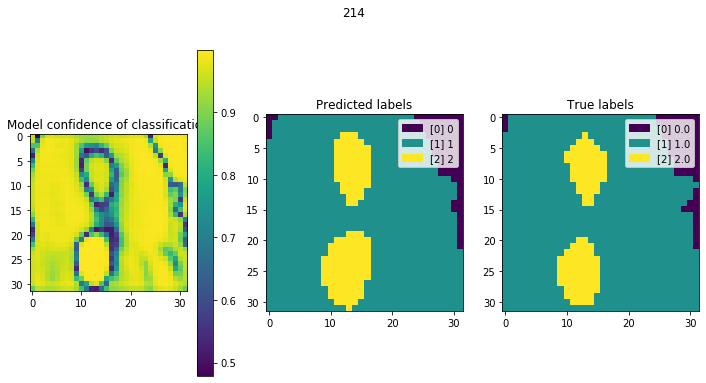

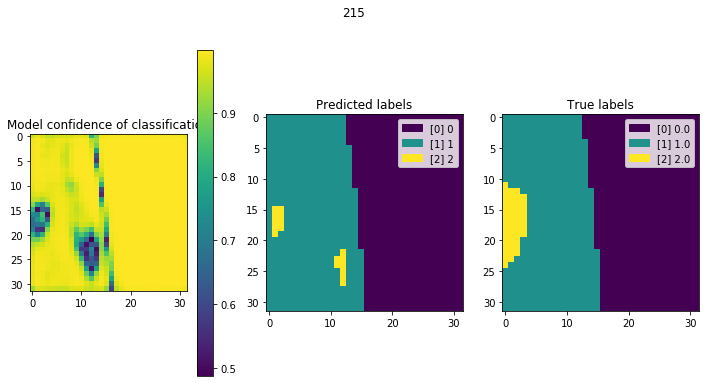

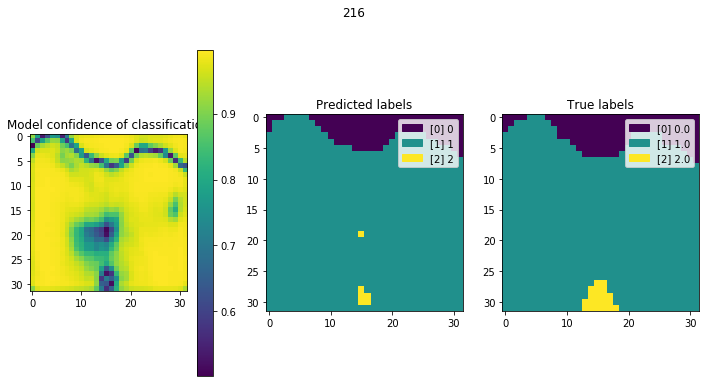

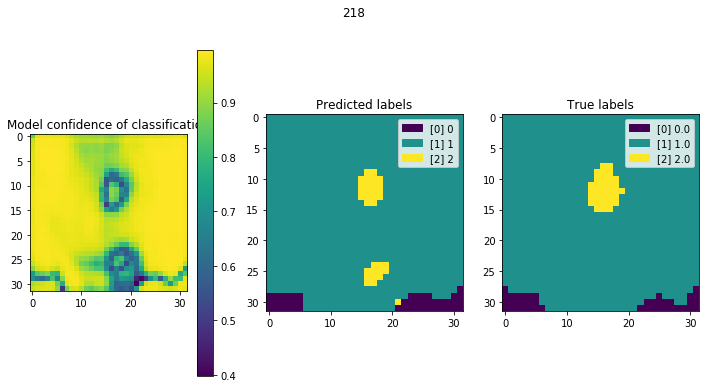

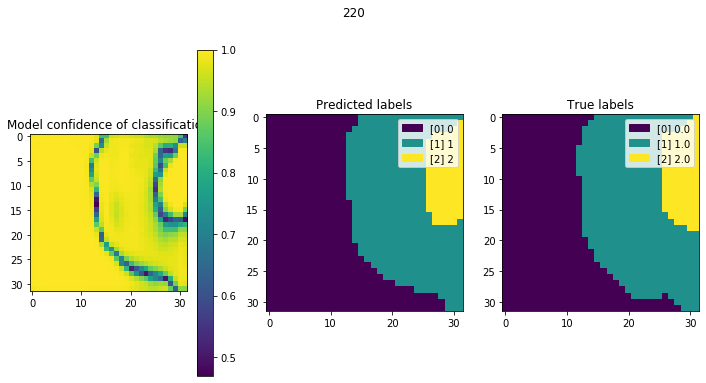

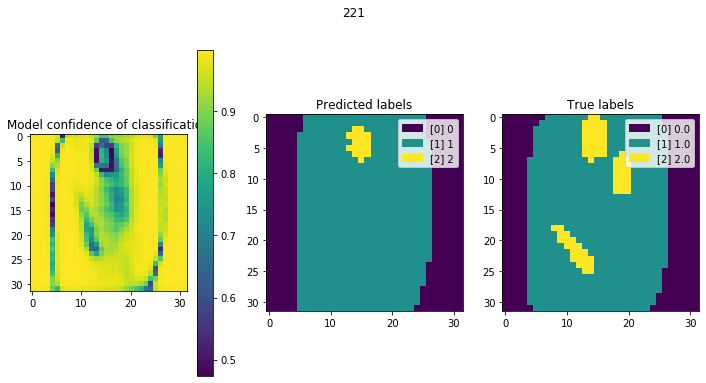

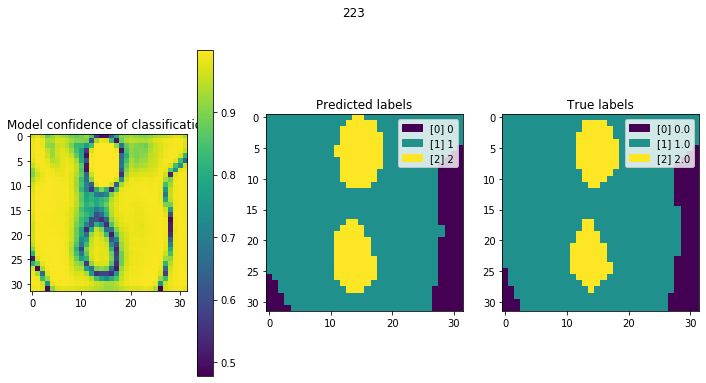

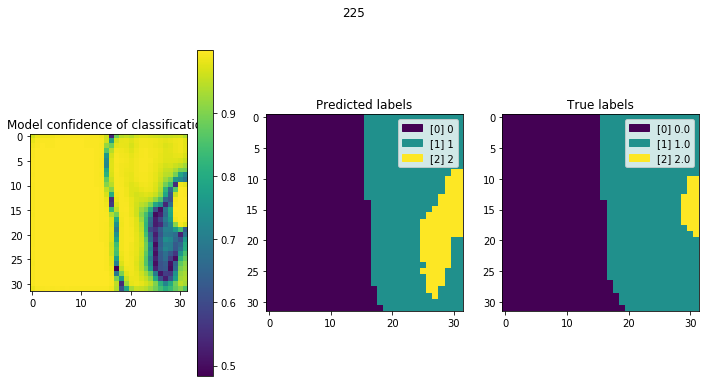

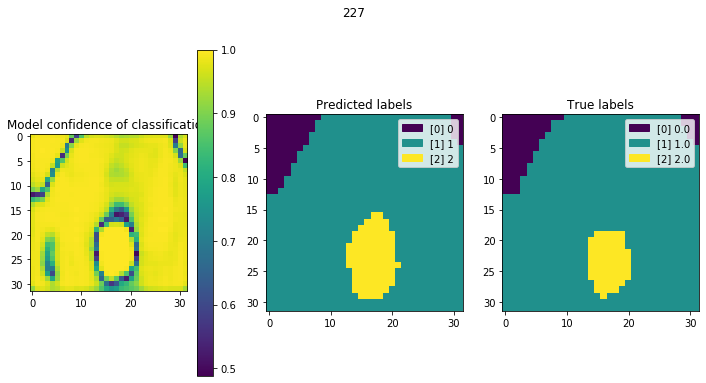

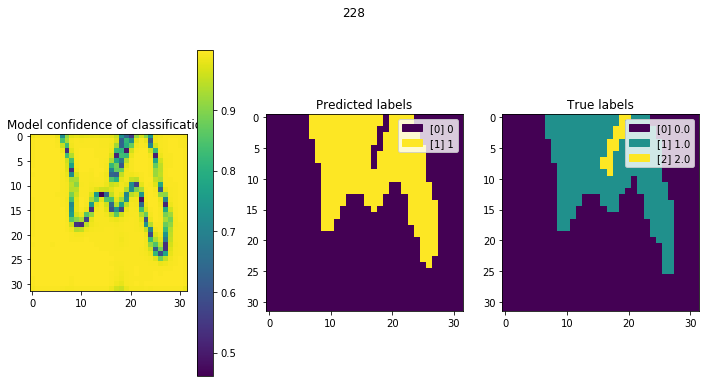

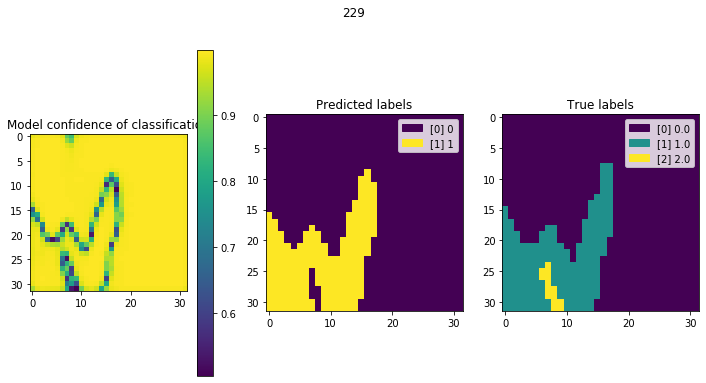

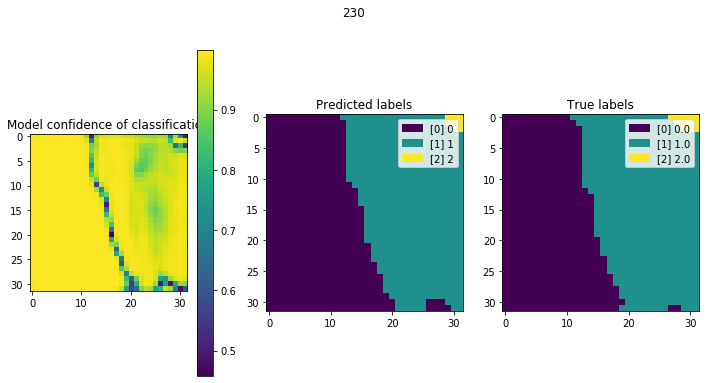

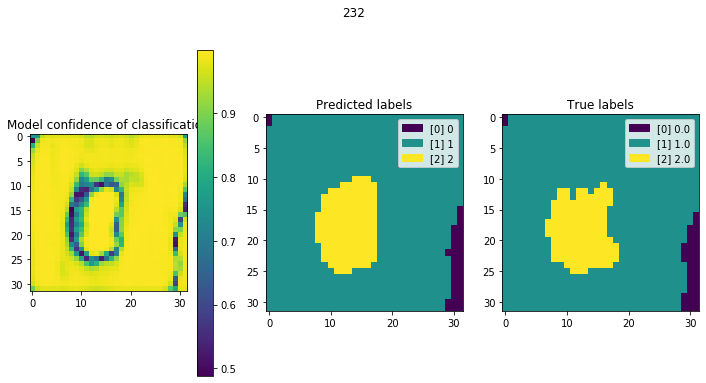

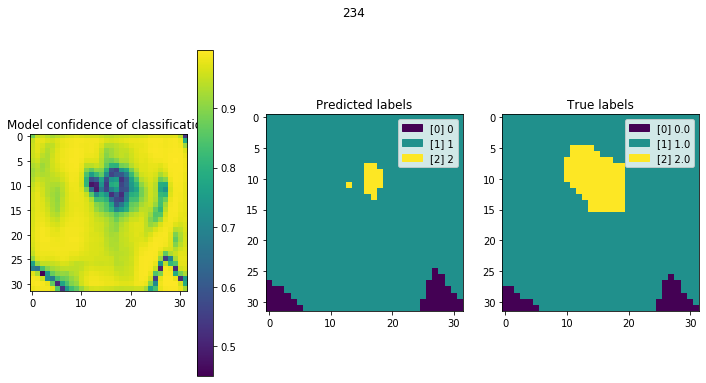

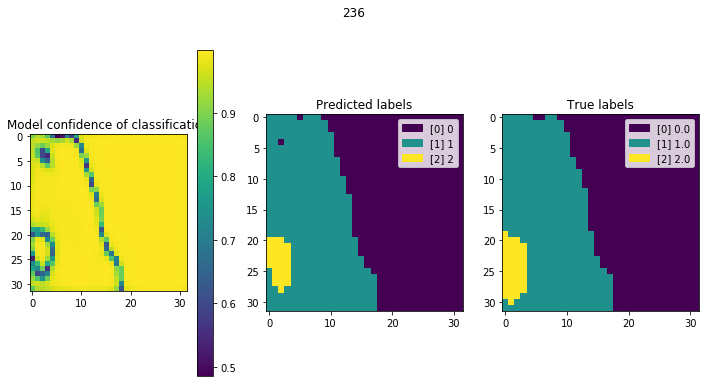

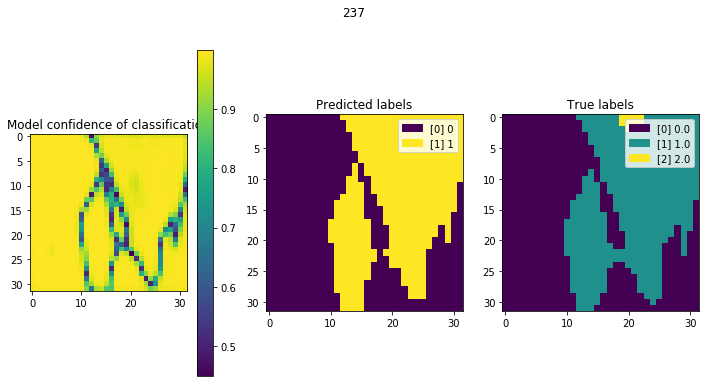

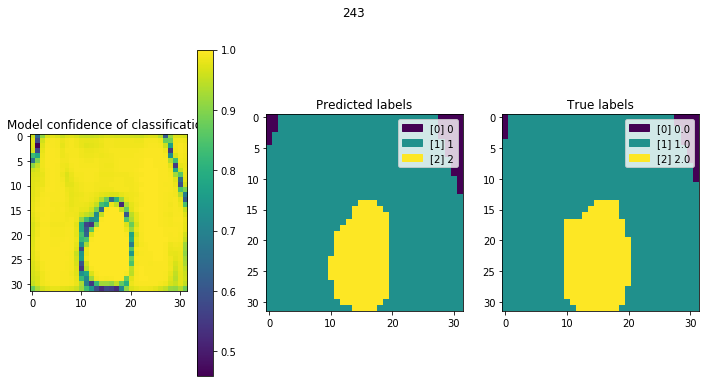

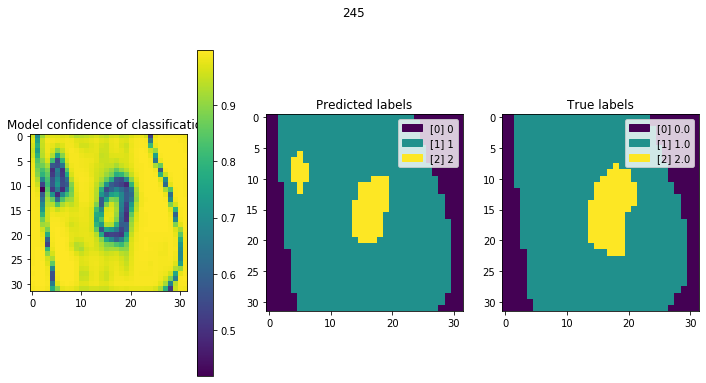

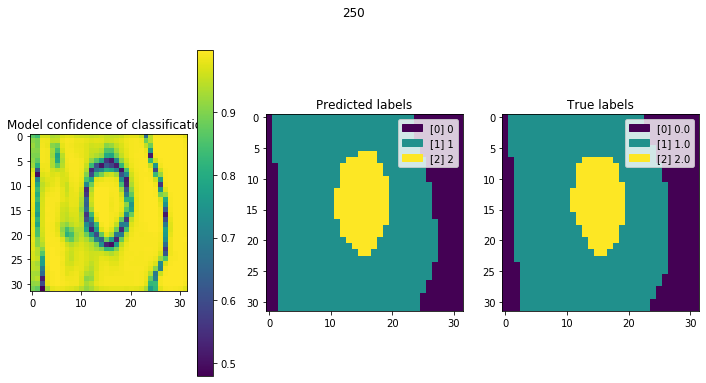

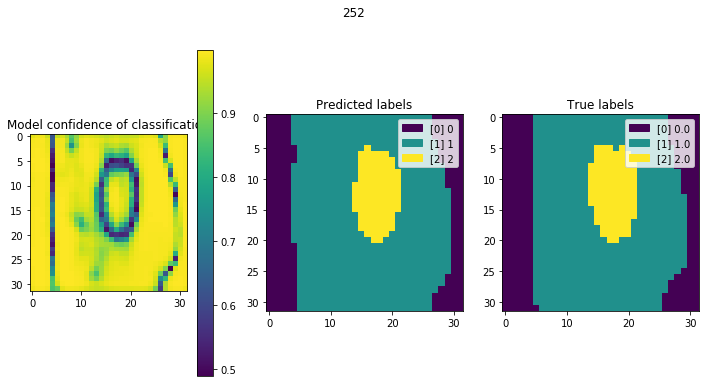

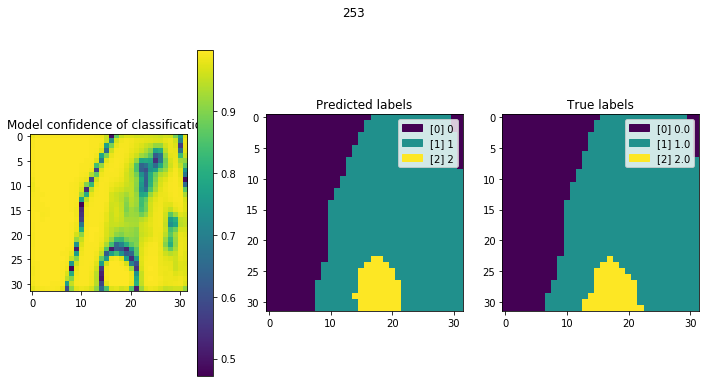

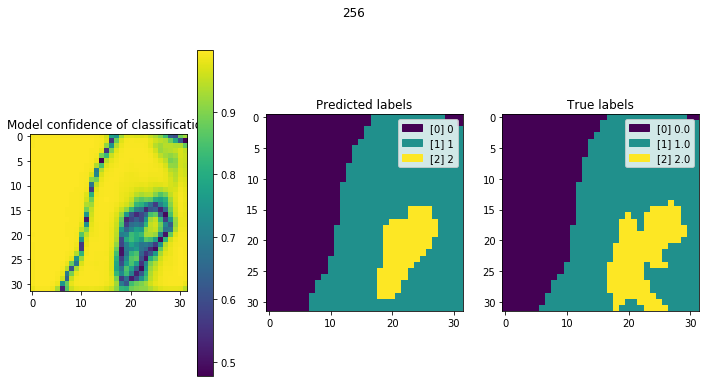

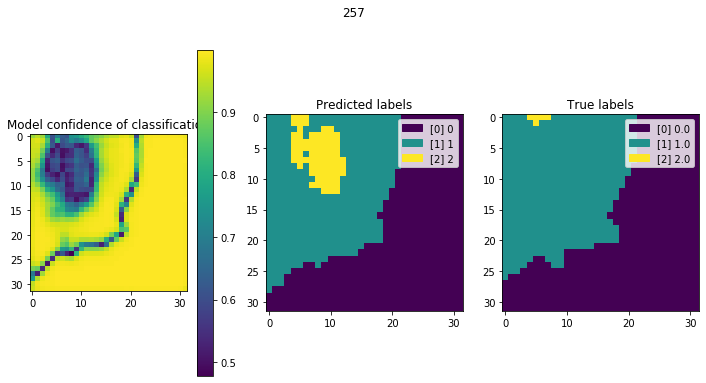

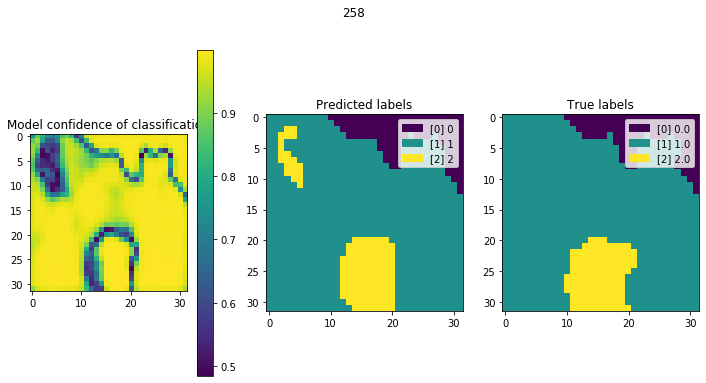

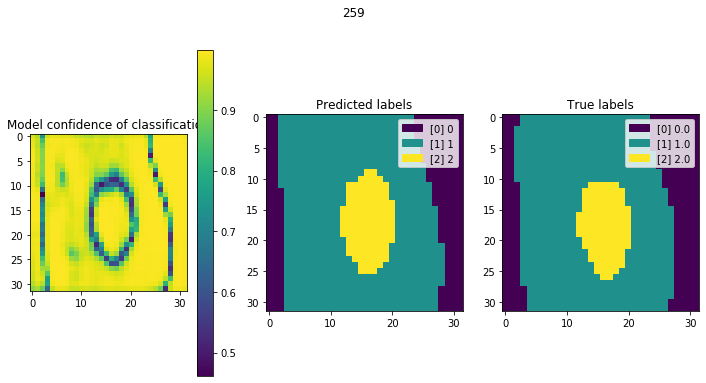

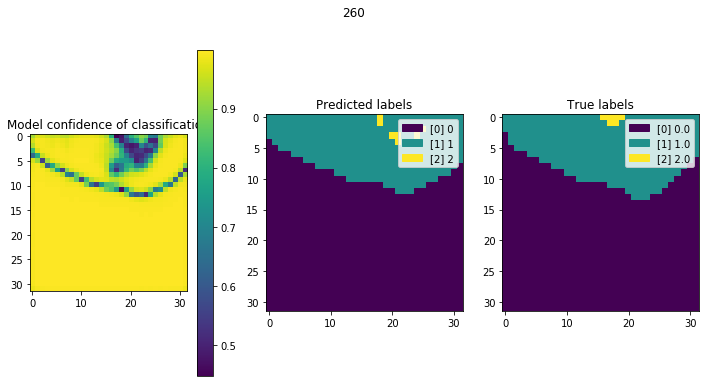

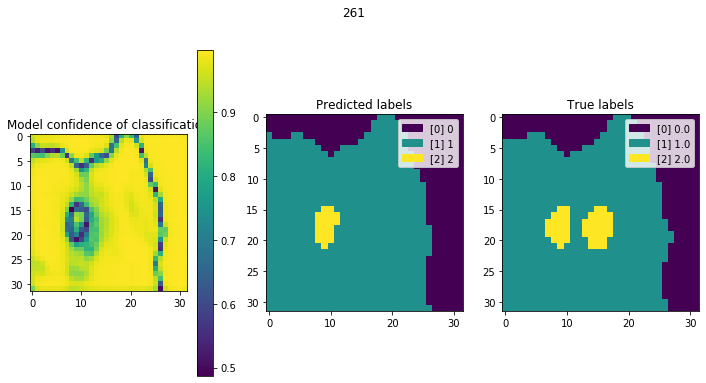

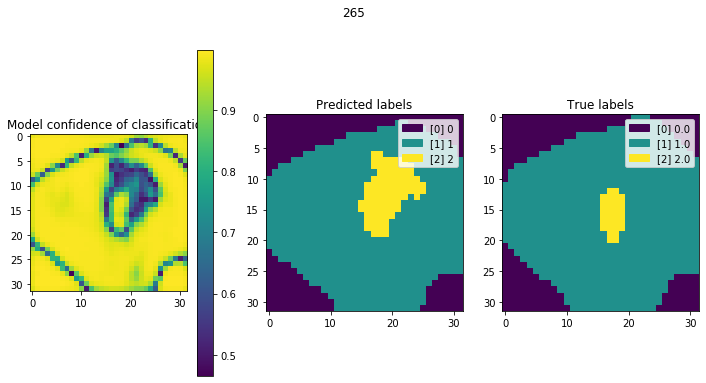

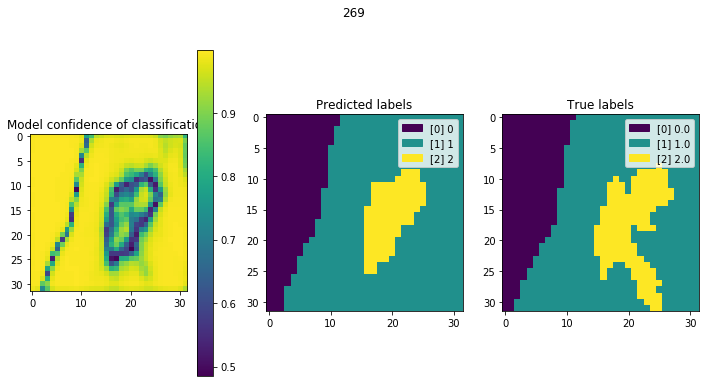

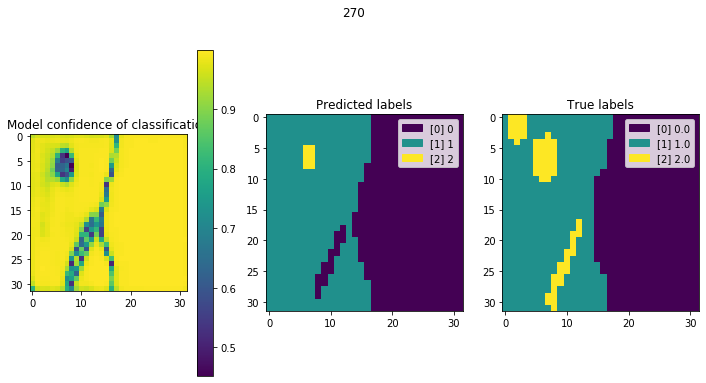

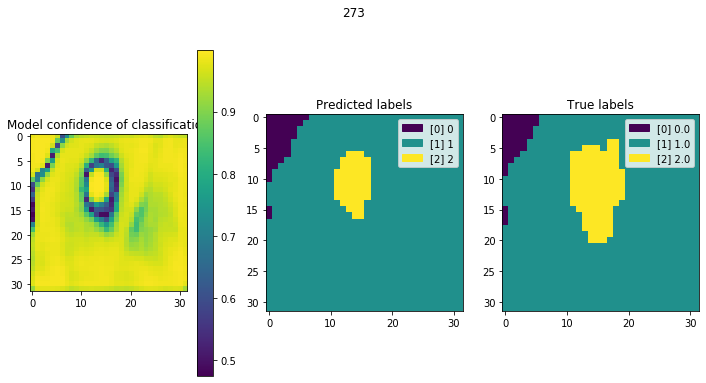

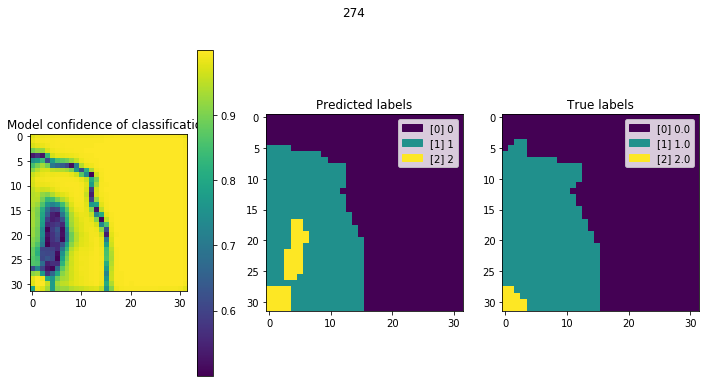

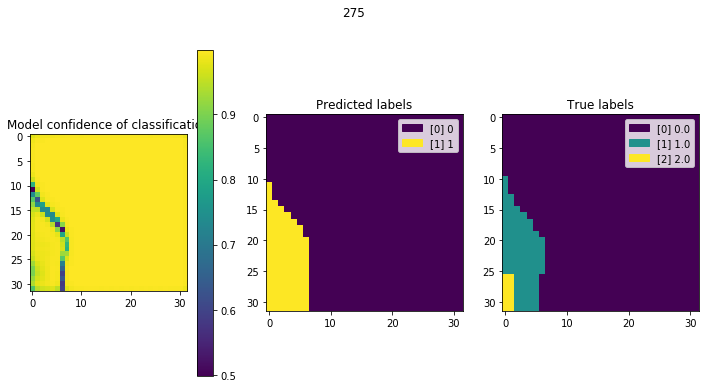

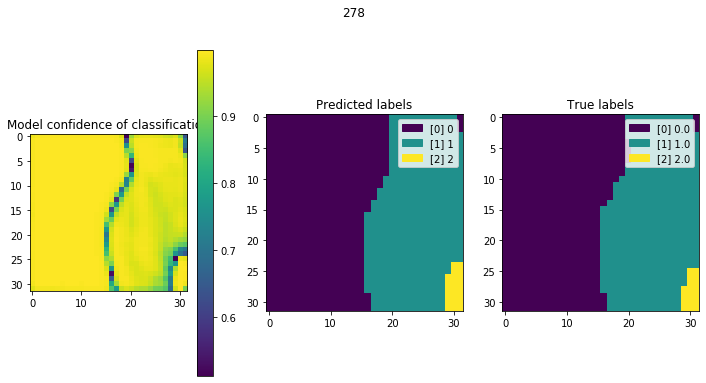

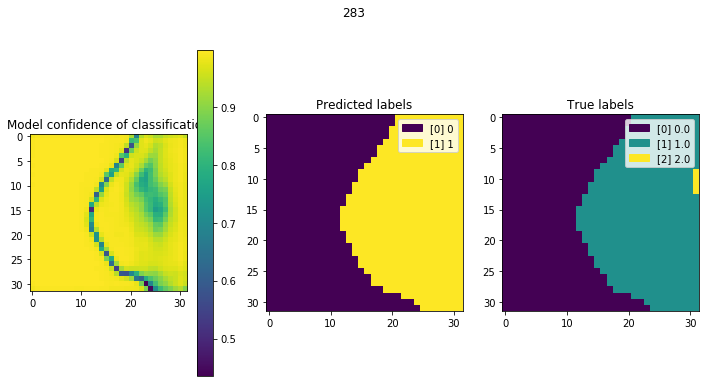

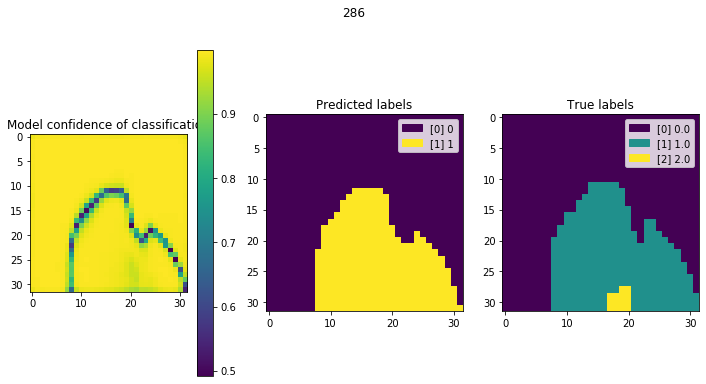

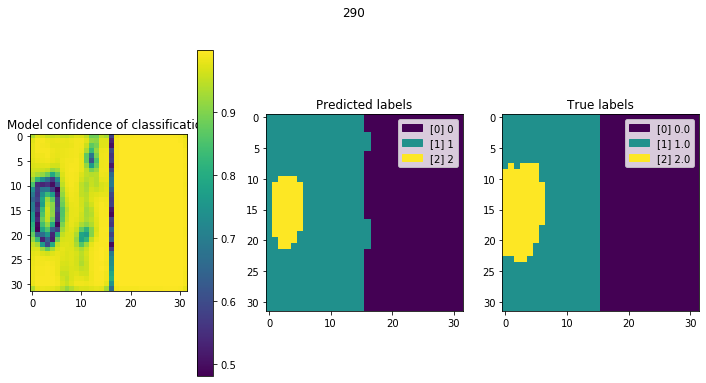

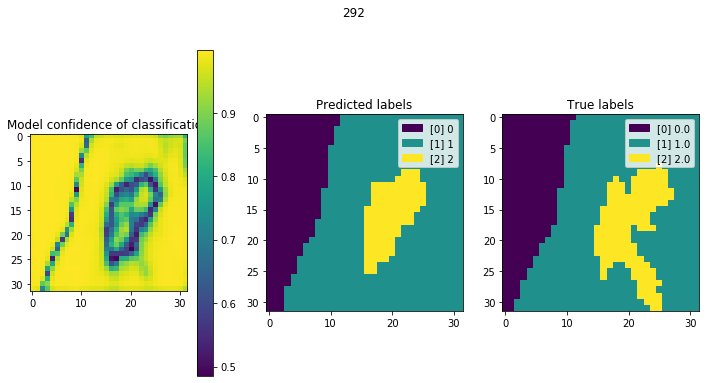

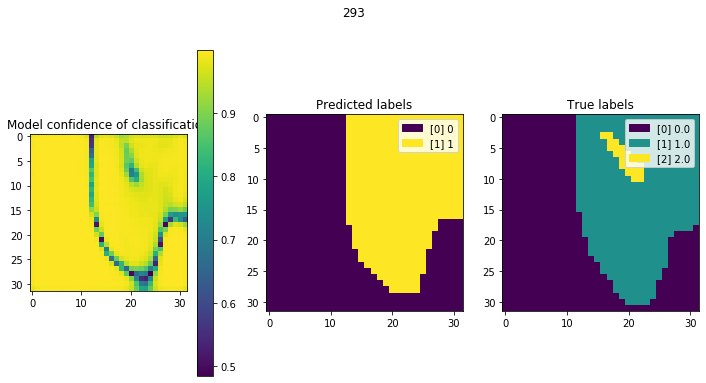

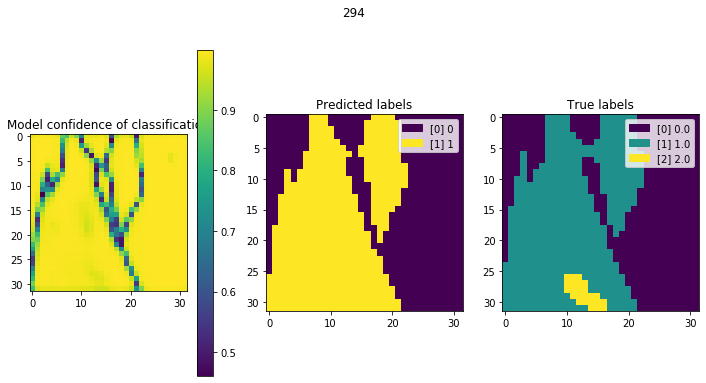

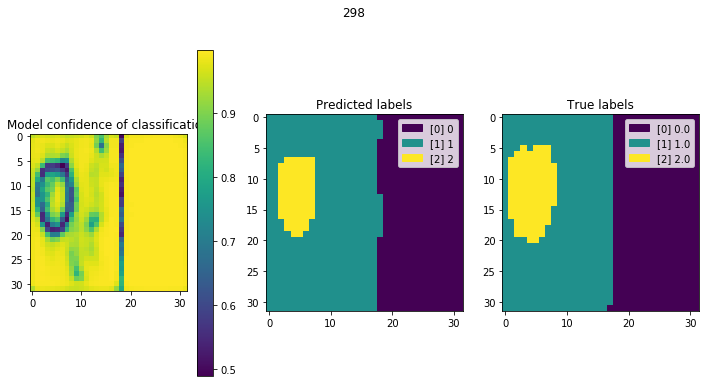

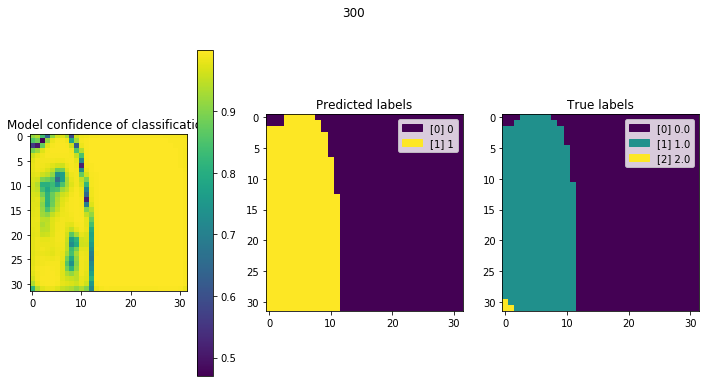

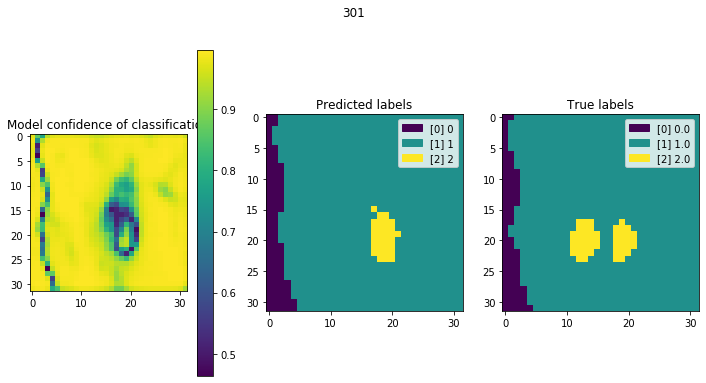

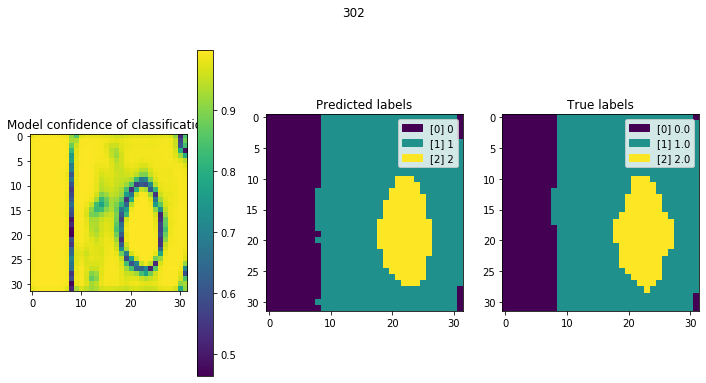

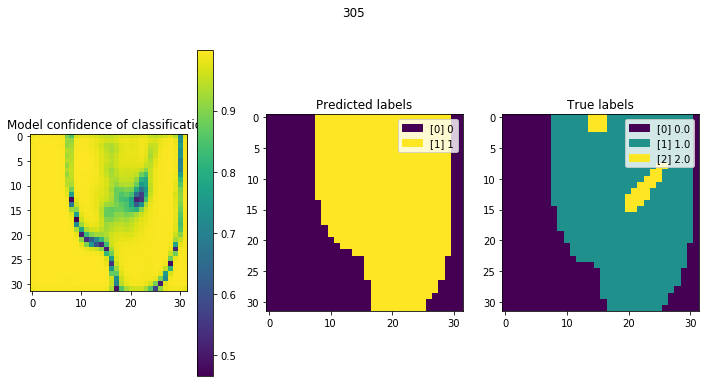

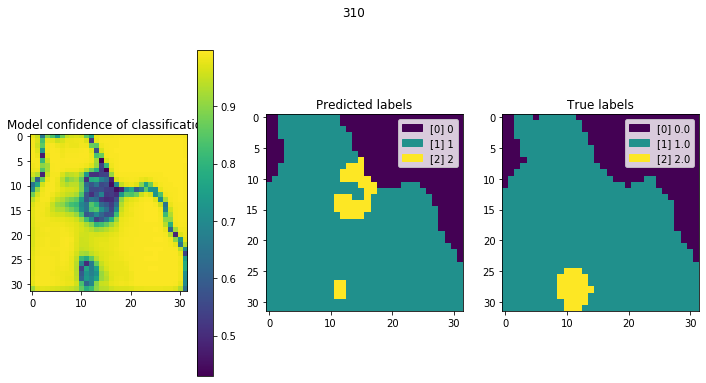

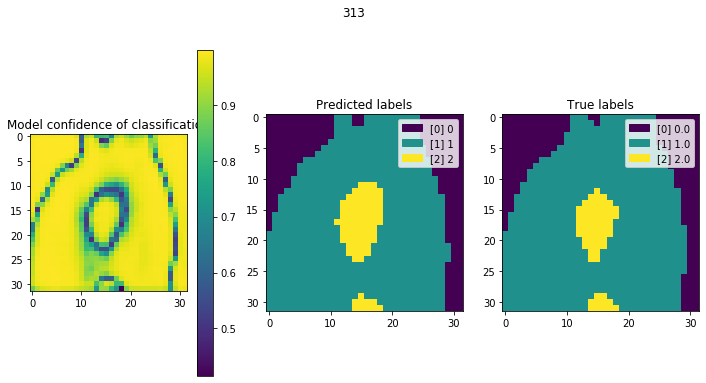

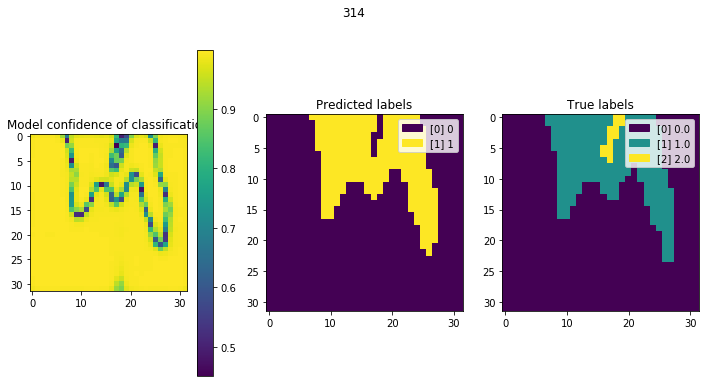

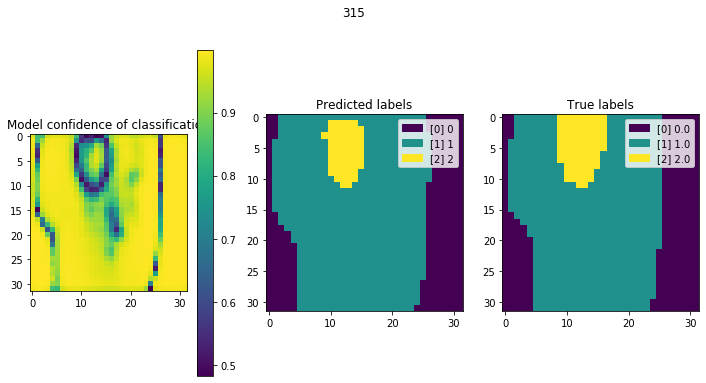

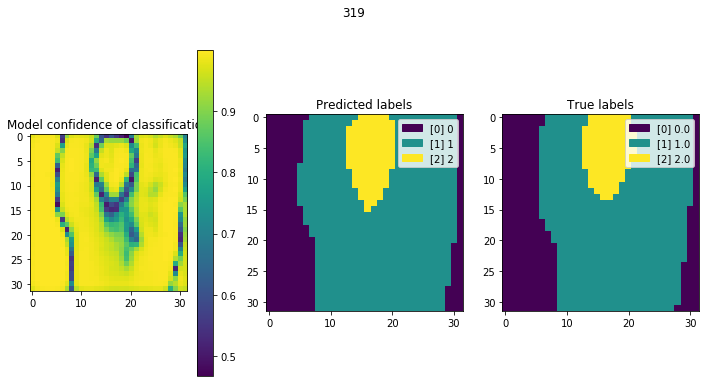

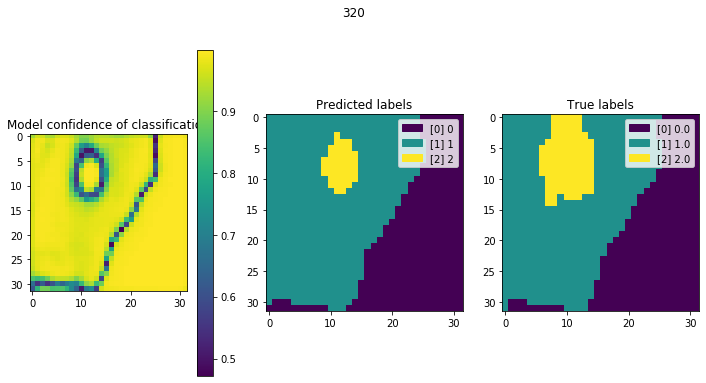

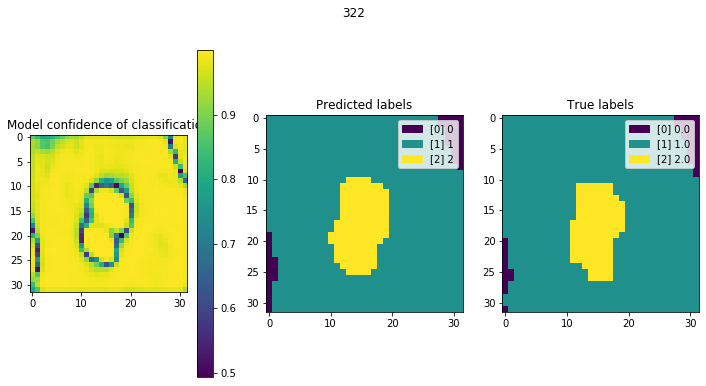

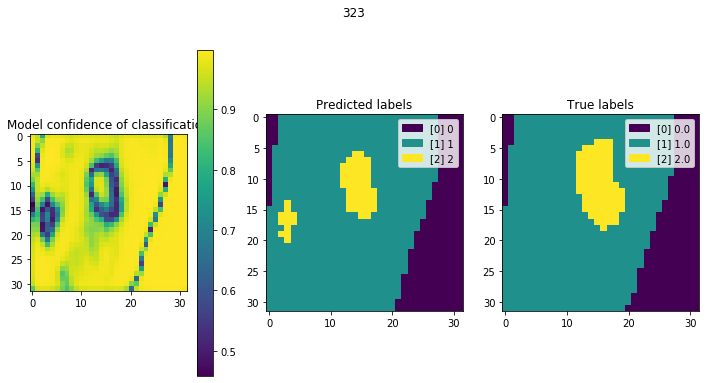

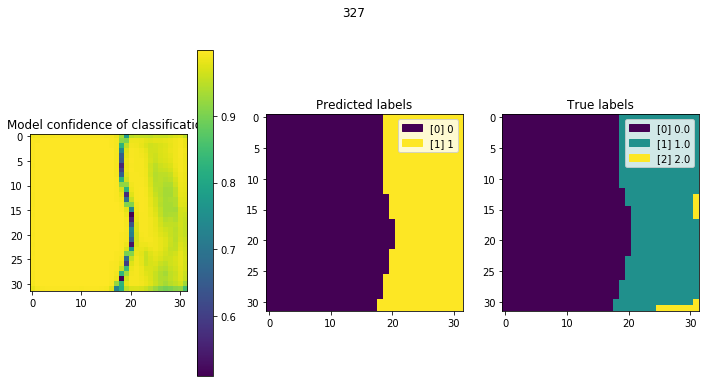

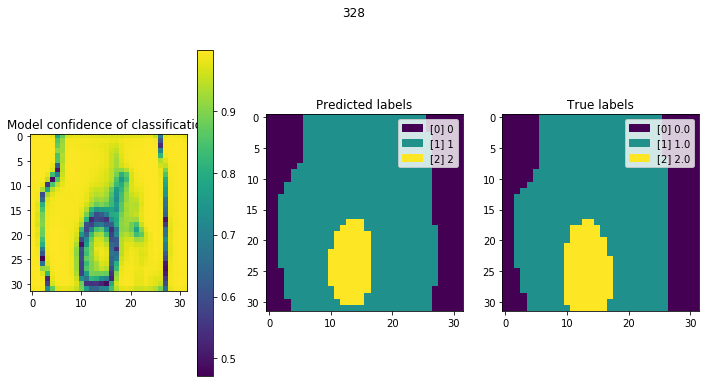

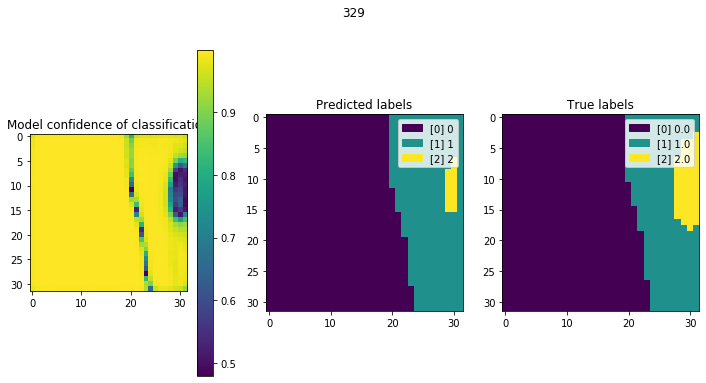

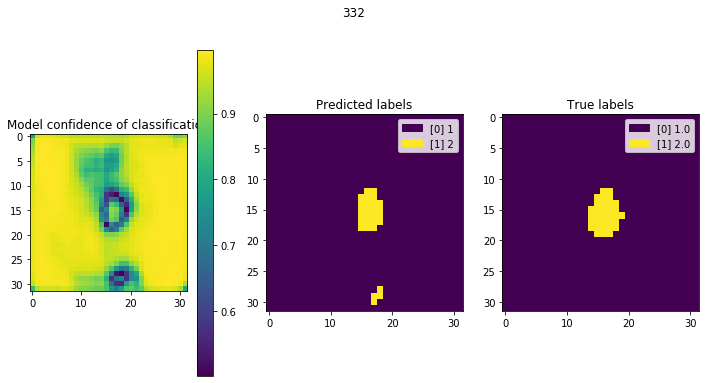

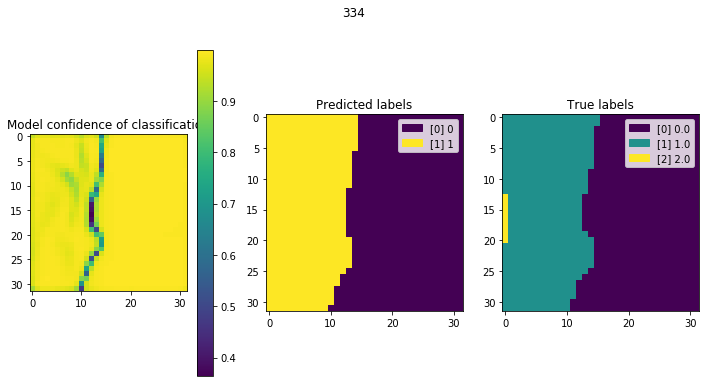

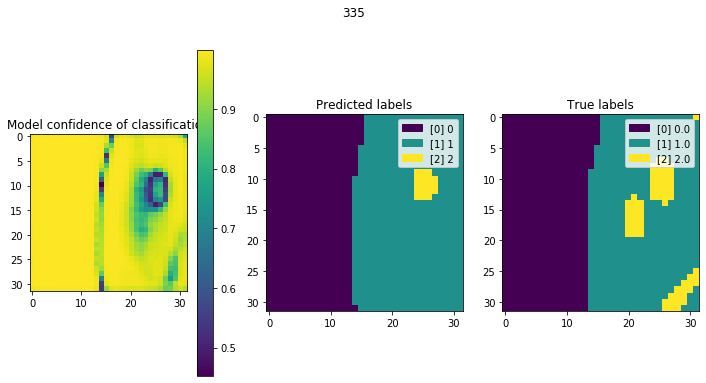

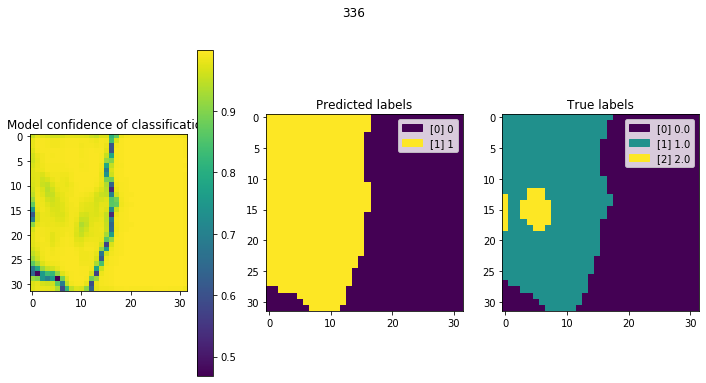

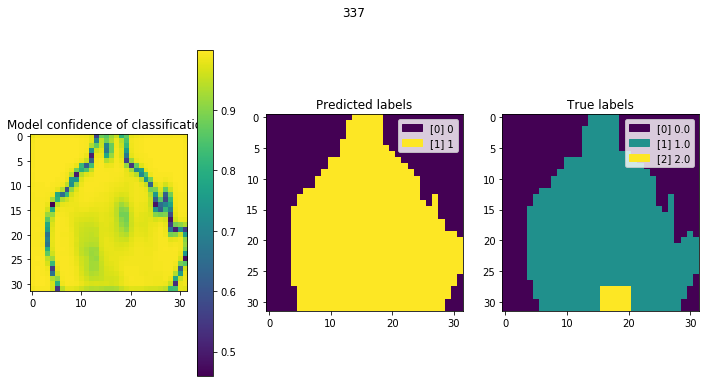

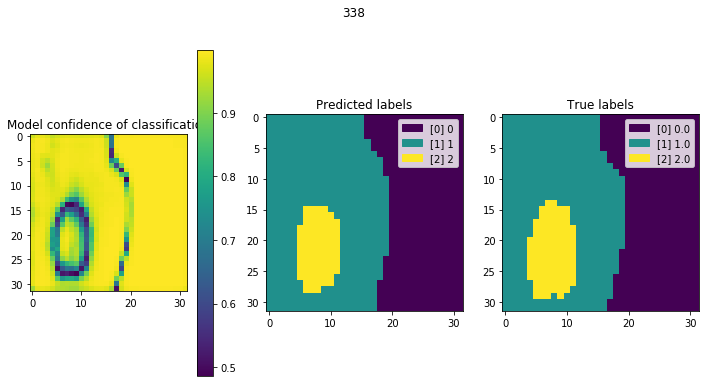

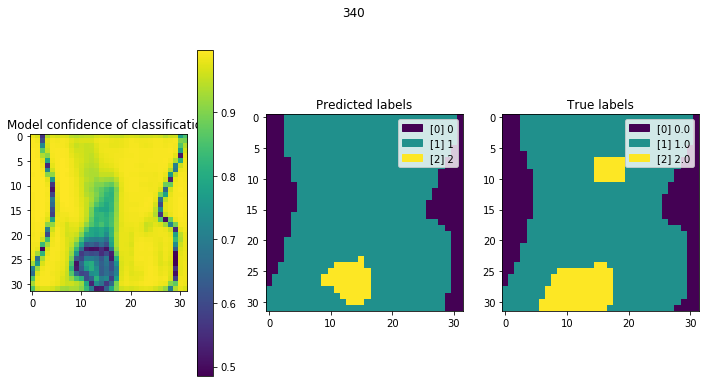

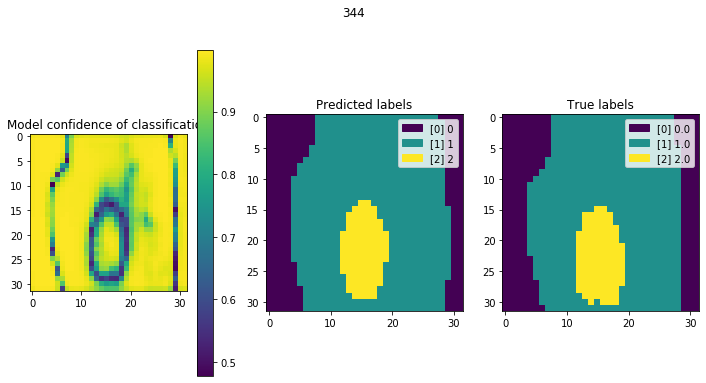

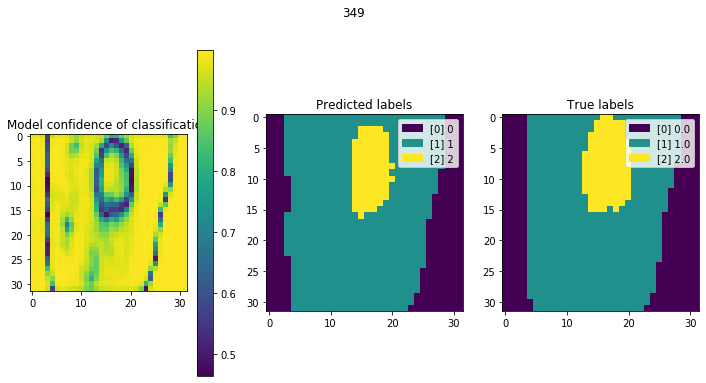

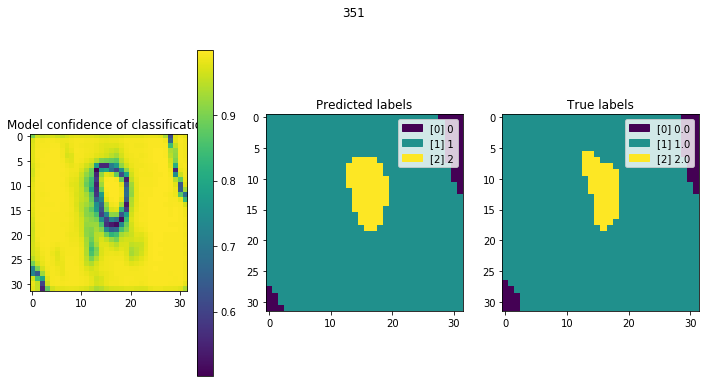

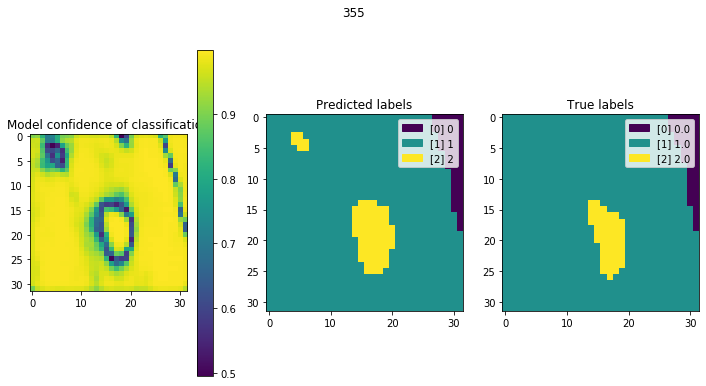

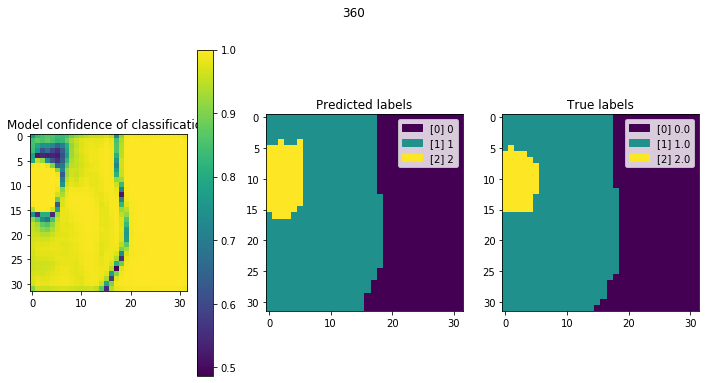

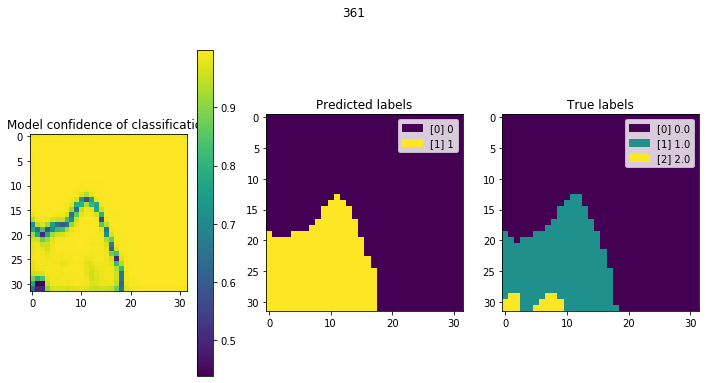

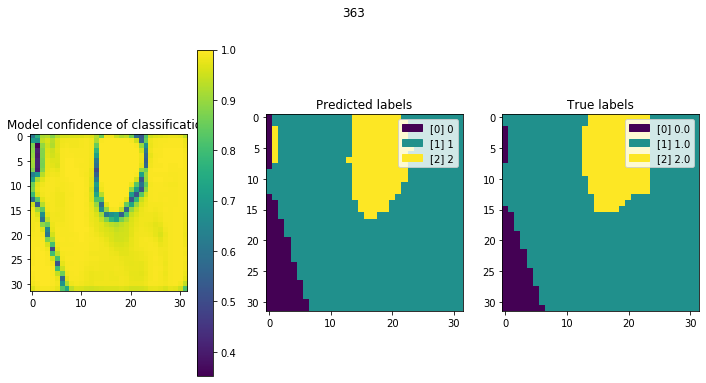

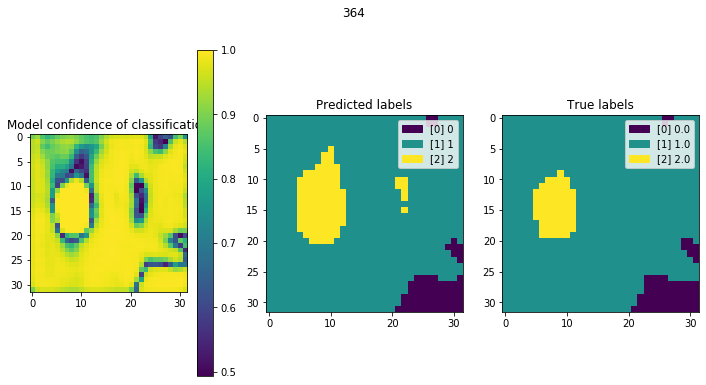

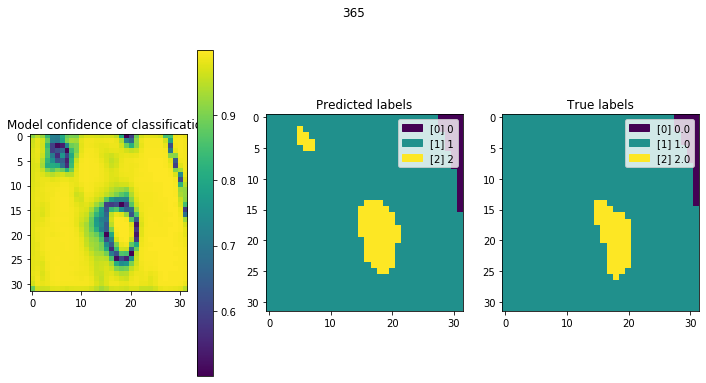

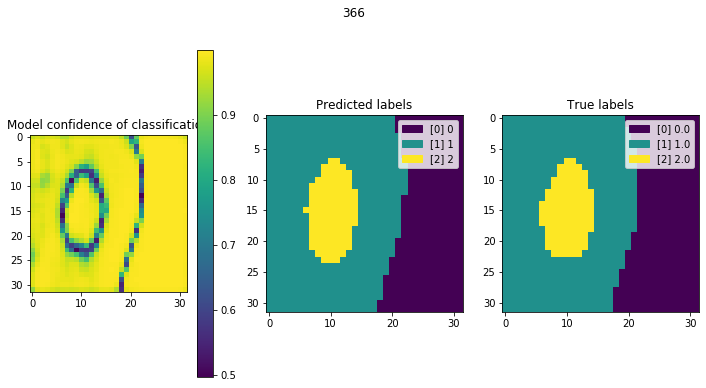

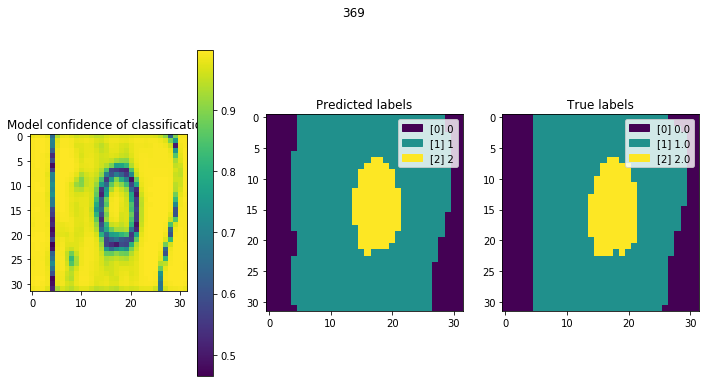

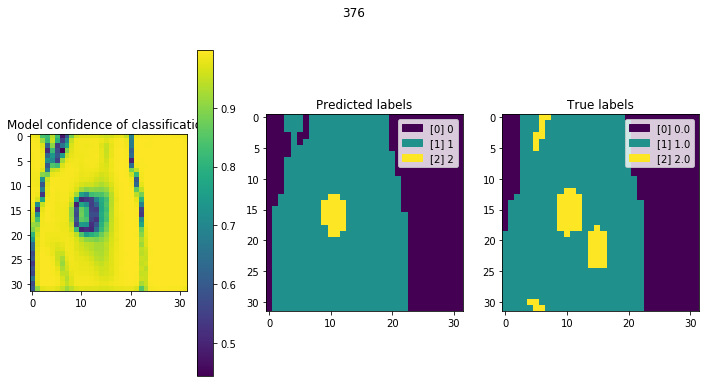

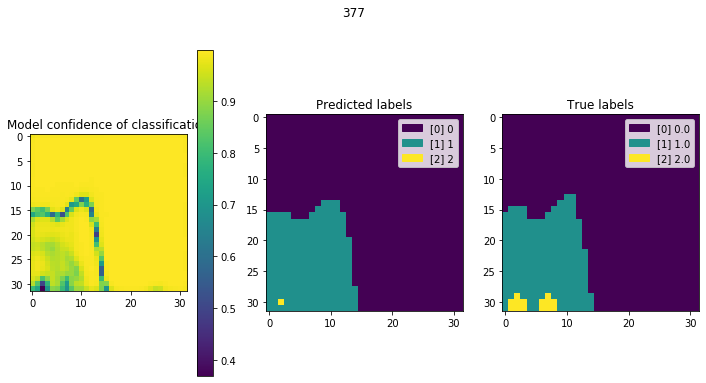

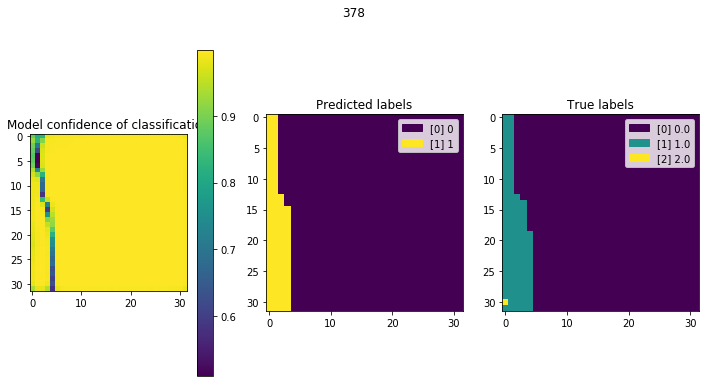

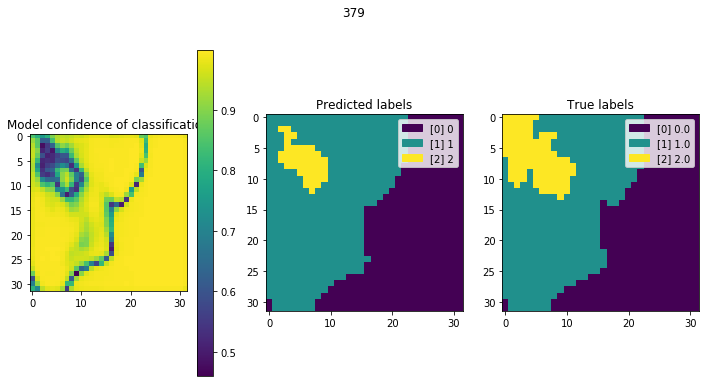

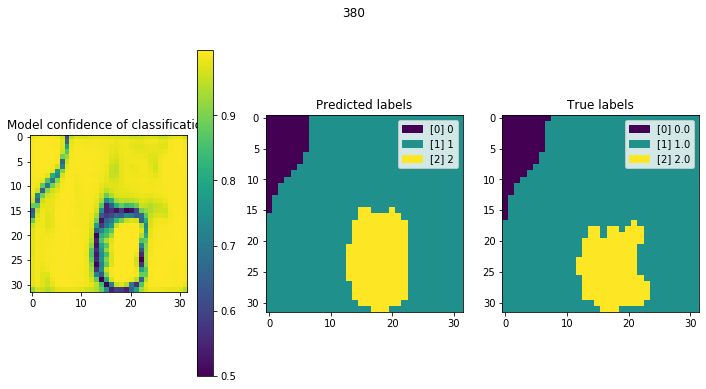

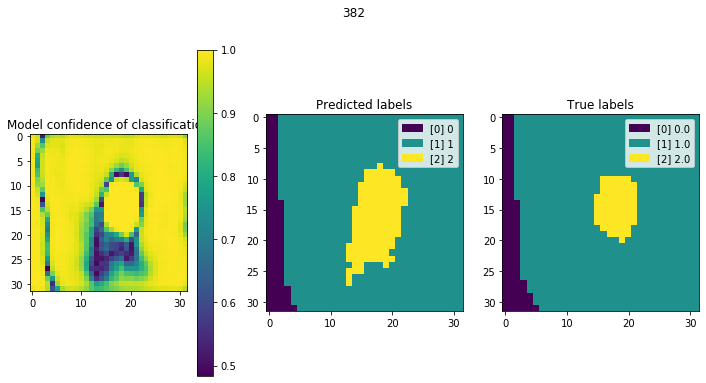

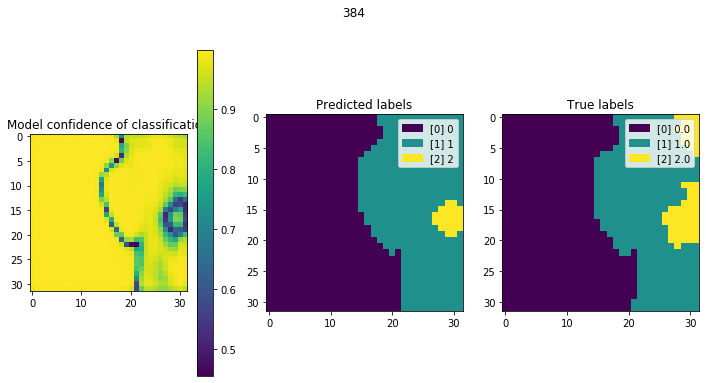

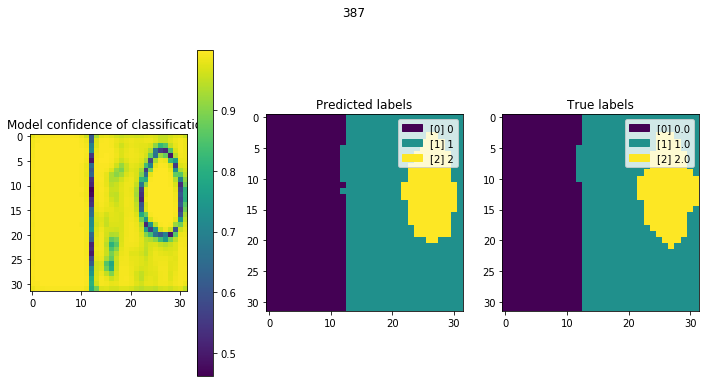

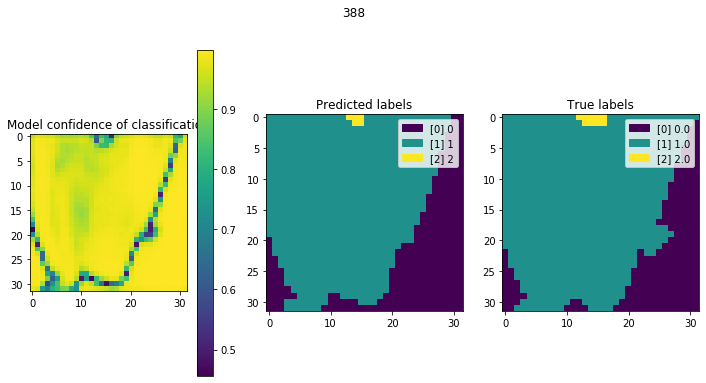

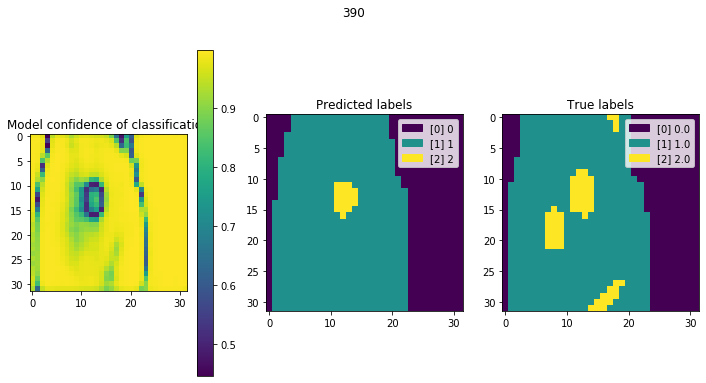

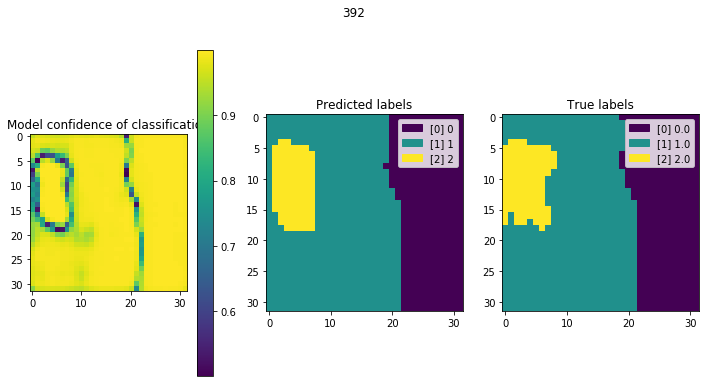

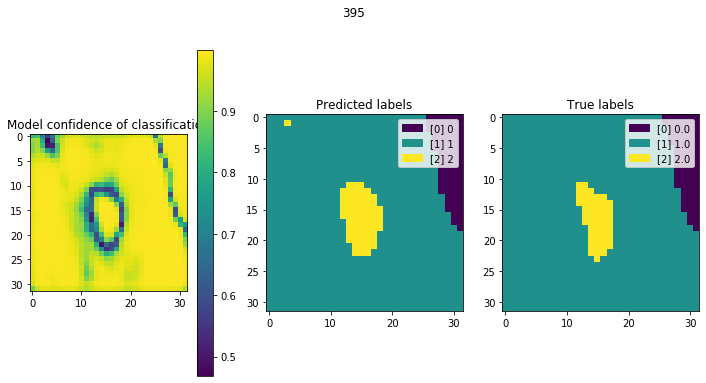

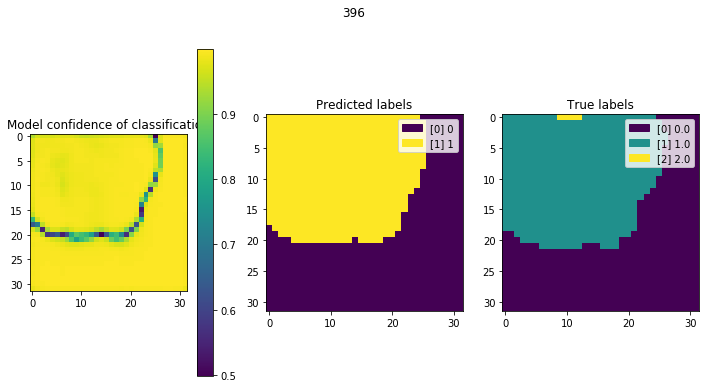

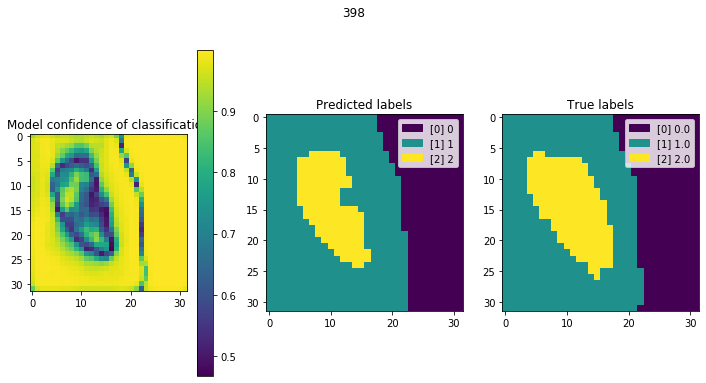

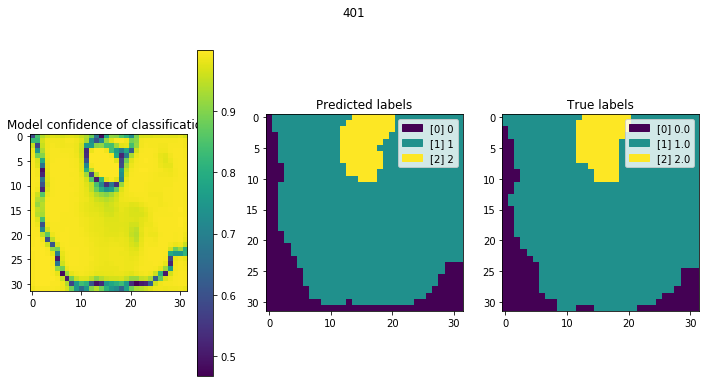

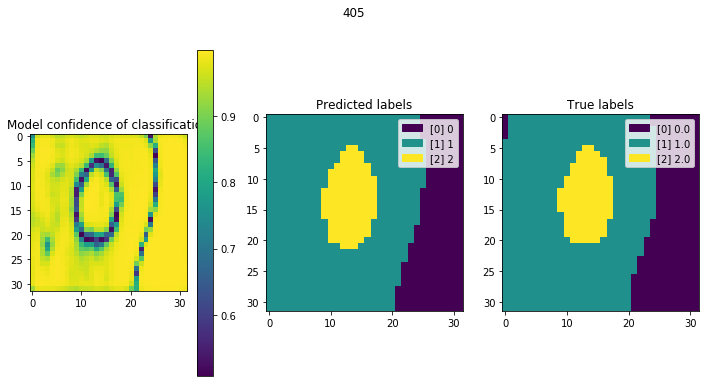

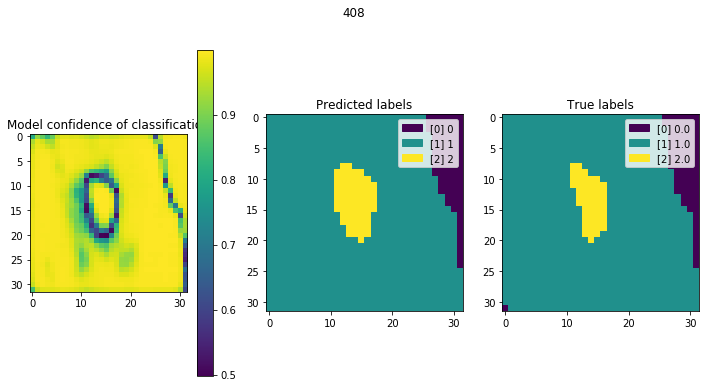

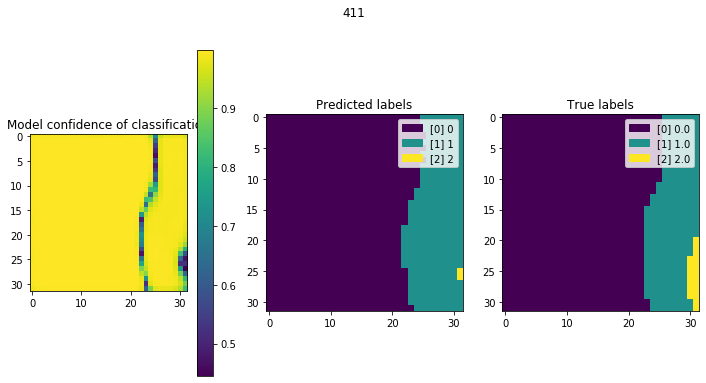

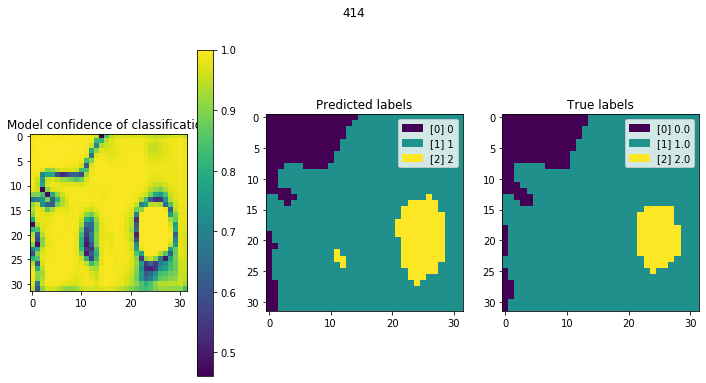

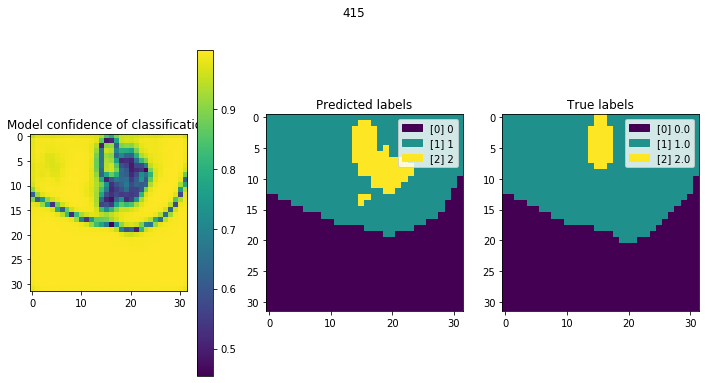

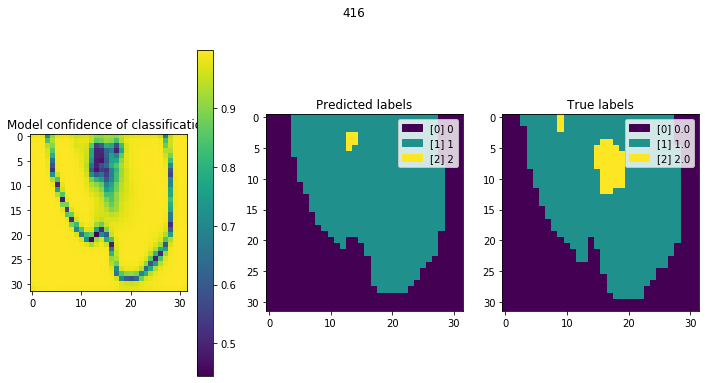

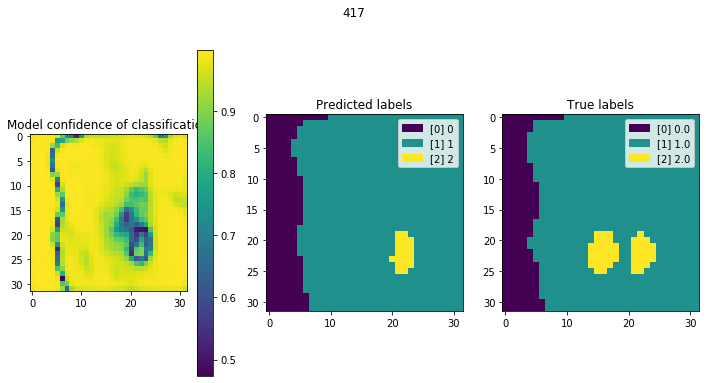

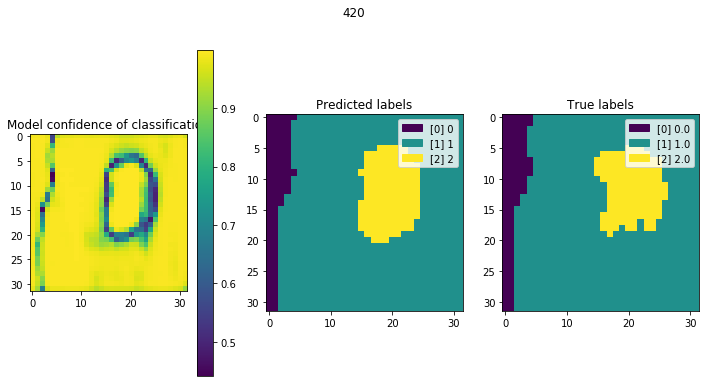

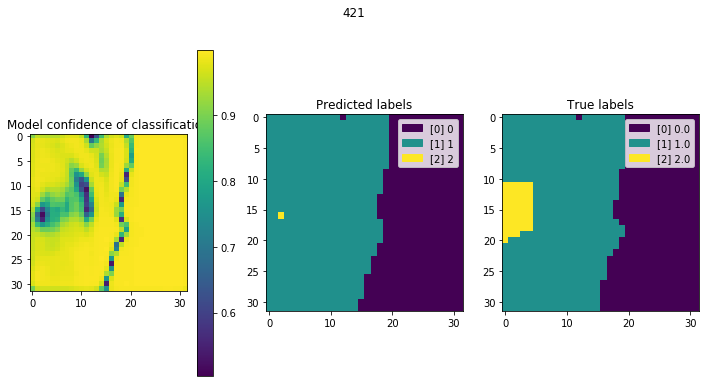

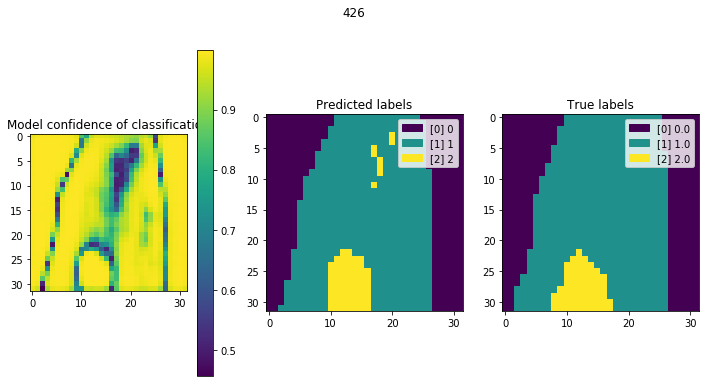

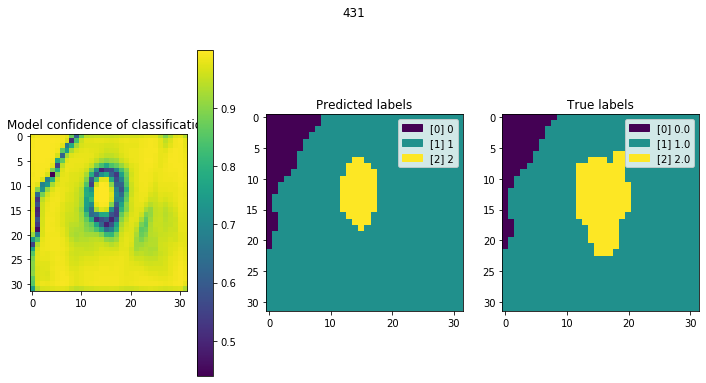

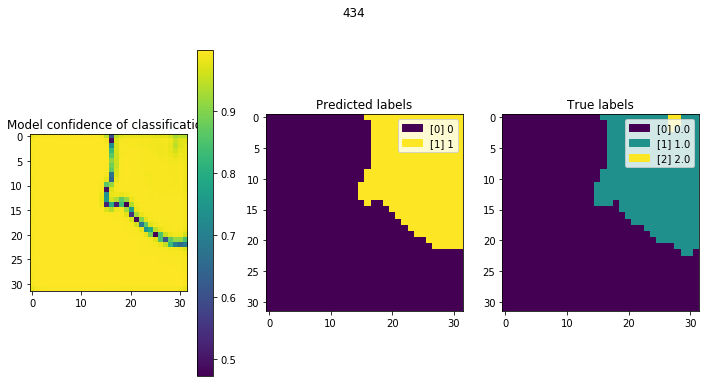

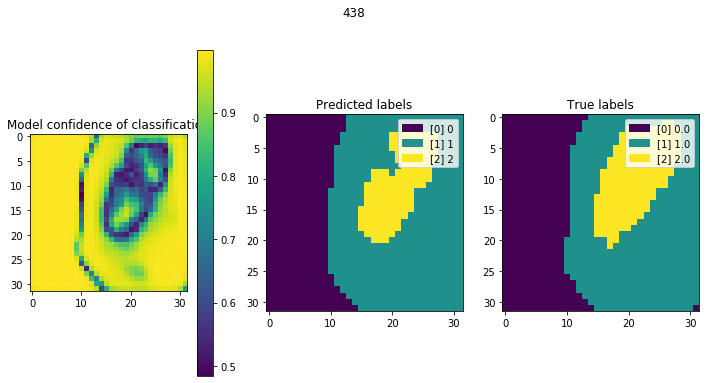

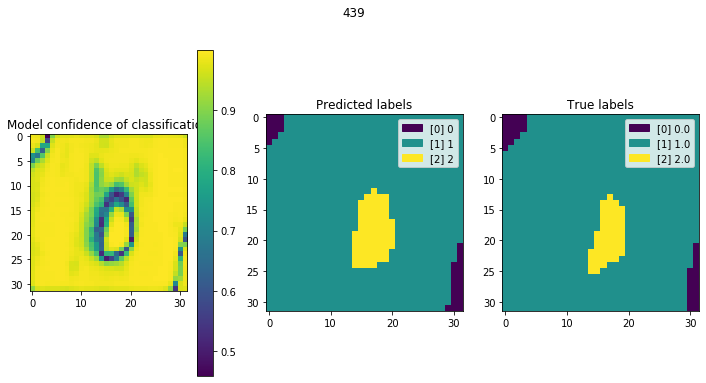

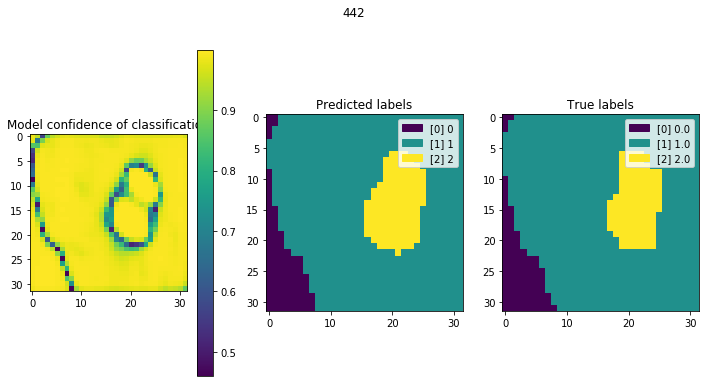

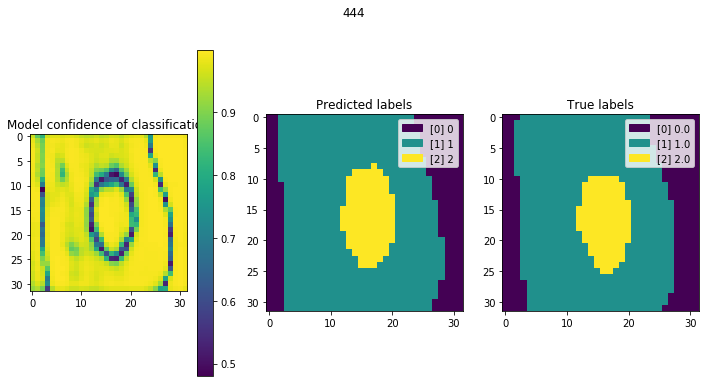

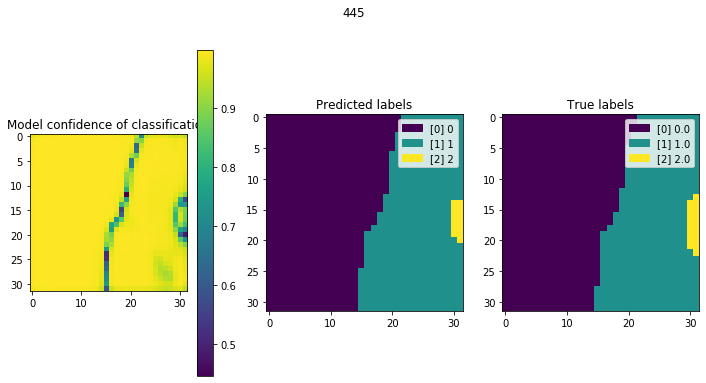

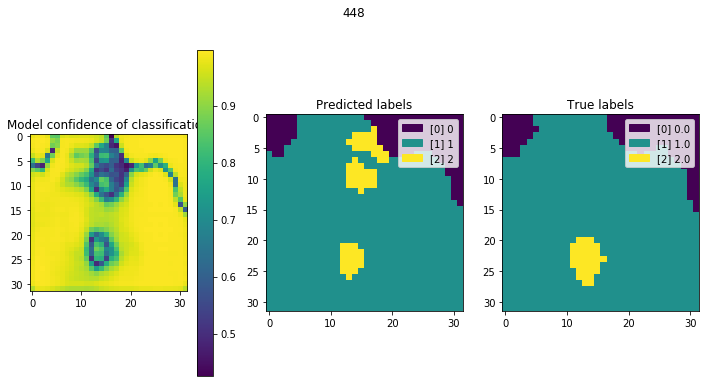

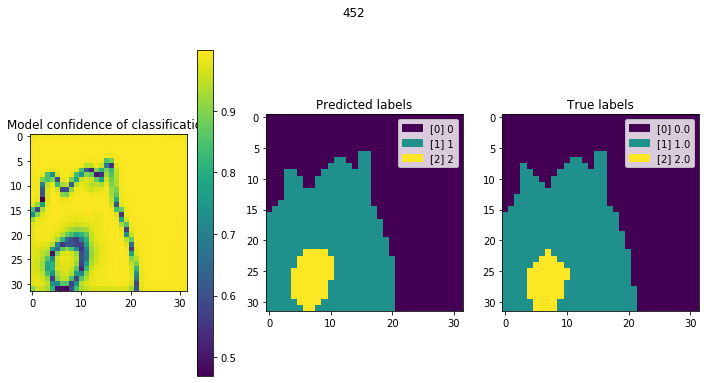

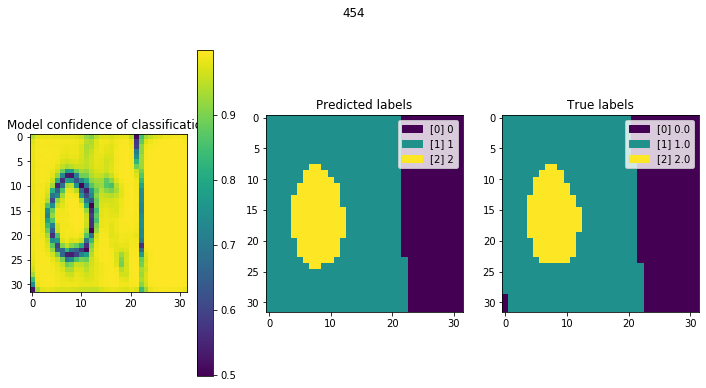

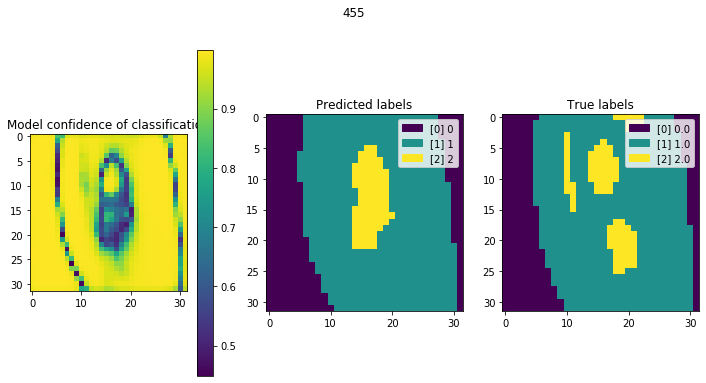

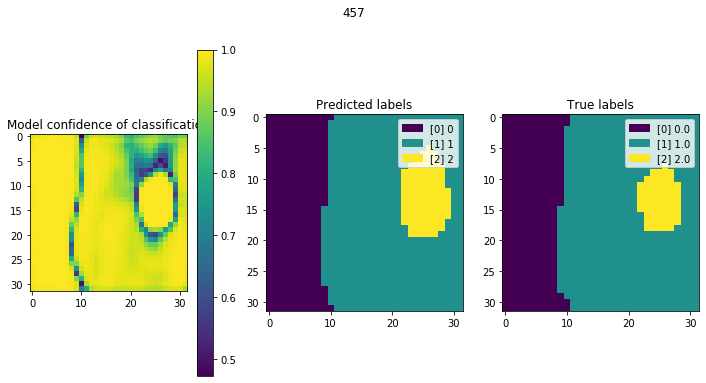

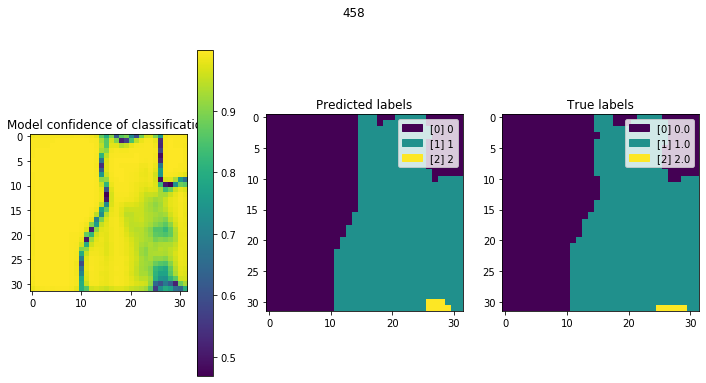

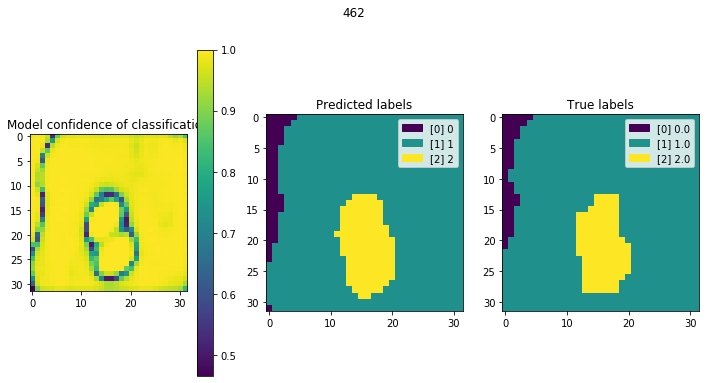

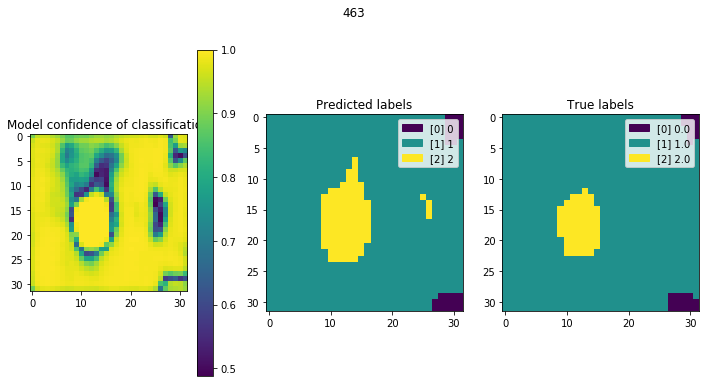

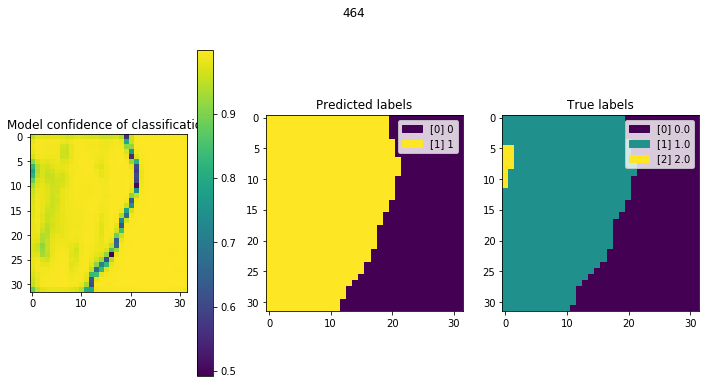

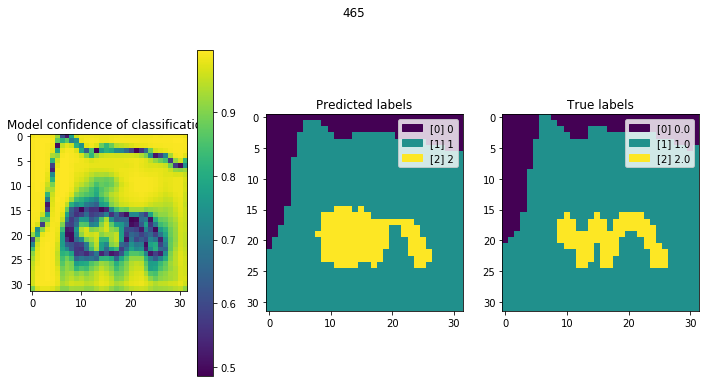

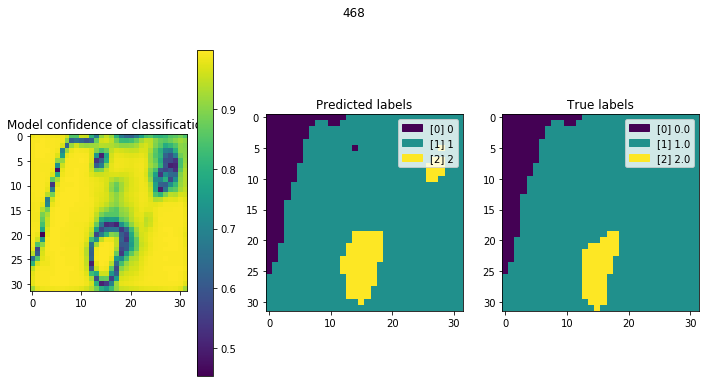

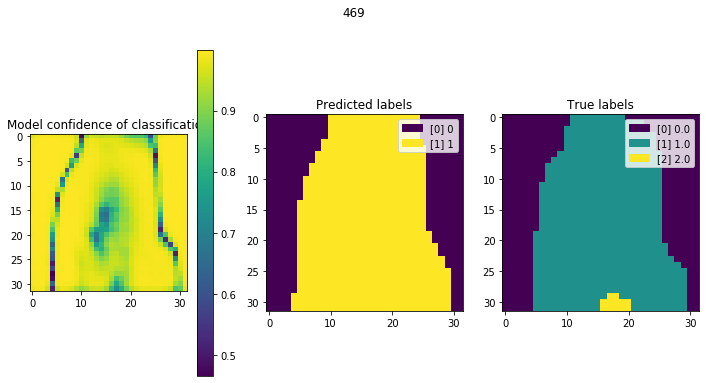

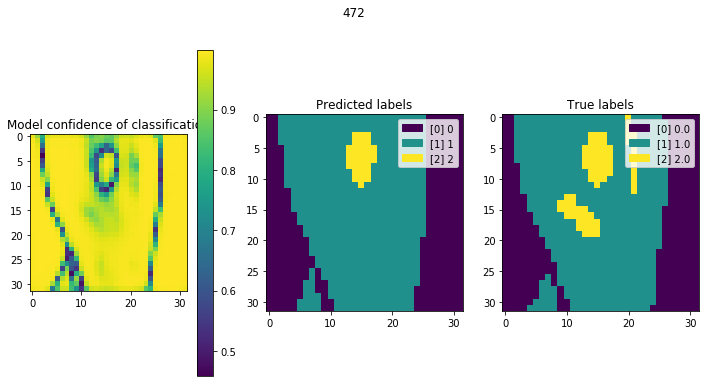

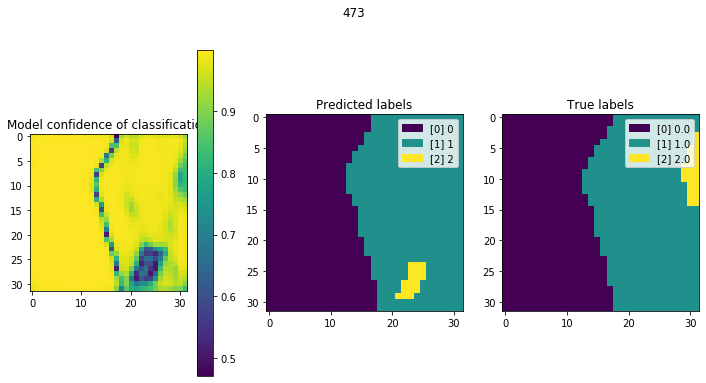

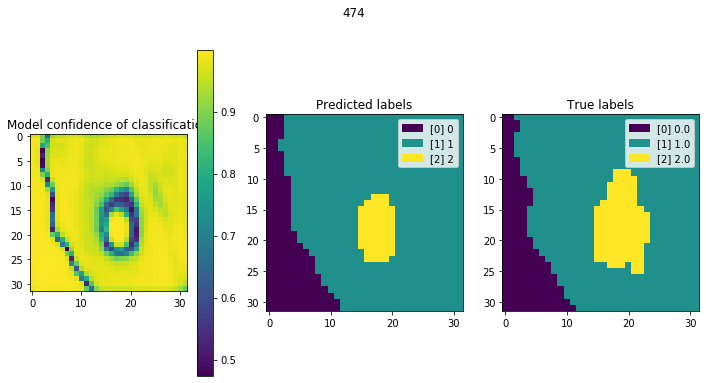

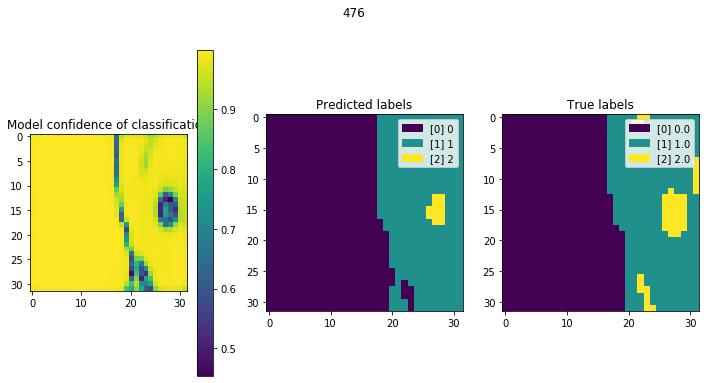

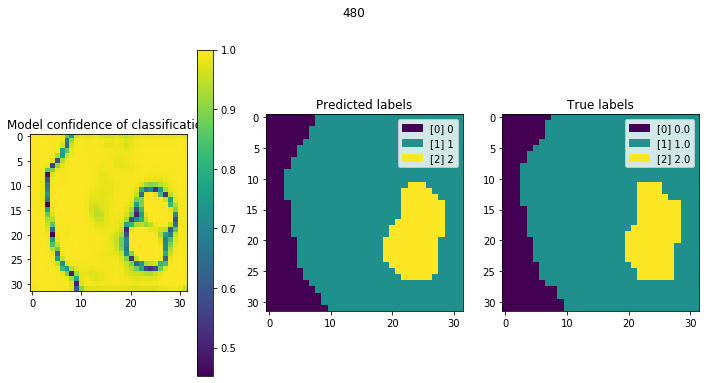

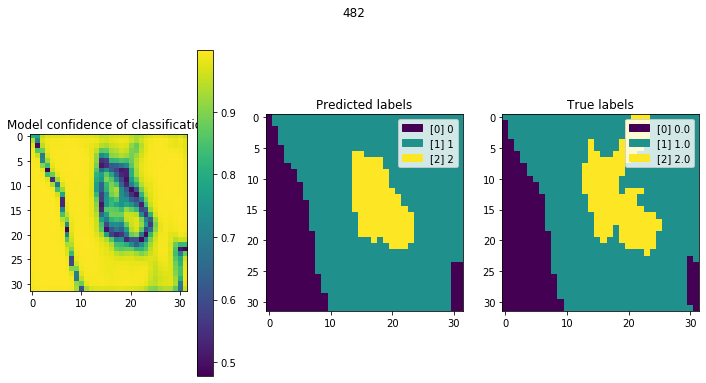

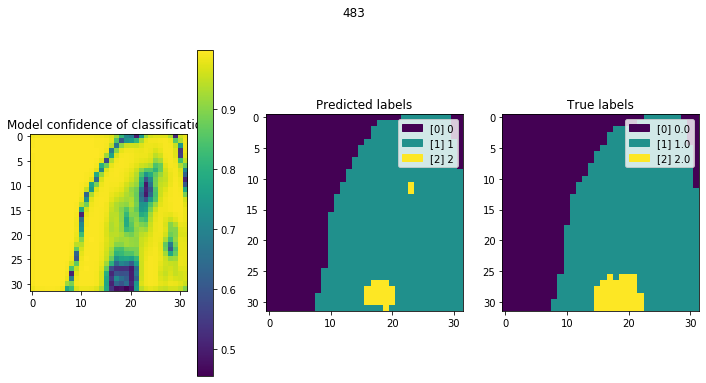

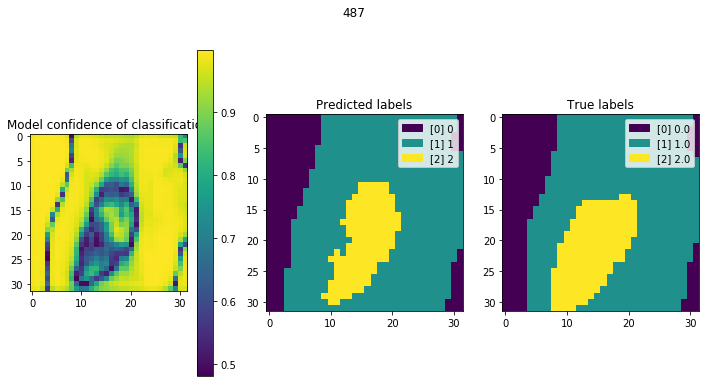

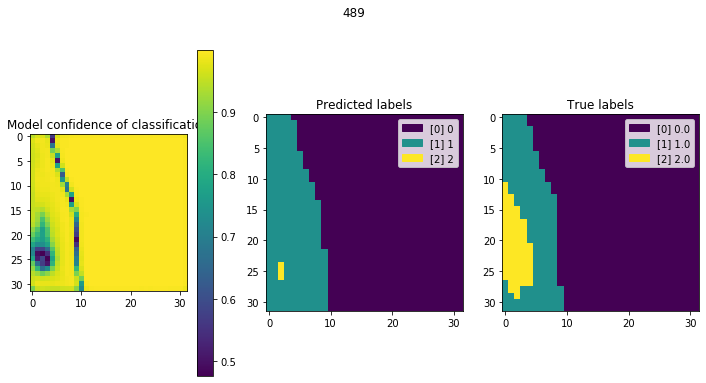

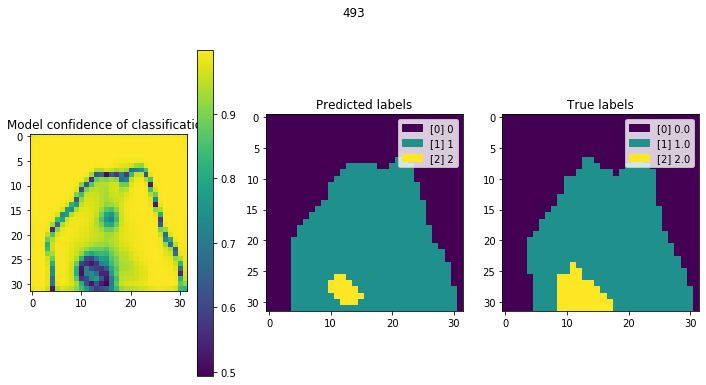

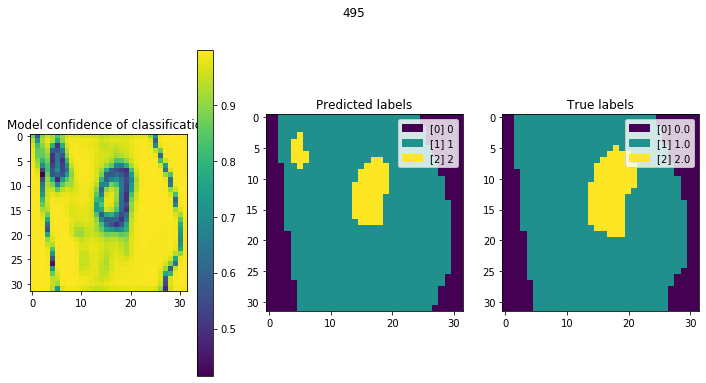

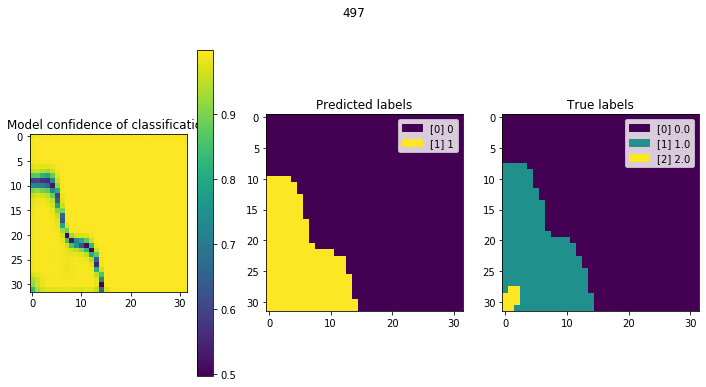

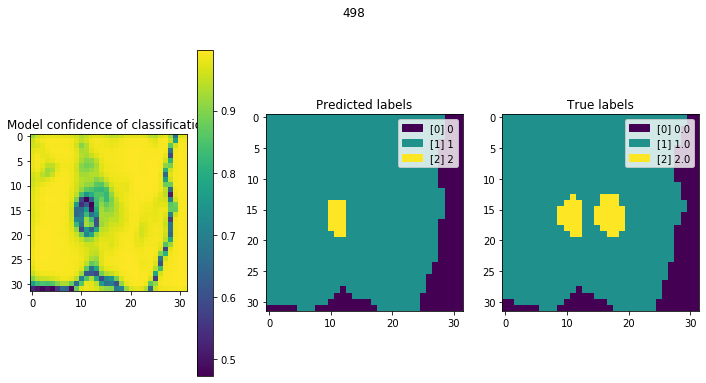

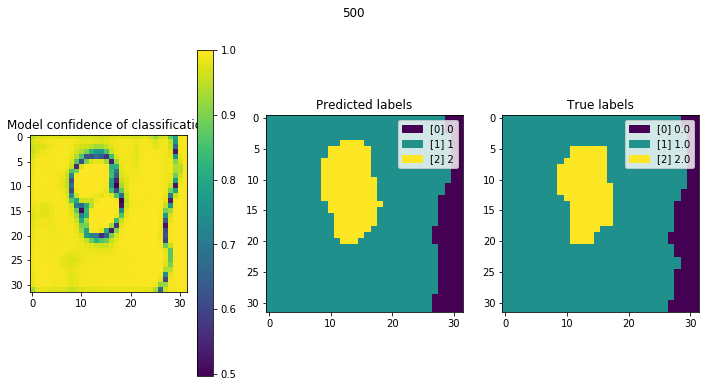

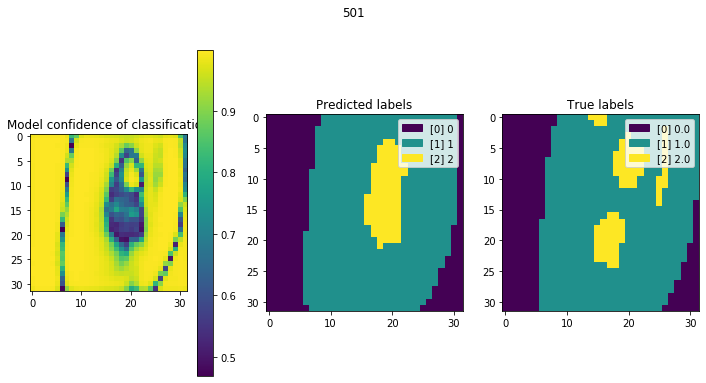

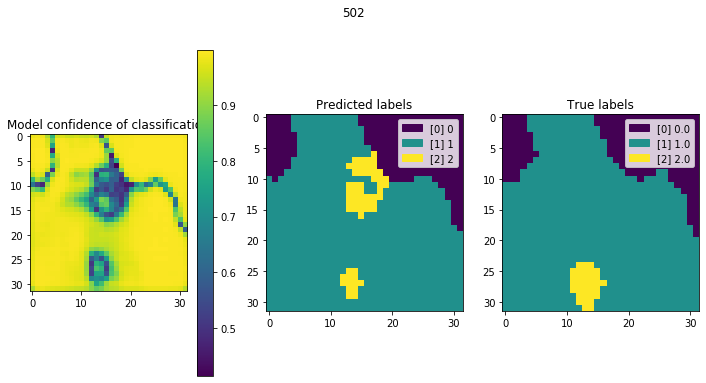

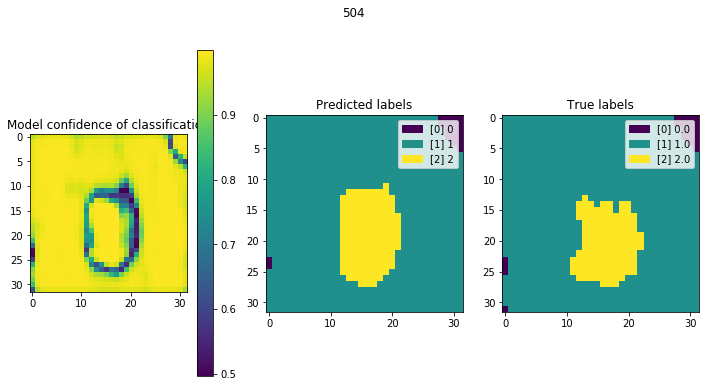

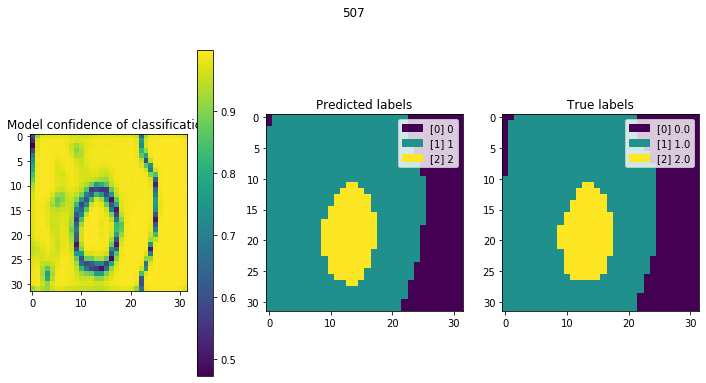

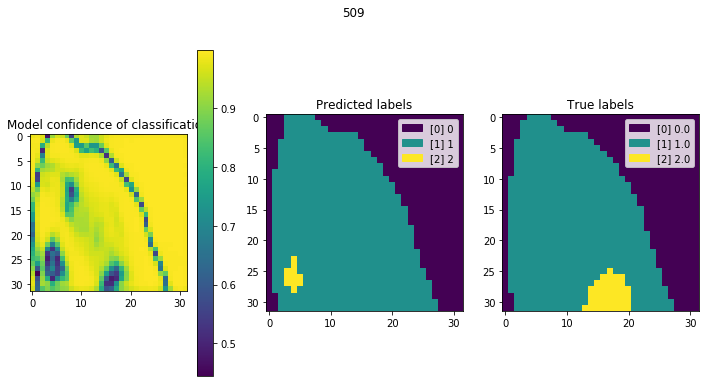

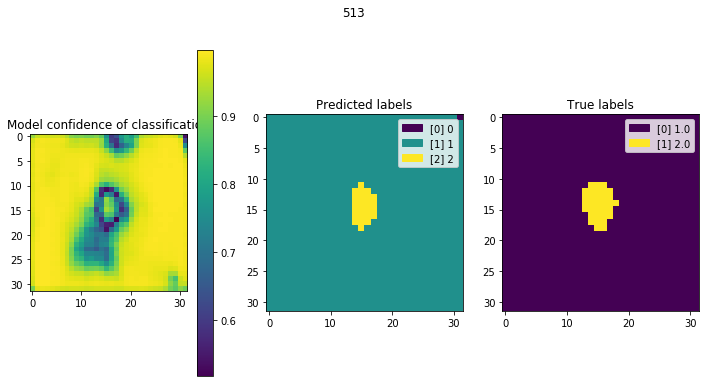

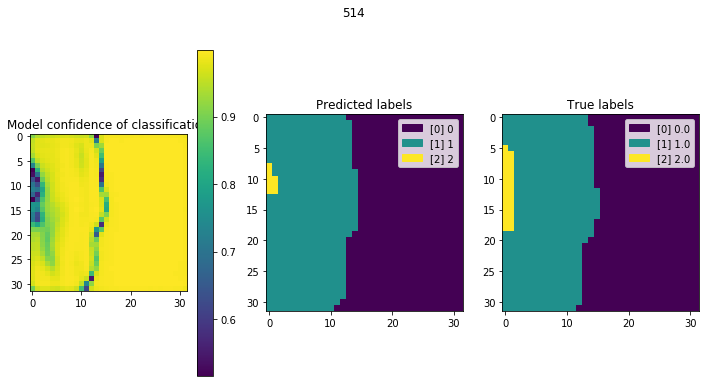

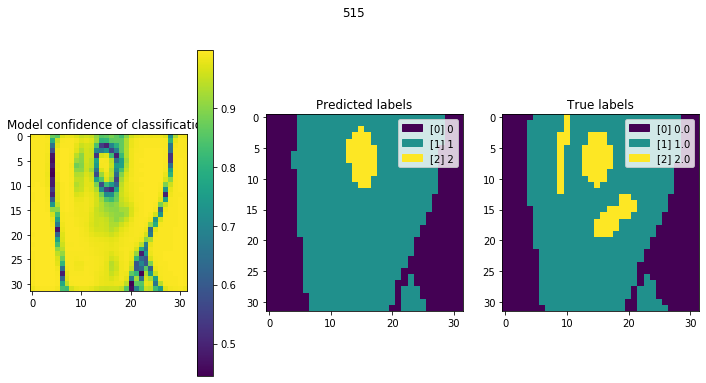

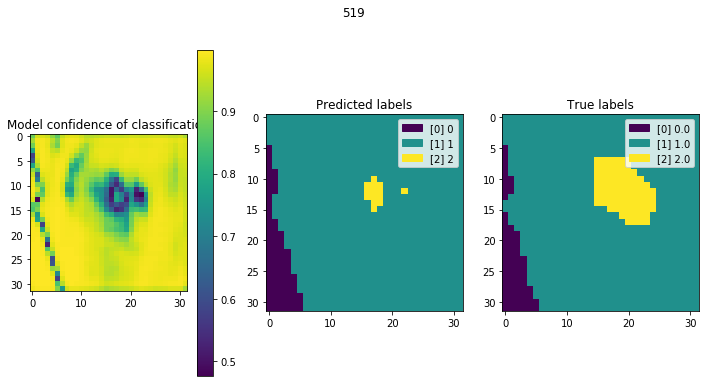

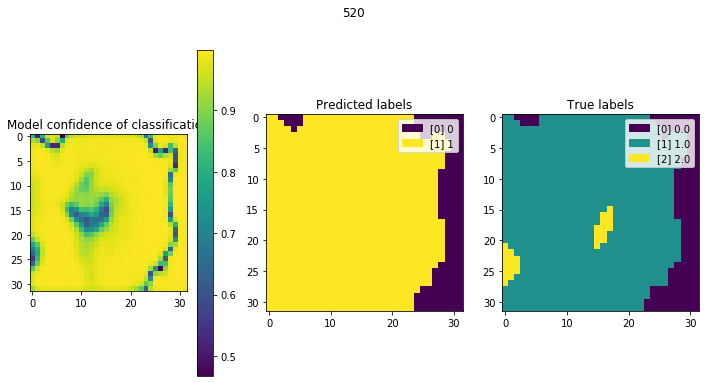

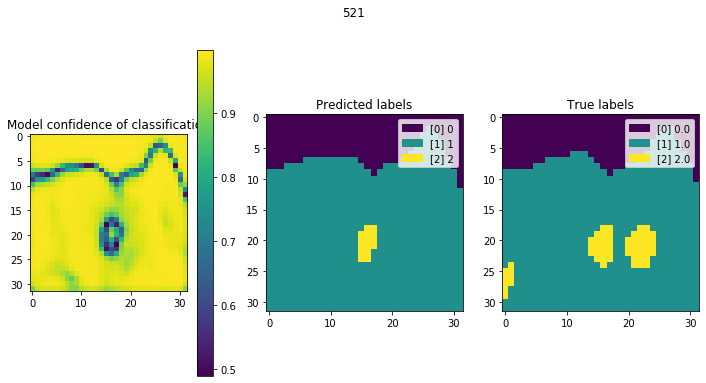

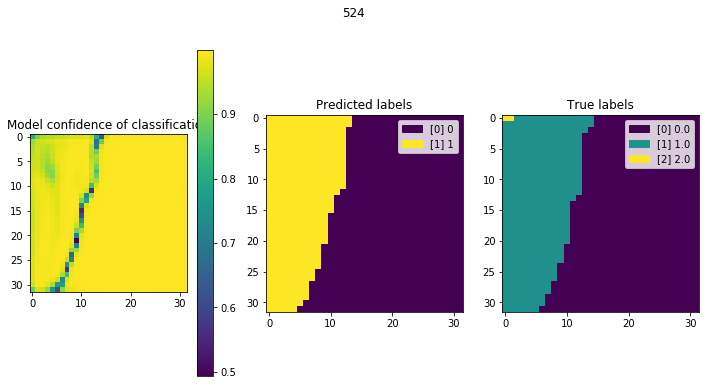

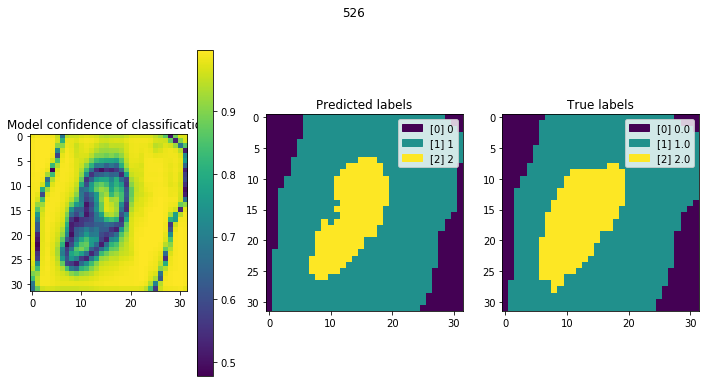

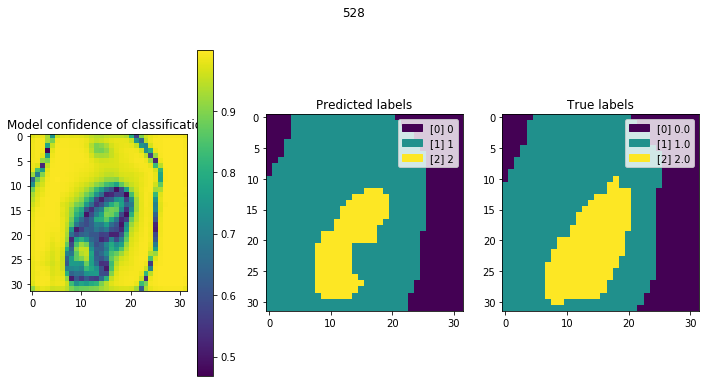

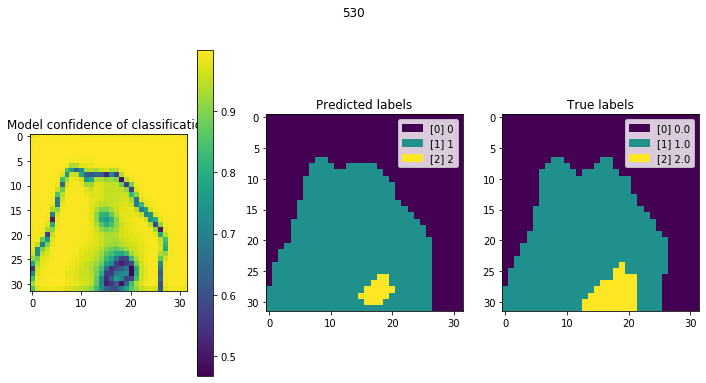

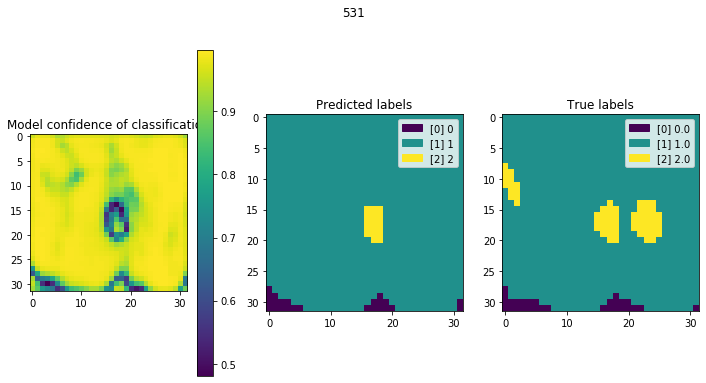

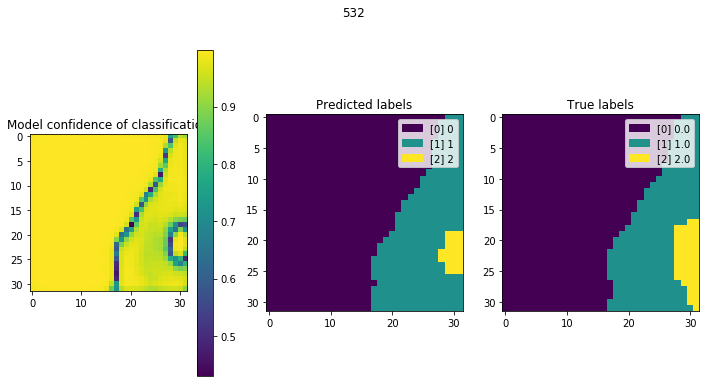

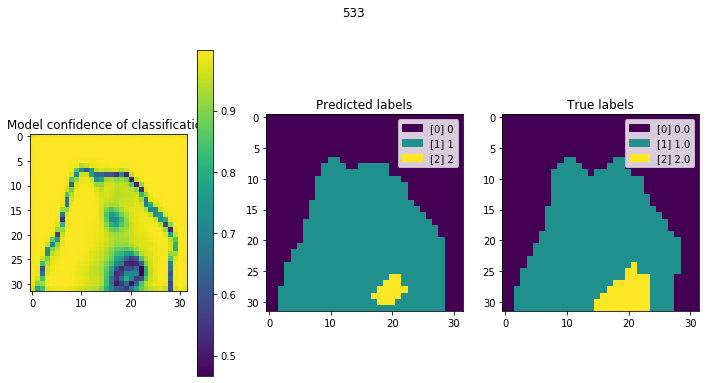

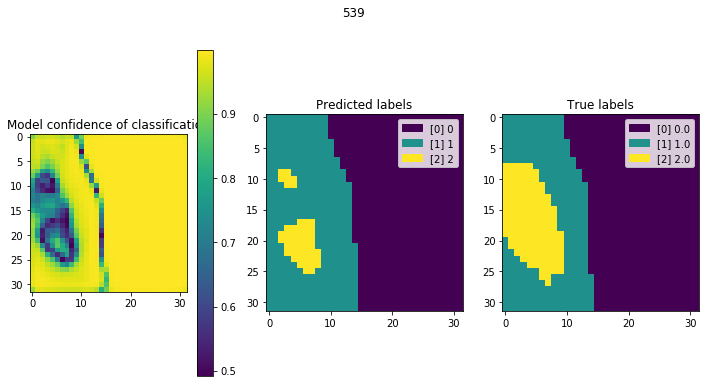

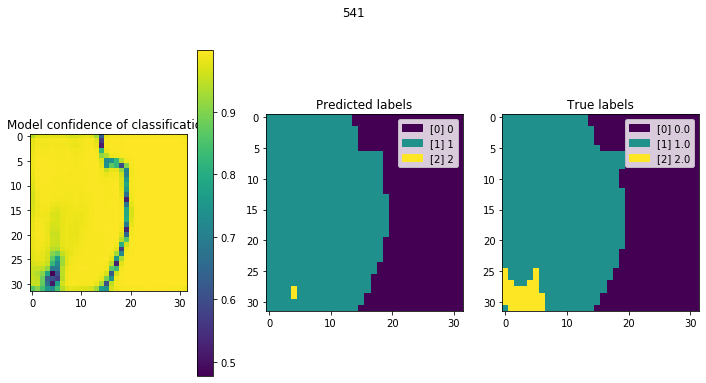

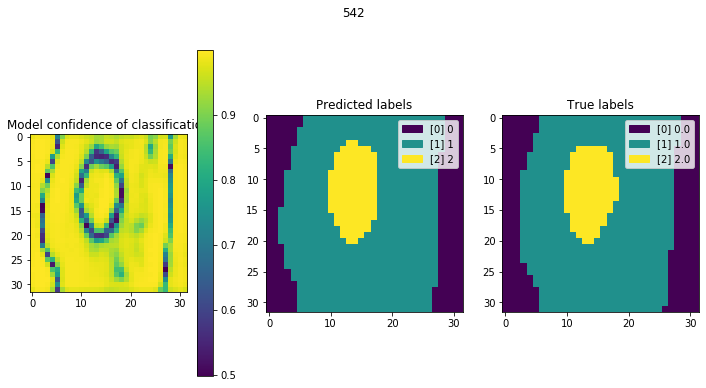

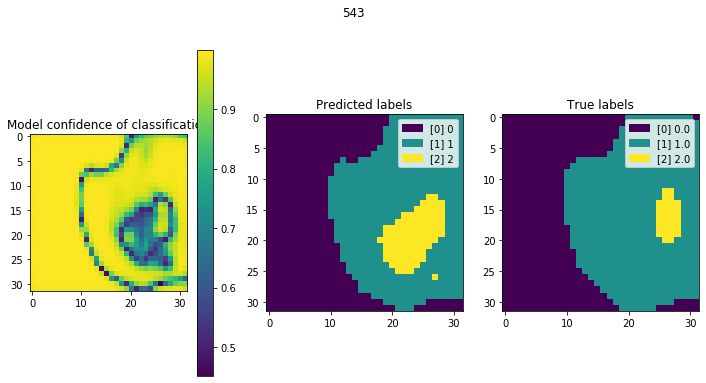

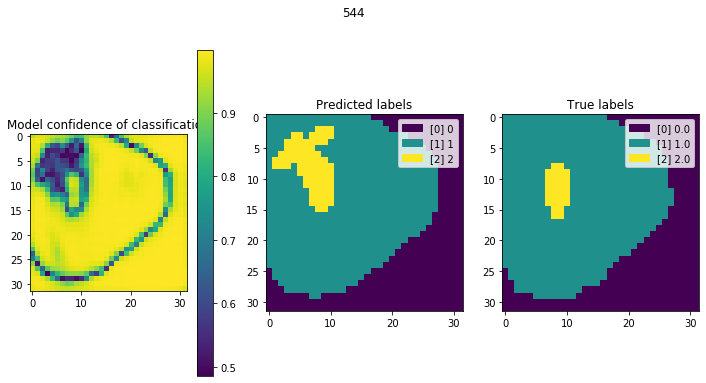

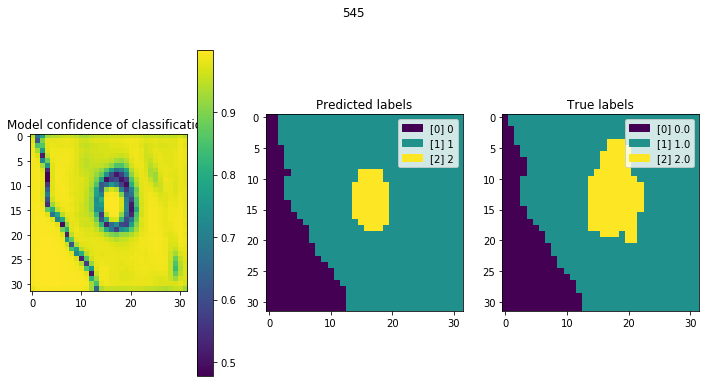

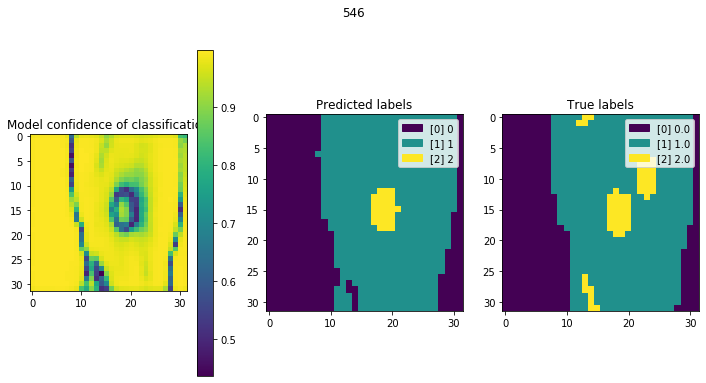

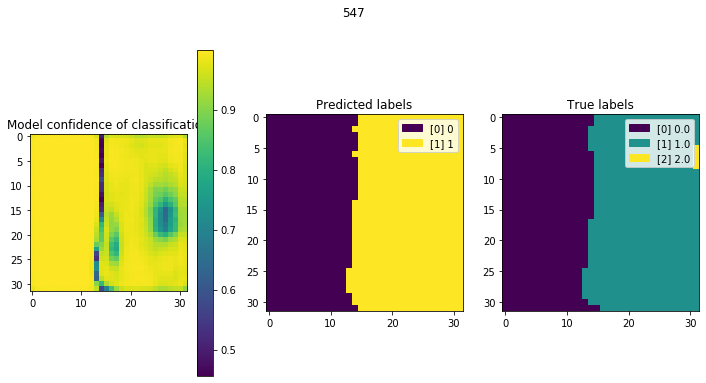

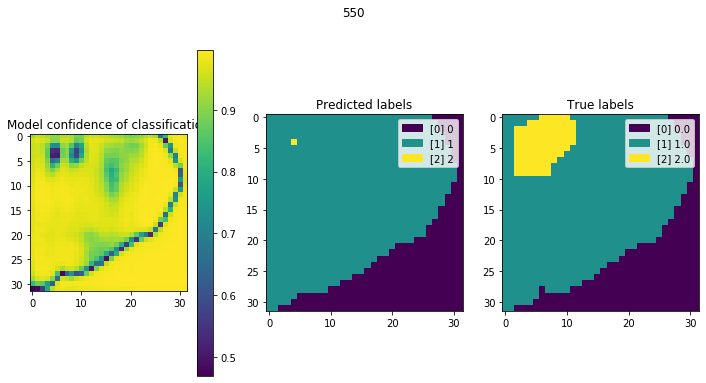

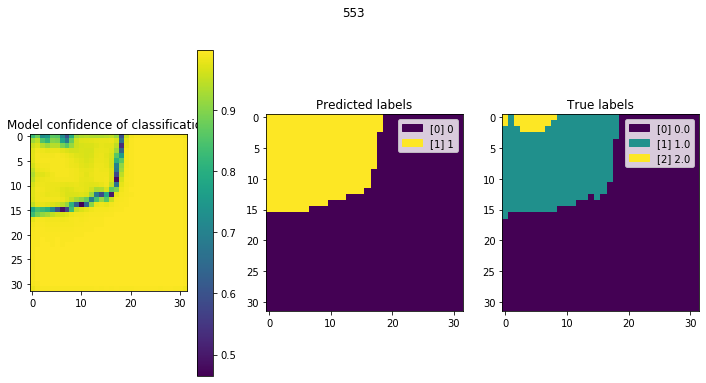

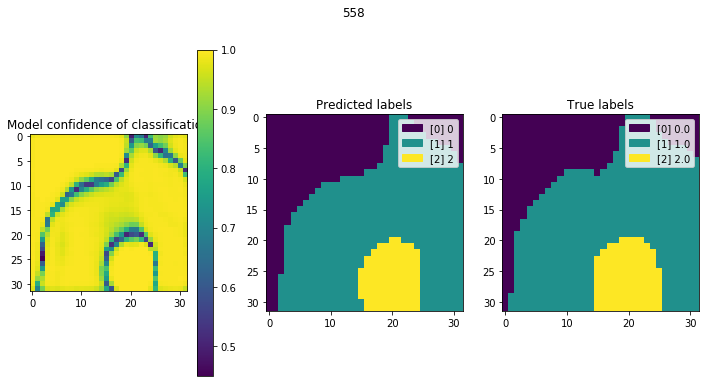

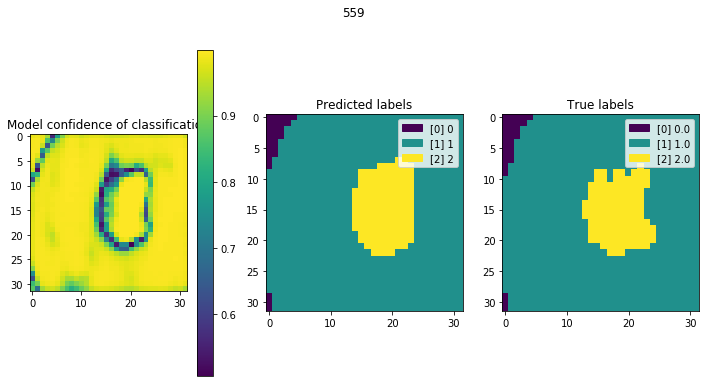

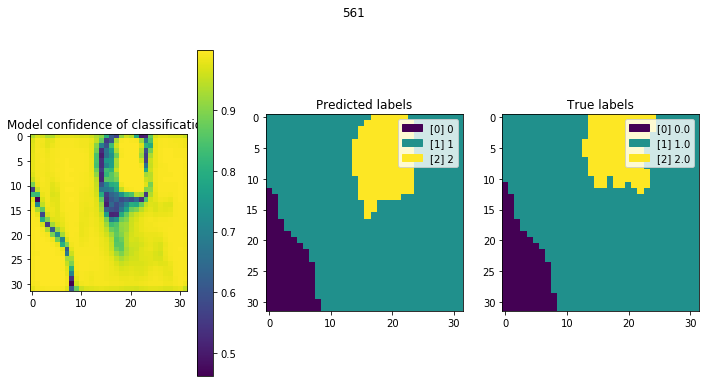

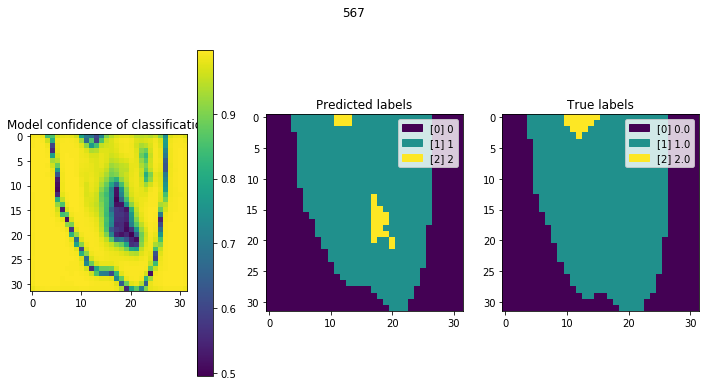

In [6]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y, img)
    plt.title("True labels")

y_pred_test, y_pred_heat = spectral_unet.predict(X_test, Y_labels=Y_test, return_heat_map=True);
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        plt.suptitle(i)

### Comparison of scaling methods



###################
# 1st_derivative #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-3.088449239730835, 2.5384438037872314) (380, 32, 32, 188) (840, 32, 32, 188)
(array([0., 1., 2.]), array([598426, 237968,  23766]))
(array([0., 1., 2.]), array([244880, 133599,  10641]))
2020-05-14 10:21:18.448433
Start training
Elapsed time: 1156.6703 seconds


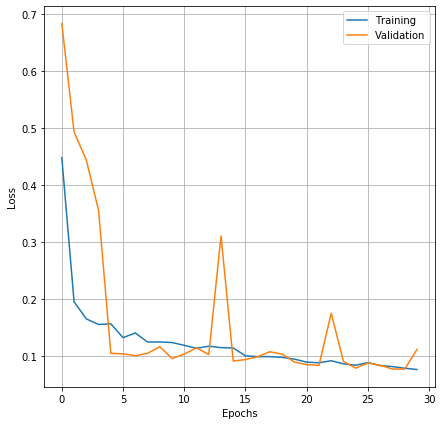

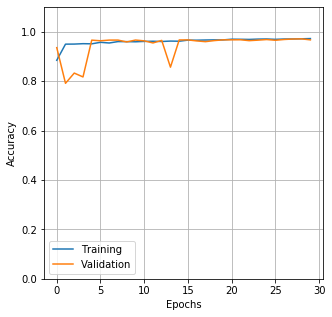

Predicting for train data
Elapsed time: 12.2318 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    598426
           1       0.95      0.97      0.96    237968
           2       0.83      0.73      0.78     23766

    accuracy                           0.98    860160
   macro avg       0.93      0.90      0.91    860160
weighted avg       0.98      0.98      0.98    860160



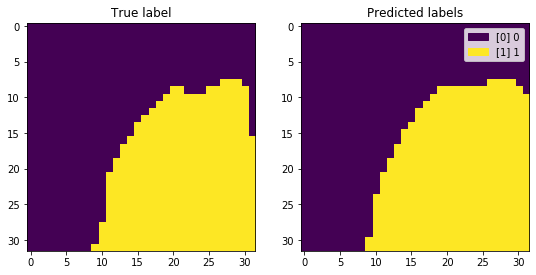

Predicting for test data
Elapsed time: 4.9548 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    244880
           1       0.96      0.97      0.96    133599
           2       0.76      0.67      0.71     10641

    accuracy                           0.97    389120
   macro avg       0.90      0.88      0.89    389120
weighted avg       0.97      0.97      0.97    389120



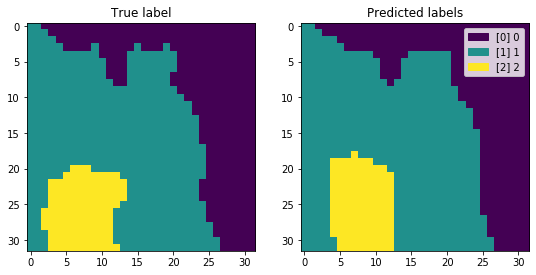

Elapsed time: 5.7647 seconds
Fasle positive blobs 22.
Fasle positive blobs per image 0.0579


###################
# 2nd_derivative #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-2.9872915744781494, 2.5239858627319336) (380, 32, 32, 188) (840, 32, 32, 188)
(array([0., 1., 2.]), array([607697, 231089,  21374]))
(array([0., 1., 2.]), array([236232, 140393,  12495]))
2020-05-14 10:41:01.757075
Start training


In [ ]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

for scaler_name in ['1st_derivative', '2nd_derivative', 'GlobalStandardization', 'NoScale']:
    print()
    print()
    print("###################")
    print(f"# {scaler_name} #")
    
    if scaler_name != 'NoScale':
        X_test_scaled, X_train_scaled, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler=scaler_name)
    else:
        X_test_scaled, X_train_scaled = X_test_orig, X_train_orig

    s, m = 32, 20
    X_train, Y_train = zoom(X_train_scaled, Y_train_orig, s, m)
    X_test,  Y_test  = zoom(X_test_scaled,  Y_test_orig,  s, m)

    print("np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape")
    print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
    print(np.unique(Y_train, return_counts=True))
    print(np.unique(Y_test, return_counts=True))

    print_current_time()

    spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
    print("Start training")
    timer.start()
    spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
    timer.stop()

    # spectral_unet.summary()
    spectral_unet.plot_training_results()
    print("Predicting for train data")
    spectral_unet.predict(X_train, Y_labels=Y_train)
    print("Predicting for test data")
    timer.start()
    y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
    timer.stop()
    mypackage.report_count_false_positive(y_pred_test, Y_test)
    
    if scaler_name == '1st_derivative':
        spectral_unet_1st = spectral_unet
    elif scaler_name == '2nd_derivative':
        spectral_unet_2nd = spectral_unet
    elif scaler_name == 'GlobalStandardization':
        spectral_unet_gs = spectral_unet
    elif scaler_name == 'NoScale':
        spectral_unet_ns = spectral_unet



###################
# 2nd_derivative #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-2.9872915744781494, 2.5239858627319336) (380, 32, 32, 188) (840, 32, 32, 188)
(array([0., 1., 2.]), array([603405, 234283,  22472]))
(array([0., 1., 2.]), array([244607, 133574,  10939]))
2020-05-14 10:48:43.165040
Start training
Elapsed time: 1107.6325 seconds


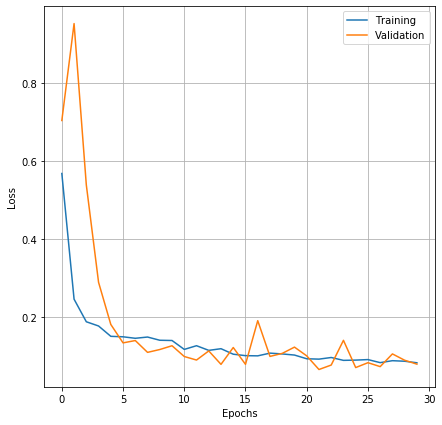

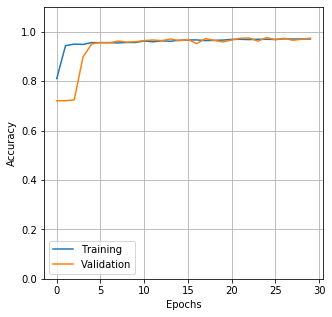

Predicting for train data
Elapsed time: 9.7164 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    603405
           1       0.94      0.98      0.96    234283
           2       0.89      0.52      0.66     22472

    accuracy                           0.98    860160
   macro avg       0.94      0.83      0.87    860160
weighted avg       0.97      0.98      0.97    860160



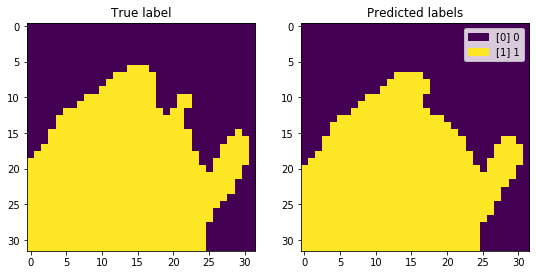

Predicting for test data
Elapsed time: 4.2797 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    244607
           1       0.94      0.97      0.95    133574
           2       0.96      0.30      0.46     10939

    accuracy                           0.97    389120
   macro avg       0.96      0.76      0.80    389120
weighted avg       0.97      0.97      0.96    389120



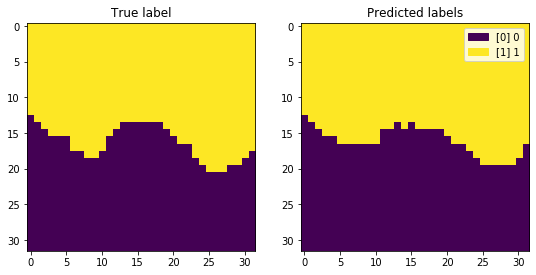

Elapsed time: 4.9894 seconds
Fasle positive blobs 0.
Fasle positive blobs per image 0.0000


###################
# GlobalStandardization #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (380, 32, 32, 208) (840, 32, 32, 208)
(array([0., 1., 2.]), array([607292, 230271,  22597]))
(array([0., 1., 2.]), array([251113, 128044,   9963]))
2020-05-14 11:07:30.703398
Start training
Elapsed time: 1230.7783 seconds


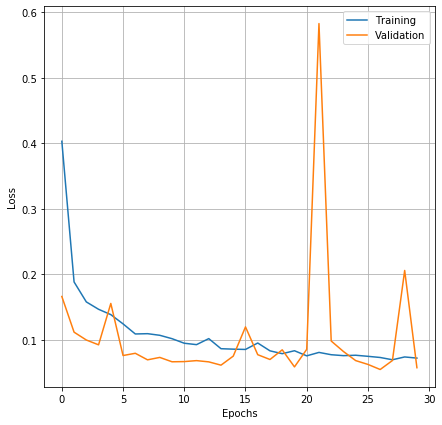

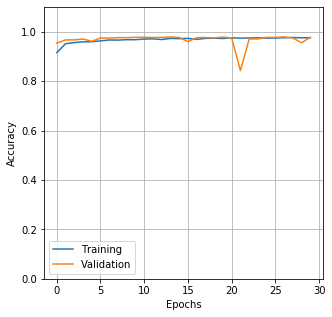

Predicting for train data
Elapsed time: 10.8609 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    607292
           1       0.96      0.97      0.97    230271
           2       0.85      0.78      0.81     22597

    accuracy                           0.98    860160
   macro avg       0.93      0.91      0.92    860160
weighted avg       0.98      0.98      0.98    860160



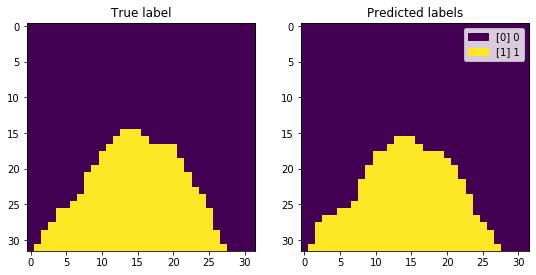

Predicting for test data
Elapsed time: 4.8111 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    251113
           1       0.97      0.96      0.96    128044
           2       0.79      0.71      0.75      9963

    accuracy                           0.98    389120
   macro avg       0.91      0.89      0.90    389120
weighted avg       0.98      0.98      0.98    389120



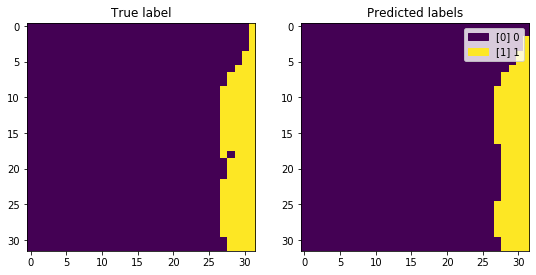

Elapsed time: 5.5252 seconds
Fasle positive blobs 52.
Fasle positive blobs per image 0.1368


###################
# NoScale #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (1.6682685613632202, 73.80110931396484) (380, 32, 32, 208) (840, 32, 32, 208)
(array([0., 1., 2.]), array([604571, 232934,  22655]))
(array([0., 1., 2.]), array([251202, 128827,   9091]))
2020-05-14 11:28:21.165359
Start training
Elapsed time: 1221.3930 seconds


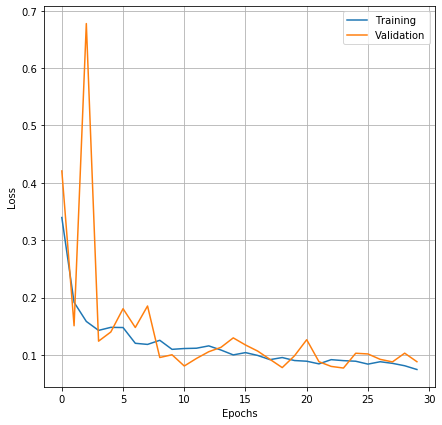

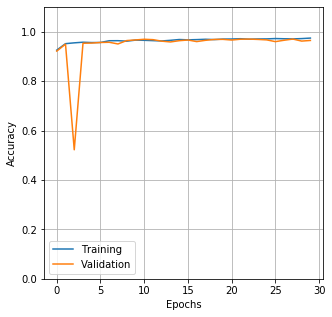

Predicting for train data
Elapsed time: 10.7156 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    604571
           1       0.95      0.97      0.96    232934
           2       0.88      0.61      0.72     22655

    accuracy                           0.98    860160
   macro avg       0.94      0.86      0.89    860160
weighted avg       0.98      0.98      0.98    860160



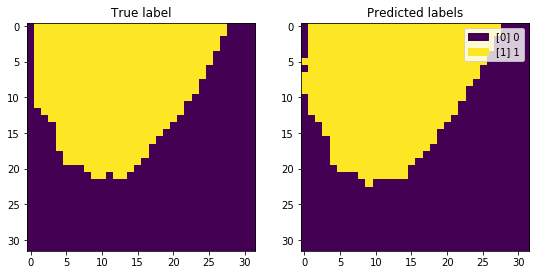

Predicting for test data
Elapsed time: 4.7361 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    251202
           1       0.97      0.97      0.97    128827
           2       0.81      0.66      0.73      9091

    accuracy                           0.98    389120
   macro avg       0.92      0.87      0.89    389120
weighted avg       0.98      0.98      0.98    389120



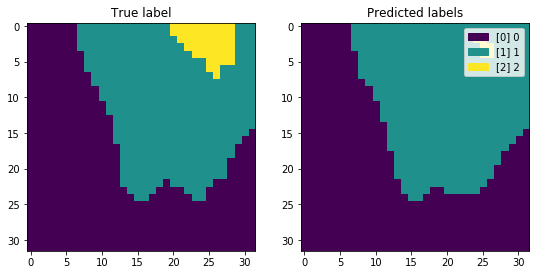

Elapsed time: 5.4398 seconds
Fasle positive blobs 55.
Fasle positive blobs per image 0.1447


###################
# 1st_derivative #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-2.9046599864959717, 2.7983524799346924) (380, 32, 32, 188) (840, 32, 32, 188)
(array([0., 1., 2.]), array([588927, 250523,  20710]))
(array([0., 1., 2.]), array([246784, 132439,   9897]))
2020-05-14 11:49:06.535441
Start training
Elapsed time: 1095.7752 seconds


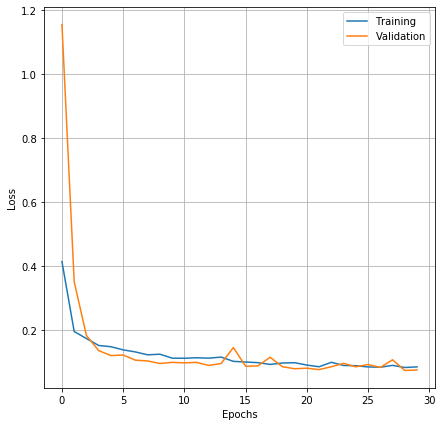

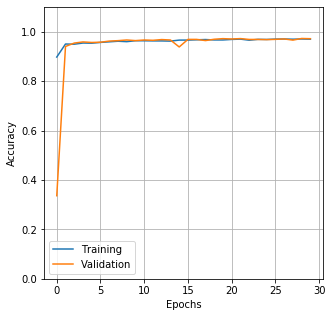

In [ ]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

for scaler_name in ['2nd_derivative', 'GlobalStandardization', 'NoScale', '1st_derivative']:
    print()
    print()
    print("###################")
    print(f"# {scaler_name} #")
    
    if scaler_name != 'NoScale':
        X_test_scaled, X_train_scaled, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler=scaler_name)
    else:
        X_test_scaled, X_train_scaled = X_test_orig, X_train_orig

    s, m = 32, 20
    X_train, Y_train = zoom(X_train_scaled, Y_train_orig, s, m)
    X_test,  Y_test  = zoom(X_test_scaled,  Y_test_orig,  s, m)

    print("np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape")
    print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
    print(np.unique(Y_train, return_counts=True))
    print(np.unique(Y_test, return_counts=True))

    print_current_time()

    spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
    print("Start training")
    timer.start()
    spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
    timer.stop()

    # spectral_unet.summary()
    spectral_unet.plot_training_results()
    print("Predicting for train data")
    spectral_unet.predict(X_train, Y_labels=Y_train)
    print("Predicting for test data")
    timer.start()
    y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
    timer.stop()
    mypackage.report_count_false_positive(y_pred_test, Y_test)
    
    if scaler_name == '1st_derivative':
        spectral_unet_1st = spectral_unet
    elif scaler_name == '2nd_derivative':
        spectral_unet_2nd = spectral_unet
    elif scaler_name == 'GlobalStandardization':
        spectral_unet_gs = spectral_unet
    elif scaler_name == 'NoScale':
        spectral_unet_ns = spectral_unet



###################
# 1st_derivative #
np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape
[0. 1. 2.] (380, 32, 32, 1) (-2.885110378265381, 2.6235334873199463) (380, 32, 32, 188) (840, 32, 32, 188)
(array([0., 1., 2.]), array([598482, 239194,  22484]))
(array([0., 1., 2.]), array([245171, 132589,  11360]))
2020-05-14 12:16:35.984736
Predicting for train data
Elapsed time: 9.7347 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    598482
           1       0.94      0.98      0.96    239194
           2       0.84      0.58      0.69     22484

    accuracy                           0.97    860160
   macro avg       0.92      0.85      0.88    860160
weighted avg       0.97      0.97      0.97    860160



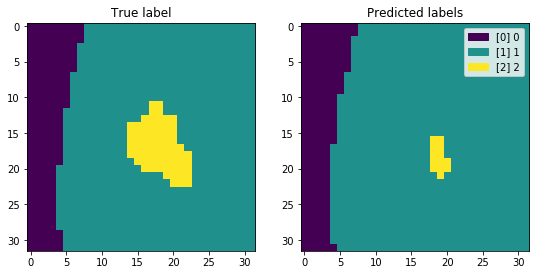

Predicting for test data
Elapsed time: 4.4523 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    245171
           1       0.94      0.98      0.96    132589
           2       0.89      0.43      0.58     11360

    accuracy                           0.97    389120
   macro avg       0.94      0.80      0.84    389120
weighted avg       0.97      0.97      0.97    389120



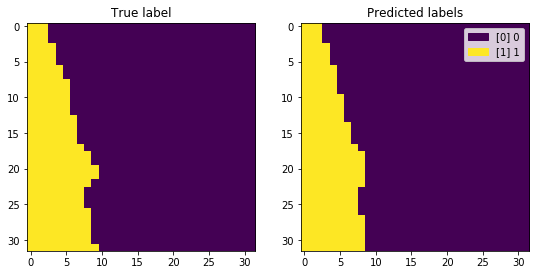

Elapsed time: 5.1683 seconds
Fasle positive blobs 5.
Fasle positive blobs per image 0.0132


#### Notes on these results
1st derivative
    Train - 0.83      0.73      0.78     23766
    Test  - 0.76      0.67      0.71     10641
2nd derivative
    Train - 0.89      0.52      0.66     22472
    Test  - 0.96      0.30      0.46     10939
GS
    Train - 0.85      0.78      0.81     22597
    Test  - 0.79      0.71      0.75      9963
NoScale
    Train - 0.88      0.61      0.72     22655
    Test  - 0.81      0.66      0.73      9091
1st derivative again
    Train - 0.84      0.58      0.69     22484
    Test  - 0.89      0.43      0.58     11360